Questions pour Pierre:
    - dfApplicationTest, pas de flag donc pour tester le dashboard
    - équivalent de AUC pour courbe precision-rappel?
    - A. Géron: plutôt courbe précision-rappel si la classe positive est rare (inbalanced classification) ou si on attache plus d'importance aux faux positifs qu'aux faux négatifs
    - cas flagués 0, quid pour eux de la proba de faire défaut? ne faudrait-il pas avoir une proba plutôt que 0 en label?
    - Comment est modélisé un client qui a deux crédits actifs en cours (on a deux lignes dans application_train)
    - GridSearchCV: cherche le meilleur paramètre en terme de métrique mais pas de temps de traitement

In [1]:
# https://www.kaggle.com/mathchi/home-credit-risk-with-detailed-feature-engineering
# https://www.kaggle.com/ngainoriko/home-credit-bureau-feature-engineering

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os
import datetime
import time
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

# Import des fichiers

In [4]:
time1 = time.time()
dfApplicationTest = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv',",")
dfApplicationTrain = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
time2 = time.time()
print(time2-time1)

26.519582748413086


# Préparation d'un set de validation

In [4]:
dfApplicationTrain, dfApplicationTrainVal = train_test_split(dfApplicationTrain, test_size=0.33, random_state=1)

In [6]:
dfPreviousApplication = dfPreviousApplication.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
dfBureau = dfBureau.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')

# Marquage des valeurs manquantes

In [10]:
dfApplicationTrain = dfApplicationTrain.replace('XNA', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XNA', np.nan)
dfApplicationTrain = dfApplicationTrain.replace('XAP', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)
dfBureauBalance = dfBureauBalance.replace('X', np.nan)

# Exploration de application_train

## Suppression de champs non pertinents

In [11]:
col_to_del = [
'FLAG_MOBIL', # Did client provide mobile phone
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL',

# ininéressant
'NAME_TYPE_SUITE',  # Who was accompanying client when he was applying for the loan
'DAYS_ID_PUBLISH', # How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
'DAYS_REGISTRATION', # How many days before the application did client change his registration,time only relative to the application
'WEEKDAY_APPR_PROCESS_START', # On which day of the week did the client apply for the loan
'HOUR_APPR_PROCESS_START', # Approximately at what hour did the client apply for the loan,rounded
'DAYS_LAST_PHONE_CHANGE', # How many days before application did client change phone

# flags de comparaison de donnée
'REG_REGION_NOT_LIVE_REGION', # Flag if client's permanent address does not match contact address
'REG_REGION_NOT_WORK_REGION', # Flag if client's permanent address does not match contact address
'LIVE_REGION_NOT_WORK_REGION', # Flag if client's contact address does not match work address
'REG_CITY_NOT_LIVE_CITY',
'REG_CITY_NOT_WORK_CITY',
'LIVE_CITY_NOT_WORK_CITY',
    
]

for col in col_to_del:
    del dfApplicationTrain[col]
    
for col in dfApplicationTrain:
    if col[0:13] == 'FLAG_DOCUMENT':  # Did client provide document
        del dfApplicationTrain[col]

## Aperçu des valeurs manquantes

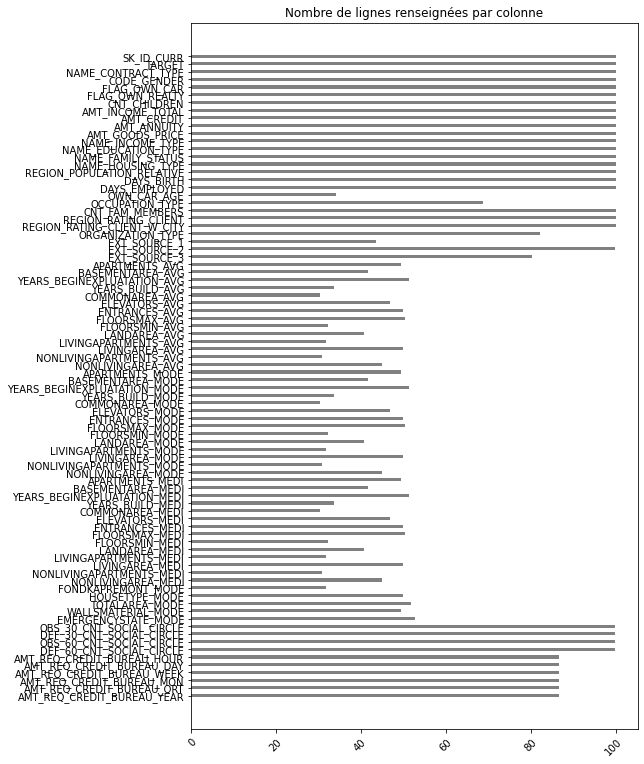

In [12]:
myDf(dfApplicationTrain).ColCountLinesChart(typeChart='barh', displayColName=True)

## Recherche de corrélations

### Requests

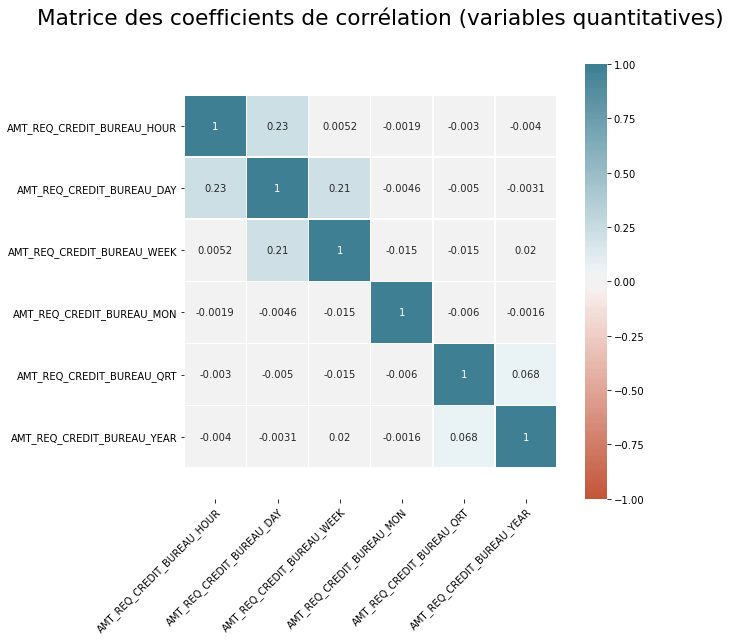

In [13]:
myDf(dfApplicationTrain).Stat(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [14]:
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_YEAR, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_QRT'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_QRT, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_MON'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_DAY'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY, axis=1)

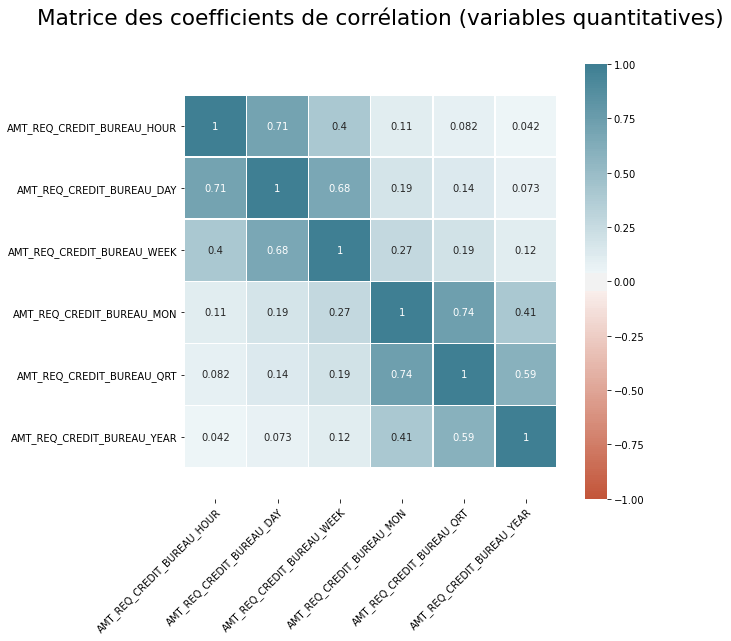

In [15]:
myDf(dfApplicationTrain).Stat(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [16]:
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_HOUR']
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_DAY']
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_MON']
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_QRT']

### External source

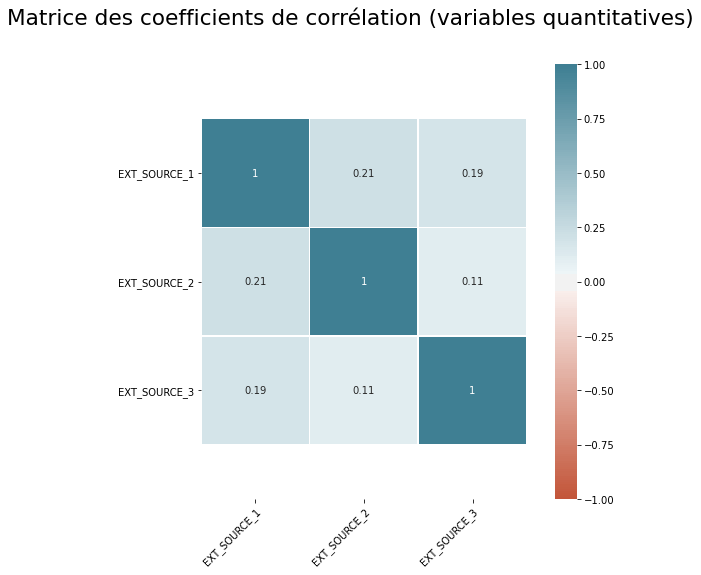

In [17]:
myDf(dfApplicationTrain).Stat(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

### External source 1 & days birth

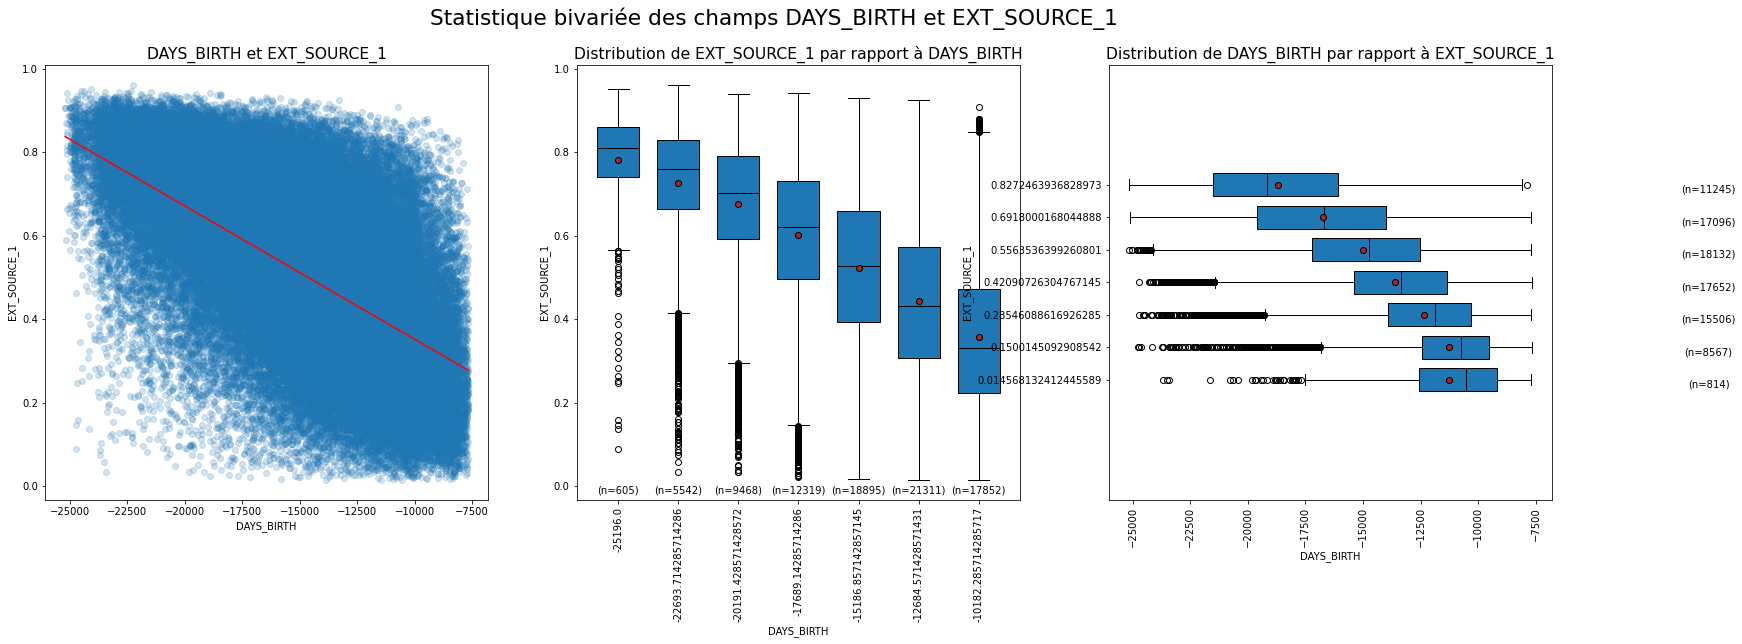

Covariance entre DAYS_BIRTH et EXT_SOURCE_1 : -497.7527370405132 
Covariance débiaisée entre DAYS_BIRTH et EXT_SOURCE_1 : -497.75828698963613 
Coefficient de correlation linéaire entre DAYS_BIRTH et EXT_SOURCE_1 : -0.5987859131817657 
Régression linéaire entre DAYS_BIRTH et EXT_SOURCE_1: y = -3.198143095463258e-05x + 0.0319886559196023
Coefficient de détermination entre DAYS_BIRTH et EXT_SOURCE_1 : 0.358544569824921 


In [18]:
myDf(dfApplicationTrain).Stat(['EXT_SOURCE_1','DAYS_BIRTH'], typeStat='biv')

In [19]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['EXT_SOURCE_1', 'DAYS_BIRTH']].isnull()).sum()

Nombre de lignes avec le champ vide:


EXT_SOURCE_1    116345
DAYS_BIRTH           0
dtype: int64

In [20]:
del dfApplicationTrain['EXT_SOURCE_1']

### Social circle

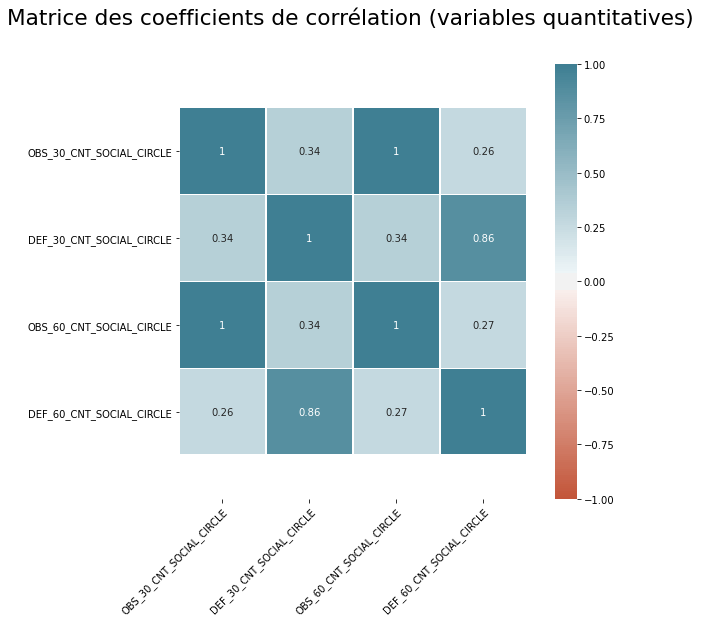

In [21]:
myDf(dfApplicationTrain).Stat(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [22]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].isnull()).sum()

Nombre de lignes avec le champ vide:


OBS_30_CNT_SOCIAL_CIRCLE    681
DEF_30_CNT_SOCIAL_CIRCLE    681
OBS_60_CNT_SOCIAL_CIRCLE    681
DEF_60_CNT_SOCIAL_CIRCLE    681
dtype: int64

In [23]:
del dfApplicationTrain['OBS_60_CNT_SOCIAL_CIRCLE']
del dfApplicationTrain['DEF_60_CNT_SOCIAL_CIRCLE']

### Car

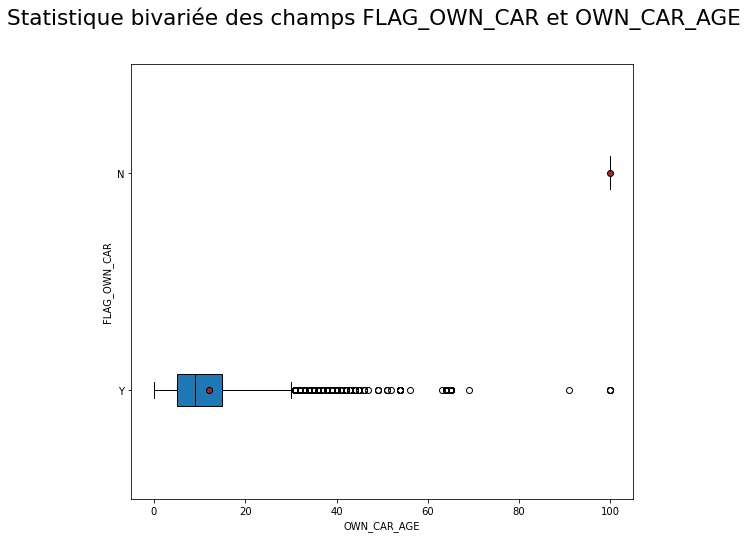

Rapport de corrélation entre FLAG_OWN_CAR et OWN_CAR_AGE: 0.9725873094051383


In [24]:
myDf(dfApplicationTrain[['FLAG_OWN_CAR','OWN_CAR_AGE']].replace(np.nan,100)).Stat(['FLAG_OWN_CAR','OWN_CAR_AGE'], typeStat='biv')

In [25]:
del dfApplicationTrain['OWN_CAR_AGE']

### Familly

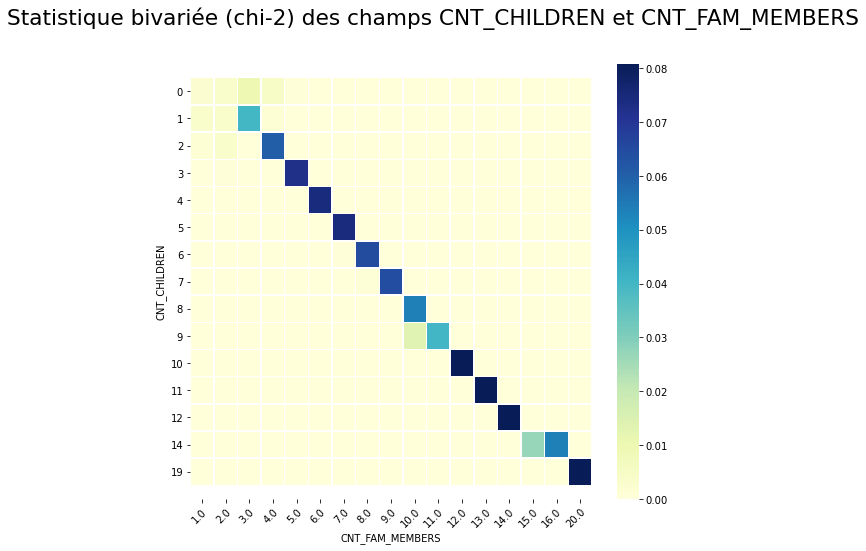

chi-2 entre CNT_CHILDREN et CNT_FAM_MEMBERS : 2551264.4820845732 
phi-2 entre CNT_CHILDREN et CNT_FAM_MEMBERS : 12.382975693270753 
coefficient T de Tschuprow entre CNT_CHILDREN et CNT_FAM_MEMBERS : 0.9096001130105066 
coefficient C de Cramer entre CNT_CHILDREN et CNT_FAM_MEMBERS : 0.9404776785256808 


In [26]:
myDf(dfApplicationTrain).Stat(['CNT_CHILDREN','CNT_FAM_MEMBERS'], typeStat='biv')

In [27]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['CNT_CHILDREN','CNT_FAM_MEMBERS']].isnull()).sum()

Nombre de lignes avec le champ vide:


CNT_CHILDREN       0
CNT_FAM_MEMBERS    2
dtype: int64

In [28]:
del dfApplicationTrain['CNT_FAM_MEMBERS']

### Amount

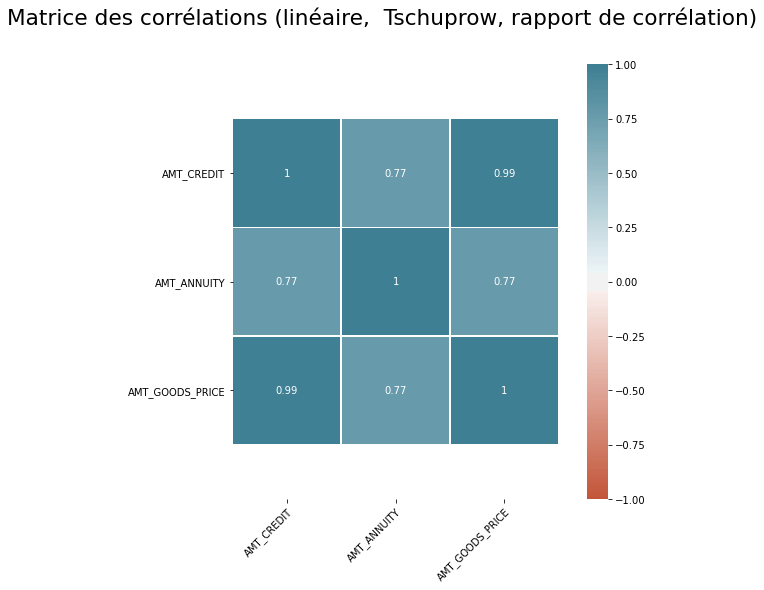

In [29]:
myDf(dfApplicationTrain).Stat(['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'], typeStat='biv', bivOnlyCorrTable=True)

In [30]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_CREDIT           0
AMT_ANNUITY          9
AMT_GOODS_PRICE    191
dtype: int64

In [31]:
del dfApplicationTrain['AMT_ANNUITY']
del dfApplicationTrain['AMT_GOODS_PRICE']

### Income / employment

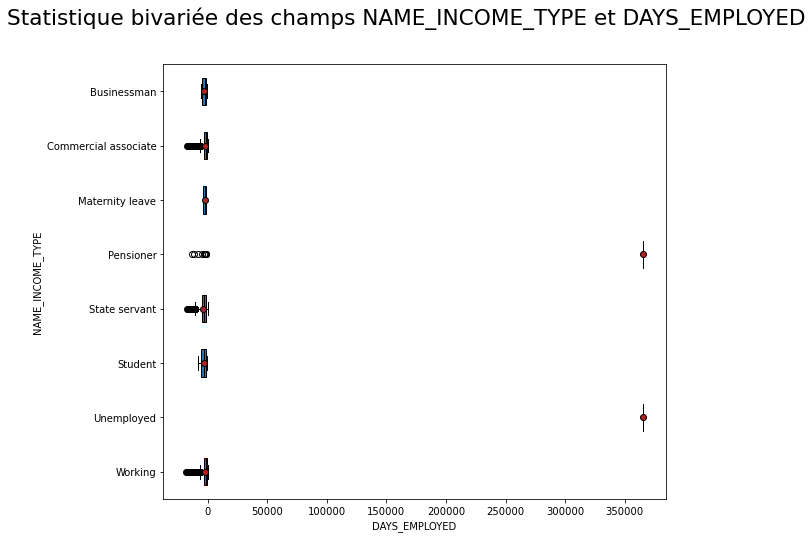

Rapport de corrélation entre NAME_INCOME_TYPE et DAYS_EMPLOYED: 0.9994483874873606


In [32]:
myDf(dfApplicationTrain).Stat(['NAME_INCOME_TYPE','DAYS_EMPLOYED'], typeStat='biv')

In [33]:
print('NAME_INCOME_TYPE avec days employed positif::')
dfApplicationTrain[dfApplicationTrain.DAYS_EMPLOYED > 0].NAME_INCOME_TYPE.unique()

NAME_INCOME_TYPE avec days employed positif::


array(['Pensioner', 'Unemployed'], dtype=object)

In [34]:
dfApplicationTrain['DAYS_EMPLOYED'] = dfApplicationTrain.apply(lambda x: np.where(x.DAYS_EMPLOYED>0,1,x.DAYS_EMPLOYED),axis=1)

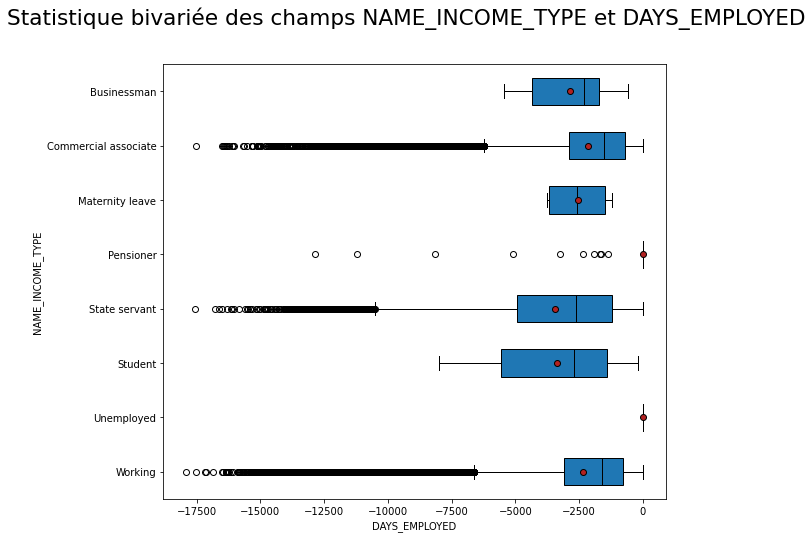

Rapport de corrélation entre NAME_INCOME_TYPE et DAYS_EMPLOYED: 0.17589310266367872


In [35]:
myDf(dfApplicationTrain).Stat(['NAME_INCOME_TYPE','DAYS_EMPLOYED'], typeStat='biv')

### Region rating

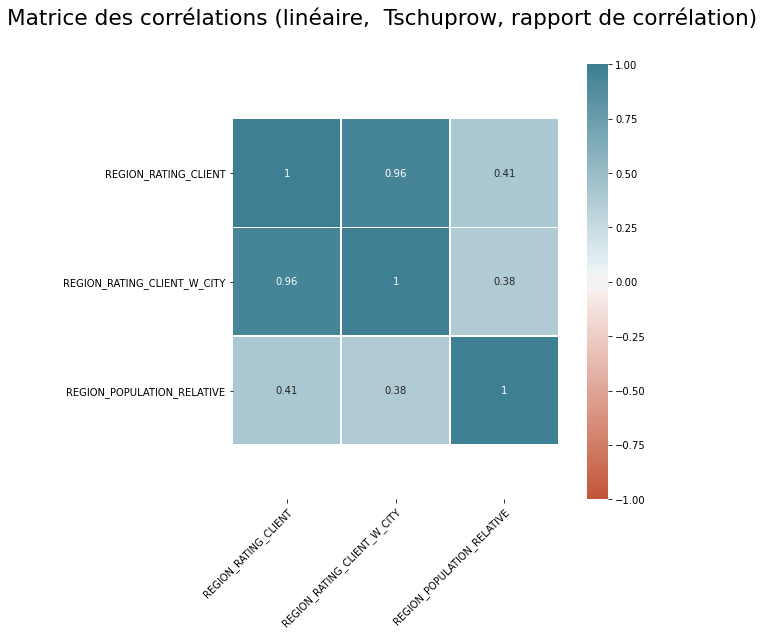

In [36]:
myDf(dfApplicationTrain).Stat(['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'REGION_POPULATION_RELATIVE'], typeStat='biv', bivOnlyCorrTable=True)

In [37]:
dfApplicationTrain[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ,'REGION_POPULATION_RELATIVE']].dtypes

REGION_RATING_CLIENT             int64
REGION_RATING_CLIENT_W_CITY      int64
REGION_POPULATION_RELATIVE     float64
dtype: object

In [38]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ,'REGION_POPULATION_RELATIVE']].isnull()).sum()

Nombre de lignes avec le champ vide:


REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
REGION_POPULATION_RELATIVE     0
dtype: int64

In [39]:
del dfApplicationTrain['REGION_RATING_CLIENT_W_CITY']
del dfApplicationTrain['REGION_POPULATION_RELATIVE']

### Gender & occupation

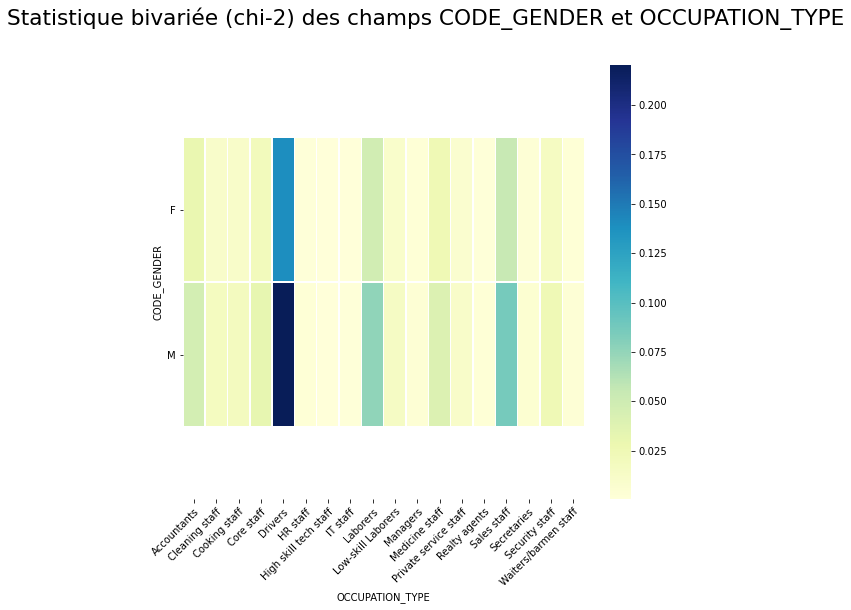

chi-2 entre CODE_GENDER et OCCUPATION_TYPE : 46282.9051368493 
phi-2 entre CODE_GENDER et OCCUPATION_TYPE : 0.3275158697721353 
coefficient T de Tschuprow entre CODE_GENDER et OCCUPATION_TYPE : 0.28184085258262875 
coefficient C de Cramer entre CODE_GENDER et OCCUPATION_TYPE : 0.5722900224293058 


In [40]:
myDf(dfApplicationTrain).Stat(['CODE_GENDER','OCCUPATION_TYPE'], typeStat='biv')

In [41]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['CODE_GENDER', 'OCCUPATION_TYPE']].isnull()).sum()

Nombre de lignes avec le champ vide:


CODE_GENDER            3
OCCUPATION_TYPE    64716
dtype: int64

### Champs Building

#### Corrélations enre les champs _MEDI ou _AVG ou _MODE

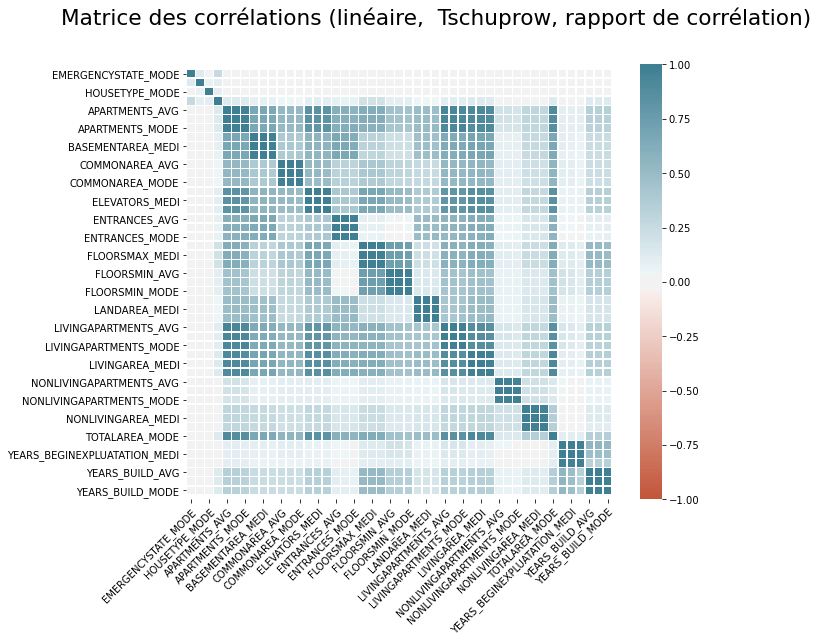

In [42]:
tmp = dfApplicationTrain[['APARTMENTS_AVG','APARTMENTS_MEDI','APARTMENTS_MODE',
                            'BASEMENTAREA_AVG','BASEMENTAREA_MEDI','BASEMENTAREA_MODE',
                            'COMMONAREA_AVG','COMMONAREA_MEDI','COMMONAREA_MODE',
                            'ELEVATORS_AVG','ELEVATORS_MEDI','ELEVATORS_MODE',
                            'EMERGENCYSTATE_MODE','ENTRANCES_AVG','ENTRANCES_MEDI','ENTRANCES_MODE',
                            'FLOORSMAX_AVG','FLOORSMAX_MEDI','FLOORSMAX_MODE','FLOORSMIN_AVG',
                            'FLOORSMIN_MEDI','FLOORSMIN_MODE',
                            'FONDKAPREMONT_MODE',
                            'HOUSETYPE_MODE',
                            'LANDAREA_AVG','LANDAREA_MEDI','LANDAREA_MODE',
                            'LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI','LIVINGAPARTMENTS_MODE',
                            'LIVINGAREA_AVG','LIVINGAREA_MEDI','LIVINGAREA_MODE',
                            'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MODE',
                            'NONLIVINGAREA_AVG','NONLIVINGAREA_MEDI','NONLIVINGAREA_MODE',
                            'TOTALAREA_MODE',
                            'WALLSMATERIAL_MODE',
                            'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BEGINEXPLUATATION_MODE',
                            'YEARS_BUILD_AVG','YEARS_BUILD_MEDI','YEARS_BUILD_MODE']]
myDf(tmp).Stat(typeStat='biv', bivOnlyCorrTable=True,  multivHeatAnnot=False)

#### Sélection des champs _MEDI ou _AVG ou _MODE

In [43]:
cols = ['APARTMENTS_MEDI',
        'BASEMENTAREA_MEDI',
        'COMMONAREA_MEDI',
        'ELEVATORS_MEDI',
        'ENTRANCES_MEDI',
        'FLOORSMAX_MEDI',
        'FLOORSMIN_MEDI',
        'LANDAREA_MEDI',
        'LIVINGAPARTMENTS_MEDI',
        'LIVINGAREA_MEDI',
        'NONLIVINGAPARTMENTS_MEDI',
        'NONLIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MEDI',
        'YEARS_BUILD_MEDI'
]
tmp = dfApplicationTrain[cols]
myDf(tmp).ColCountLines().mean()

41.646269927556325

In [44]:
cols = ['APARTMENTS_AVG',
        'BASEMENTAREA_AVG',
        'COMMONAREA_AVG',
        'ELEVATORS_AVG',
        'ENTRANCES_AVG',
        'FLOORSMAX_AVG',
        'FLOORSMIN_AVG',
        'LANDAREA_AVG',
        'LIVINGAPARTMENTS_AVG',
        'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG',
        'NONLIVINGAREA_AVG',
        'YEARS_BEGINEXPLUATATION_AVG',
        'YEARS_BUILD_AVG']
tmp = dfApplicationTrain[cols]
myDf(tmp).ColCountLines().mean()

41.646269927556325

In [45]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'EMERGENCYSTATE_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE'
]
tmp = dfApplicationTrain[cols]
myDf(tmp).ColCountLines().mean()

43.068629093896504

In [46]:
del dfApplicationTrain['APARTMENTS_AVG']
del dfApplicationTrain['APARTMENTS_MEDI']
del dfApplicationTrain['BASEMENTAREA_AVG']
del dfApplicationTrain['BASEMENTAREA_MEDI']
del dfApplicationTrain['COMMONAREA_AVG']
del dfApplicationTrain['COMMONAREA_MEDI']
del dfApplicationTrain['ELEVATORS_AVG']
del dfApplicationTrain['ELEVATORS_MEDI']
del dfApplicationTrain['ENTRANCES_AVG']
del dfApplicationTrain['ENTRANCES_MEDI']
del dfApplicationTrain['FLOORSMAX_AVG']
del dfApplicationTrain['FLOORSMAX_MEDI']
del dfApplicationTrain['FLOORSMIN_AVG']
del dfApplicationTrain['FLOORSMIN_MEDI']
del dfApplicationTrain['LANDAREA_AVG']
del dfApplicationTrain['LANDAREA_MEDI']
del dfApplicationTrain['LIVINGAPARTMENTS_AVG']
del dfApplicationTrain['LIVINGAPARTMENTS_MEDI']
del dfApplicationTrain['LIVINGAREA_AVG']
del dfApplicationTrain['LIVINGAREA_MEDI']
del dfApplicationTrain['NONLIVINGAPARTMENTS_AVG']
del dfApplicationTrain['NONLIVINGAPARTMENTS_MEDI']
del dfApplicationTrain['NONLIVINGAREA_AVG']
del dfApplicationTrain['NONLIVINGAREA_MEDI']
del dfApplicationTrain['YEARS_BEGINEXPLUATATION_AVG']
del dfApplicationTrain['YEARS_BEGINEXPLUATATION_MEDI']
del dfApplicationTrain['YEARS_BUILD_AVG']
del dfApplicationTrain['YEARS_BUILD_MEDI']

#### Suppression des champs _MODE avec trop peu de valeurs différentes

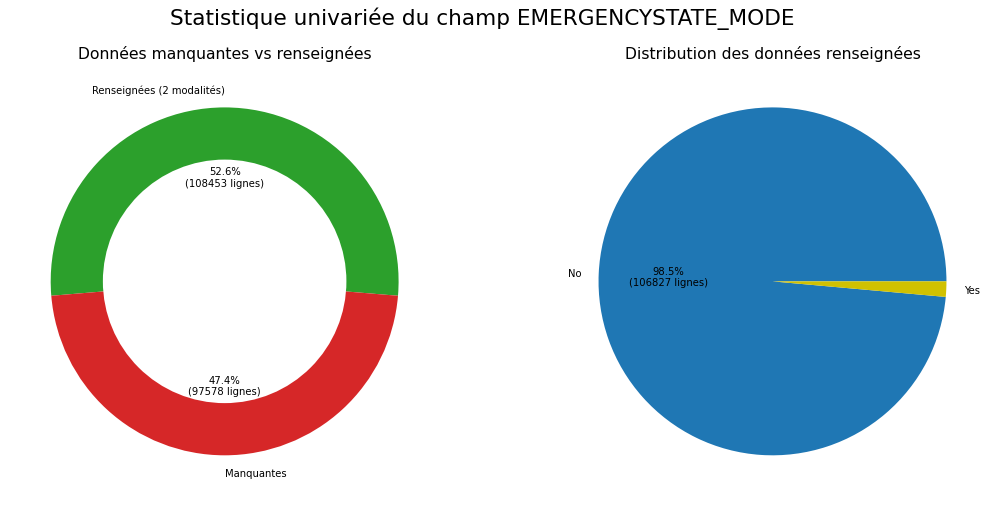

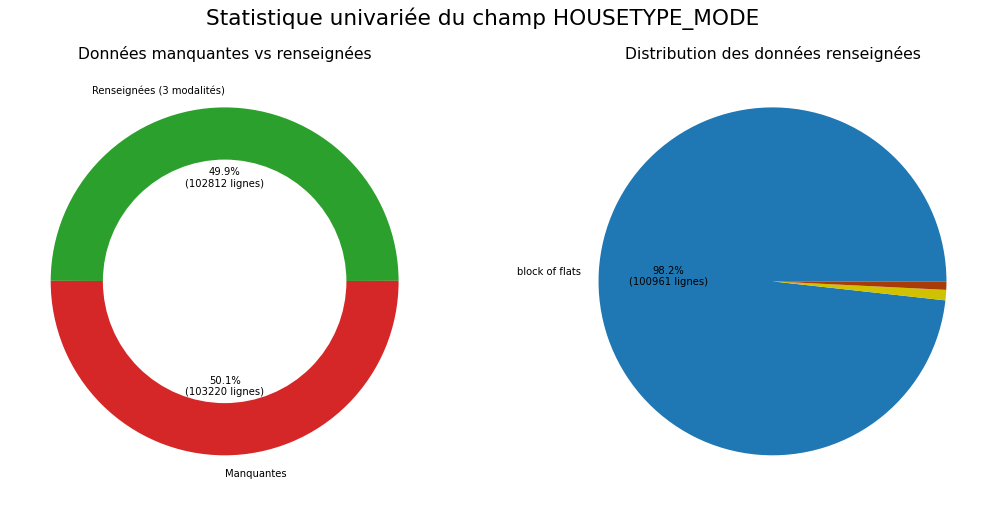

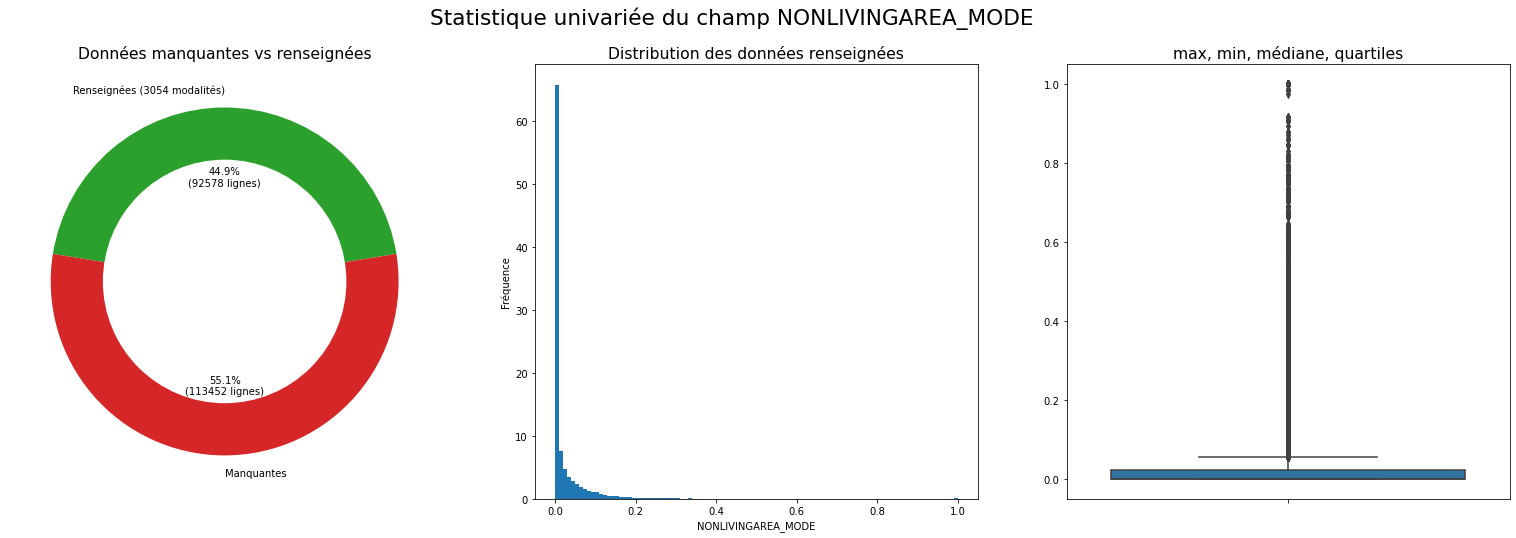

Mesures de position
 - Moyenne: 0.03
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.07
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.02
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 6.63
 - Kurtosis (applatissement): 65.03


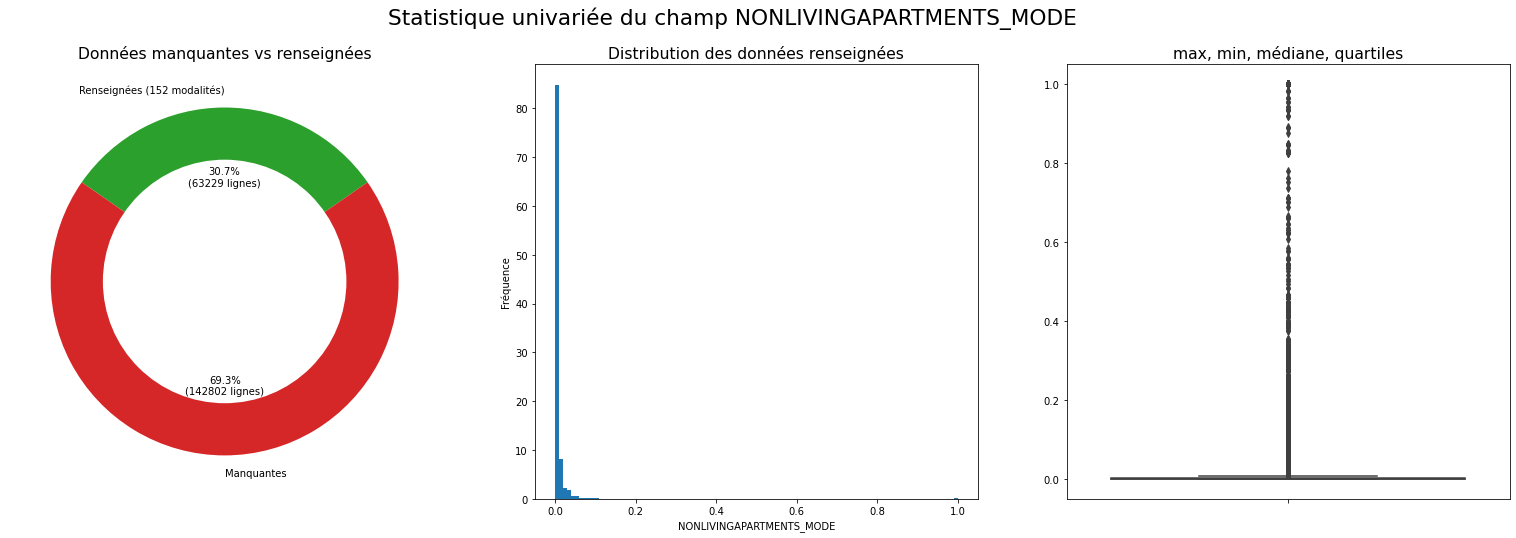

Mesures de position
 - Moyenne: 0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.05
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 15.95
 - Kurtosis (applatissement): 298.89


In [47]:
myDf(dfApplicationTrain[['EMERGENCYSTATE_MODE','HOUSETYPE_MODE','NONLIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE']]).Stat(typeStat='univ', statsNan=True)

In [48]:
del dfApplicationTrain['EMERGENCYSTATE_MODE']
del dfApplicationTrain['HOUSETYPE_MODE']
del dfApplicationTrain['NONLIVINGAREA_MODE']
del dfApplicationTrain['NONLIVINGAPARTMENTS_MODE']

#### Aperçu du taux de remplissage des champs _MODE

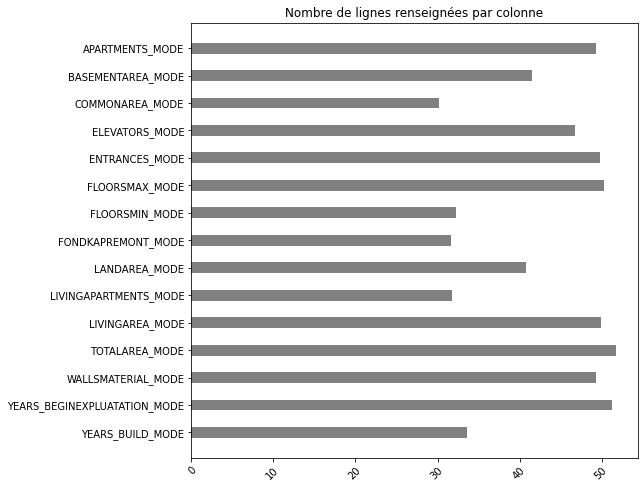

In [49]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'FONDKAPREMONT_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE'
]
myDf(dfApplicationTrain[cols]).ColCountLinesChart(typeChart='barh', displayColName=True)

#### Corrélations entre champs _MODE

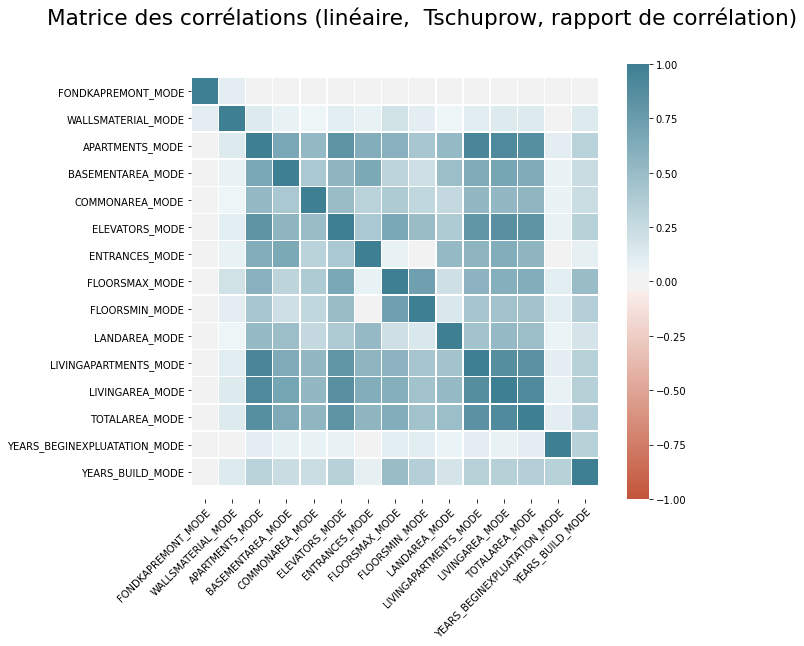

In [50]:
myDf(dfApplicationTrain[cols]).Stat(typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=False)

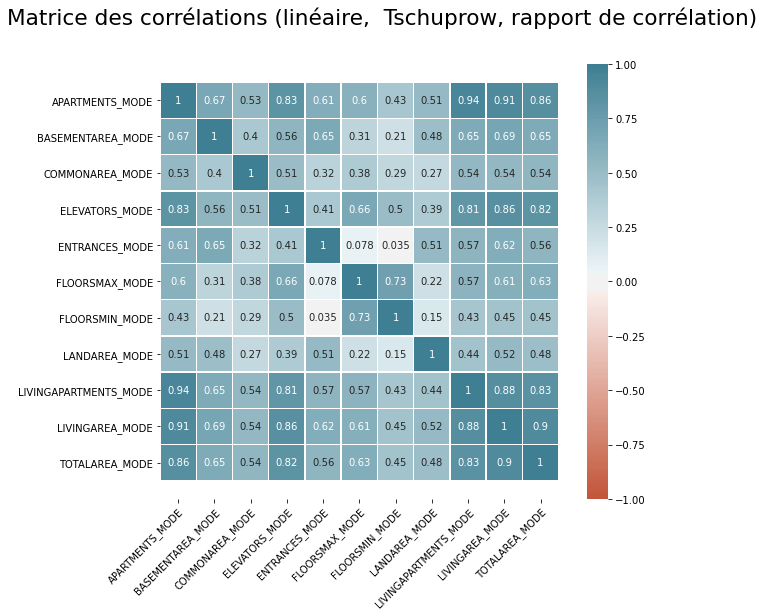

In [51]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'TOTALAREA_MODE'
]
myDf(dfApplicationTrain[cols]).Stat(typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=True)

In [52]:
del dfApplicationTrain['BASEMENTAREA_MODE']
del dfApplicationTrain['COMMONAREA_MODE']
del dfApplicationTrain['ELEVATORS_MODE']
del dfApplicationTrain['ENTRANCES_MODE']
del dfApplicationTrain['FLOORSMAX_MODE']
del dfApplicationTrain['FLOORSMIN_MODE']
del dfApplicationTrain['LANDAREA_MODE']
del dfApplicationTrain['LIVINGAPARTMENTS_MODE']
del dfApplicationTrain['LIVINGAREA_MODE']
del dfApplicationTrain['TOTALAREA_MODE']

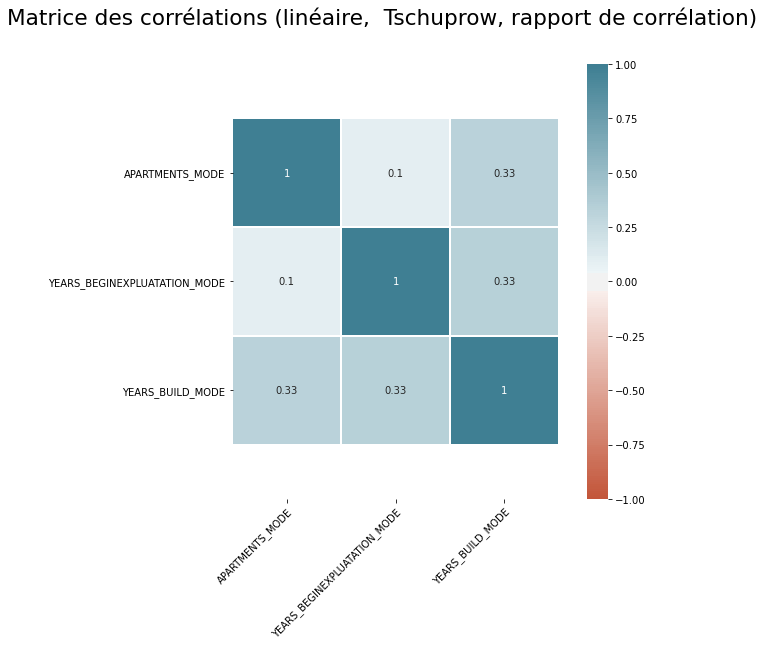

In [53]:
myDf(dfApplicationTrain).Stat(['APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE'],typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=True)

In [54]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE']].isnull()).sum()

Nombre de lignes avec le champ vide:


APARTMENTS_MODE                 104401
YEARS_BEGINEXPLUATATION_MODE    100377
YEARS_BUILD_MODE                136822
dtype: int64

In [55]:
del dfApplicationTrain['YEARS_BUILD_MODE']

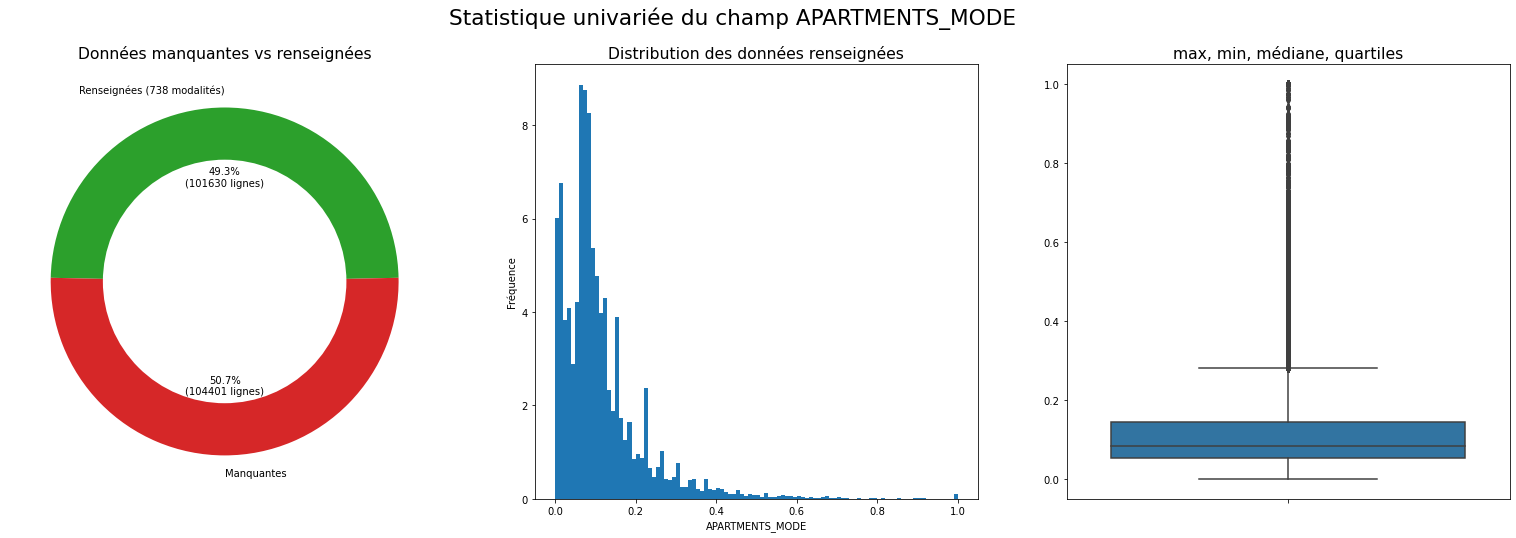

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.08
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.14
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.71
 - Kurtosis (applatissement): 11.78


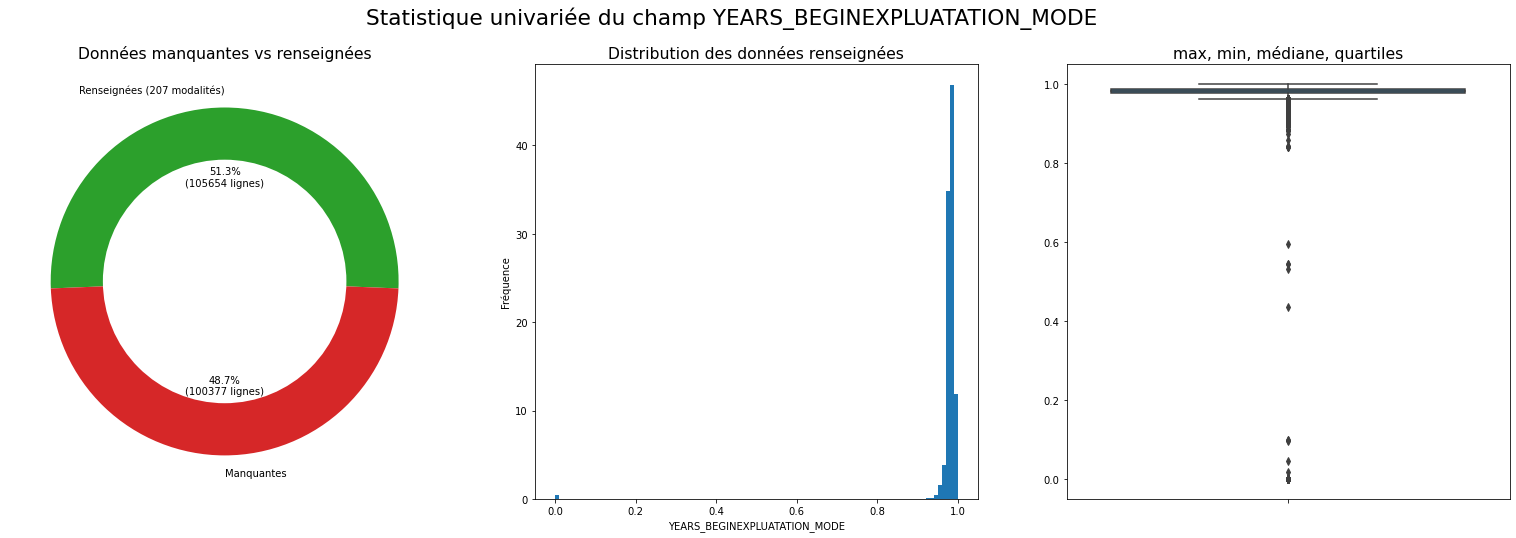

Mesures de position
 - Moyenne: 0.98
 - Médiane: 0.98
Mesures de dispertion
 - Ecart type: 0.06
 - Min: 0.0
 - Q25: 0.98
 - Q75: 0.99
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -15.05
 - Kurtosis (applatissement): 229.26


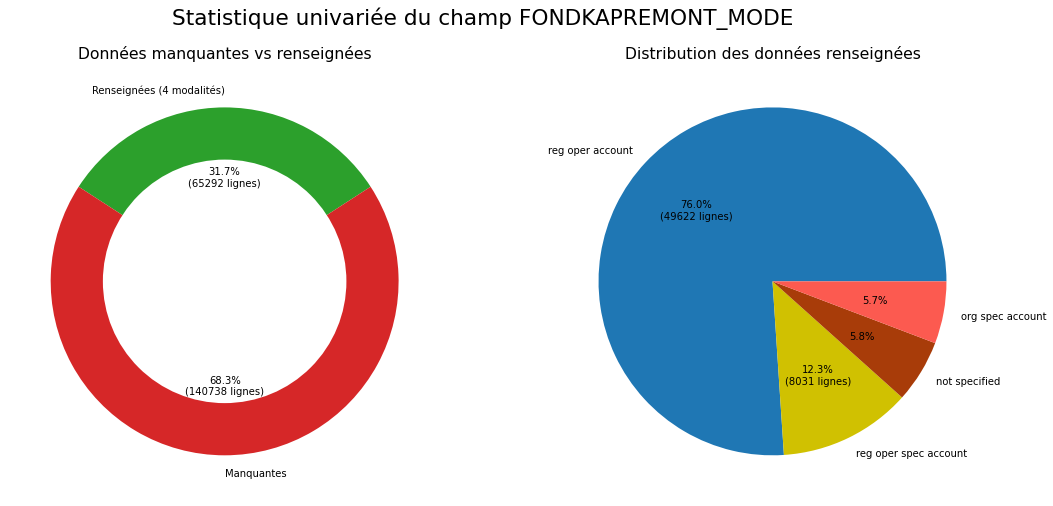

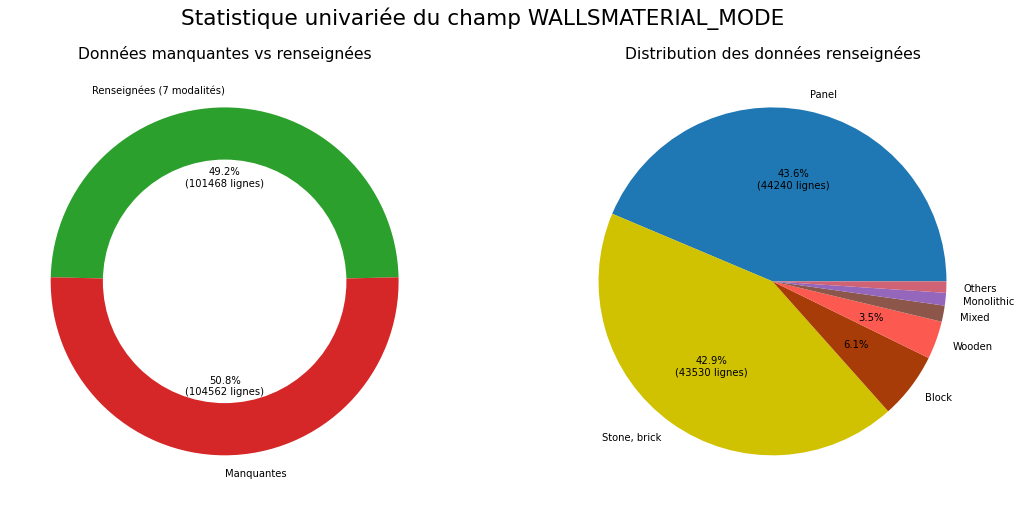

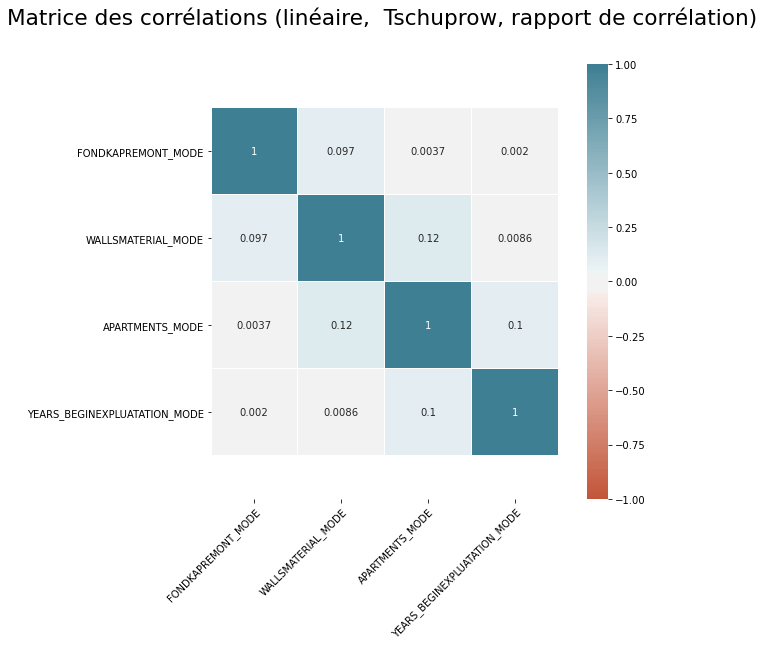

In [56]:
cols = ['APARTMENTS_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'FONDKAPREMONT_MODE',
'WALLSMATERIAL_MODE'
]
myDf(dfApplicationTrain[cols]).Stat(typeStat='univ-biv', statsNan=True, bivOnlyCorrTable=True, multivHeatAnnot=True)

In [57]:
del dfApplicationTrain['FONDKAPREMONT_MODE']

### Matrice des corrélations des variables restantes

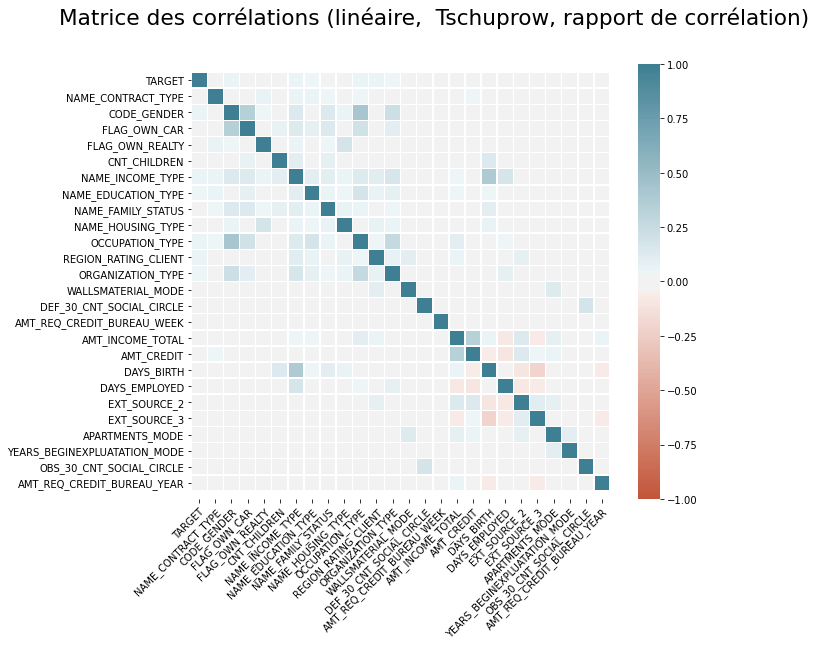

In [58]:
myDf(dfApplicationTrain).Stat(exclCol=['SK_ID_CURR'], typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=False)

## Statistique univariée

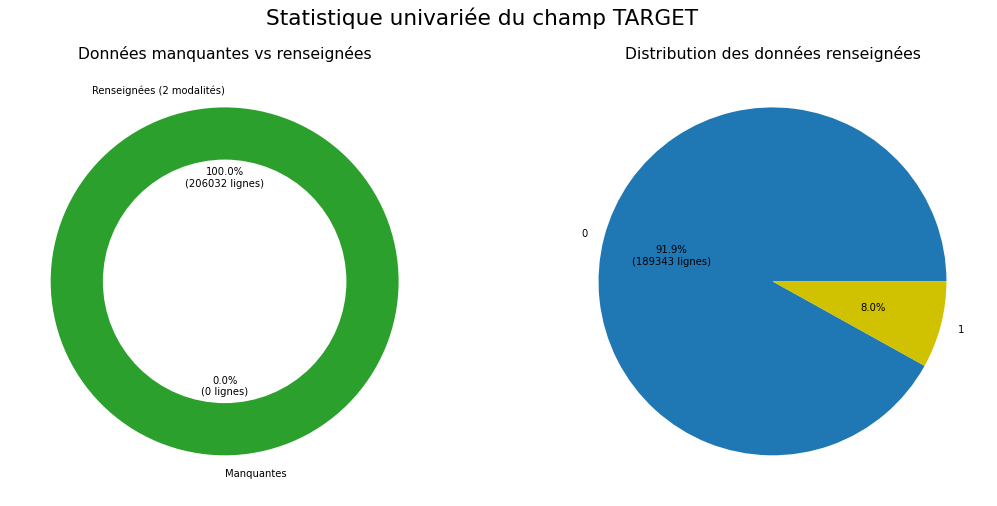

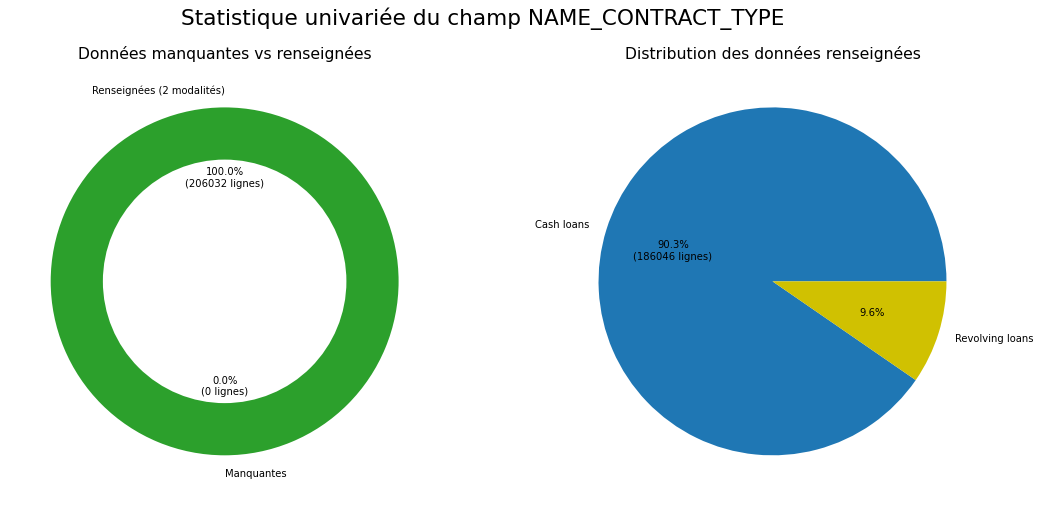

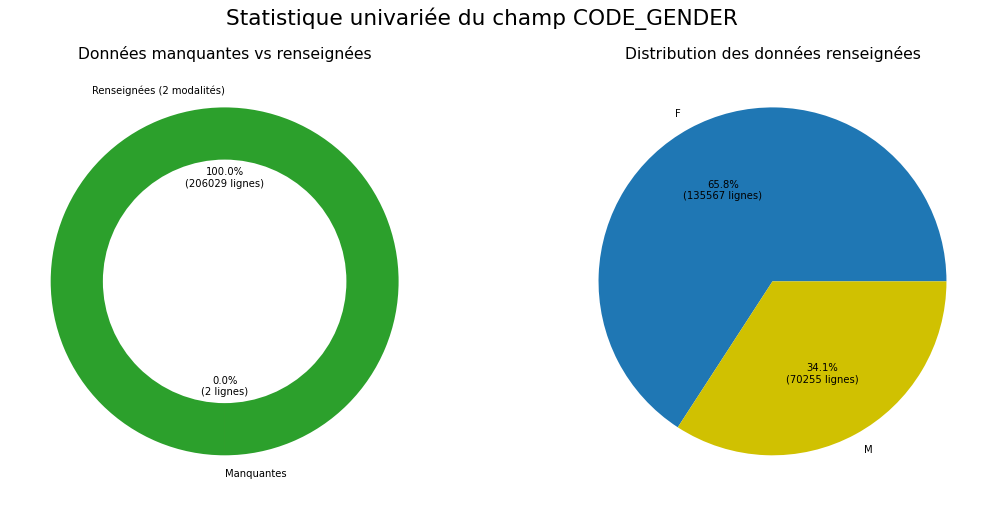

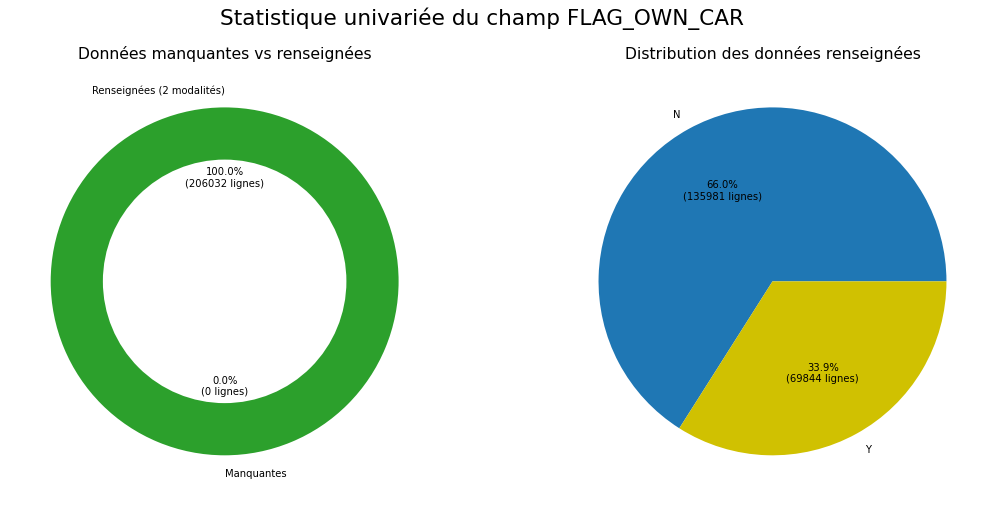

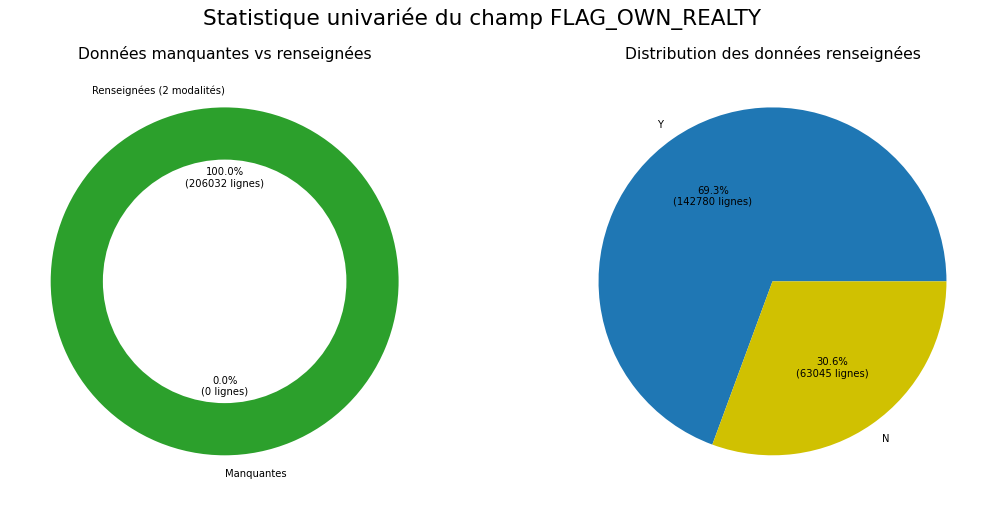

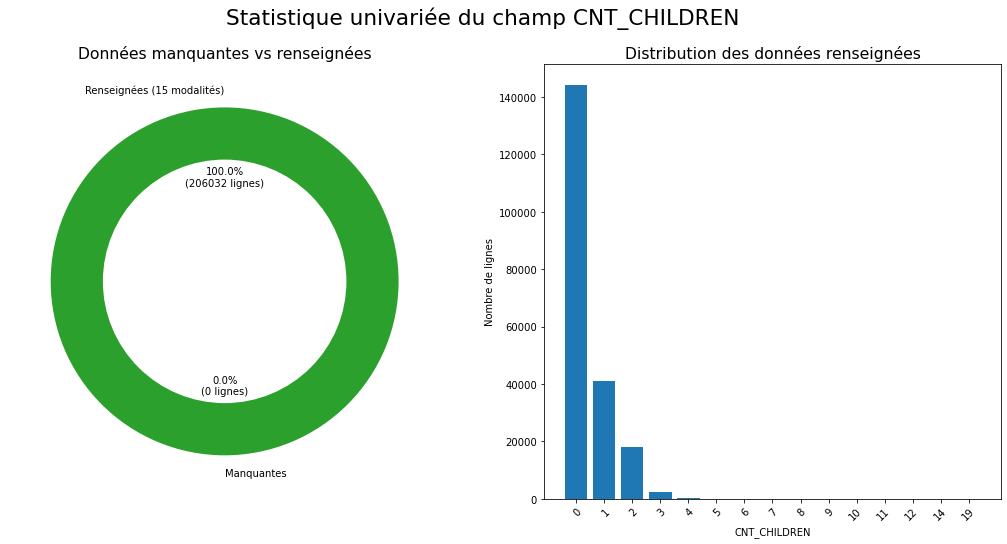

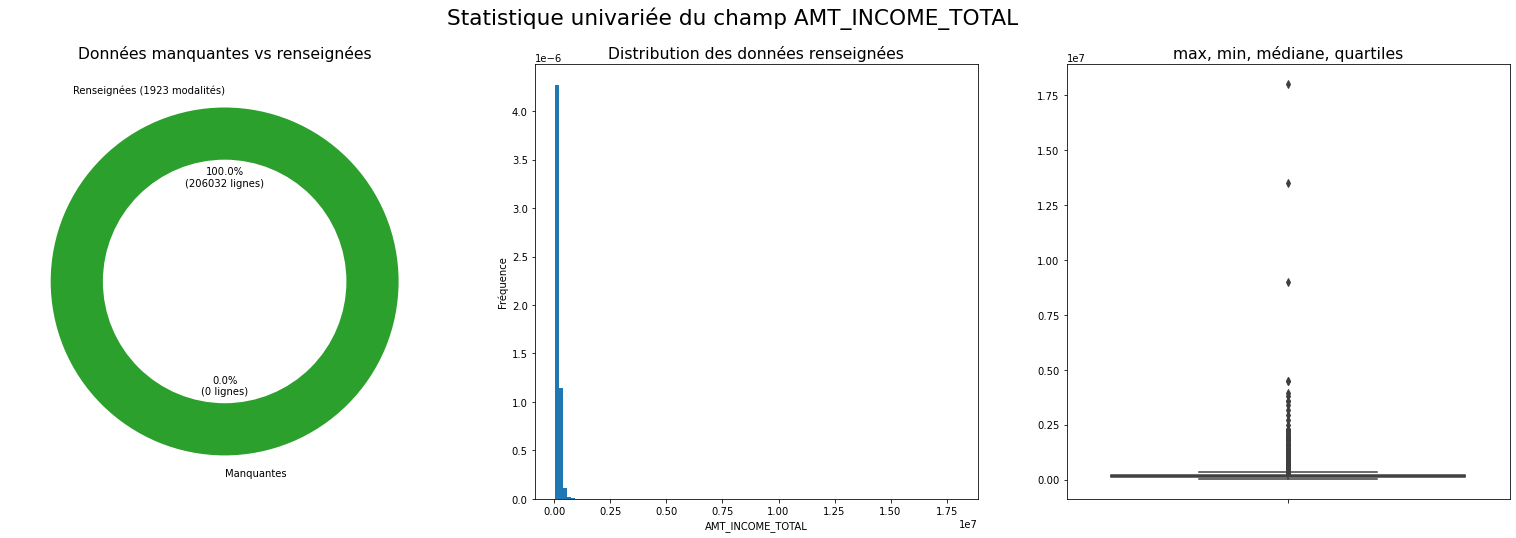

Mesures de position
 - Moyenne: 168417.97
 - Médiane: 145350.0
Mesures de dispertion
 - Ecart type: 112336.29
 - Min: 25650.0
 - Q25: 112500.0
 - Q75: 202500.0
 - Max: 18000090.0
Mesures de forme
 - Skewness (asymétrie): 33.71
 - Kurtosis (applatissement): 4298.96


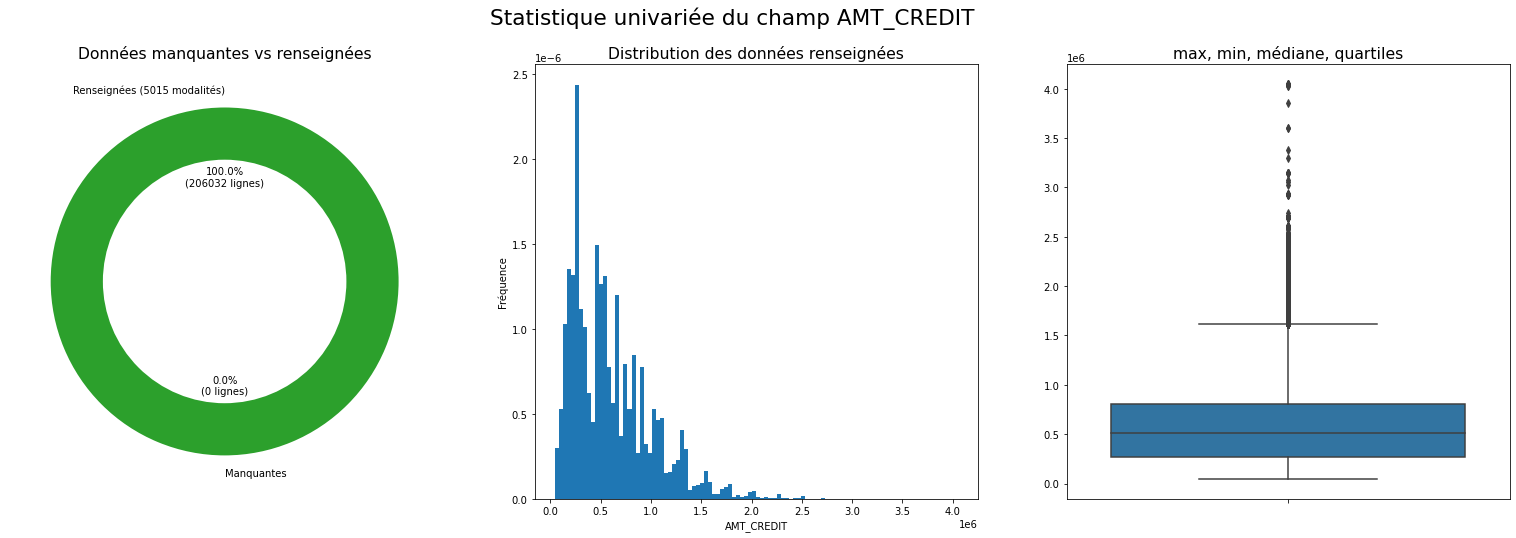

Mesures de position
 - Moyenne: 598810.95
 - Médiane: 513040.5
Mesures de dispertion
 - Ecart type: 402474.88
 - Min: 45000.0
 - Q25: 270000.0
 - Q75: 808650.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.23
 - Kurtosis (applatissement): 1.93


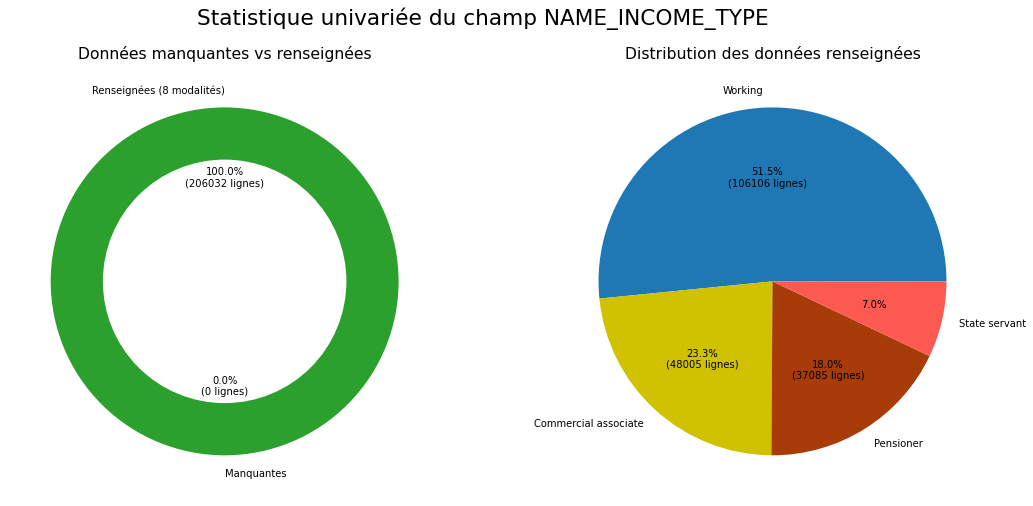

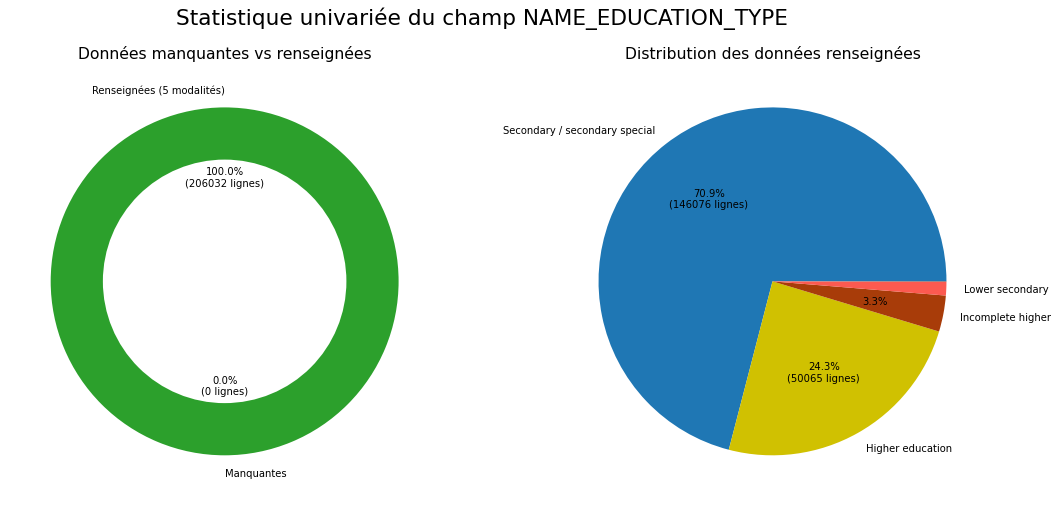

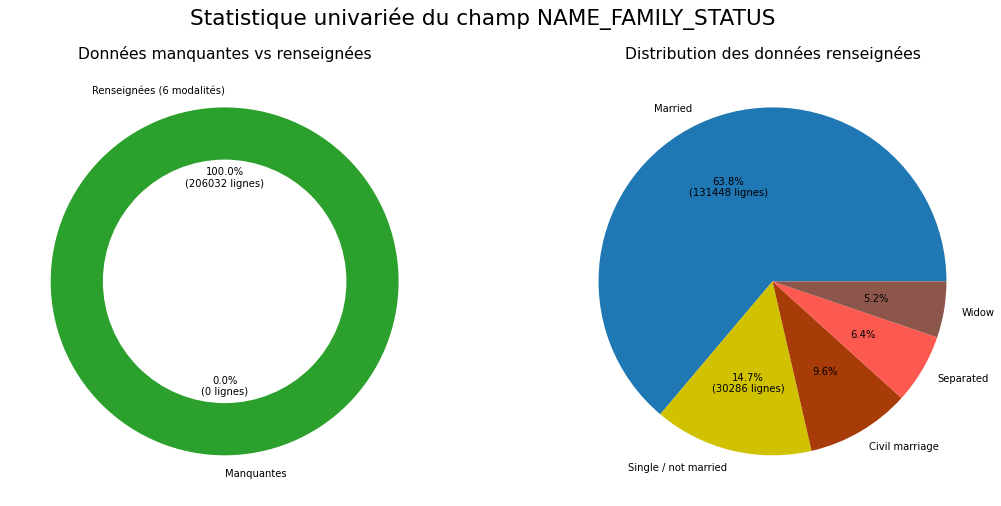

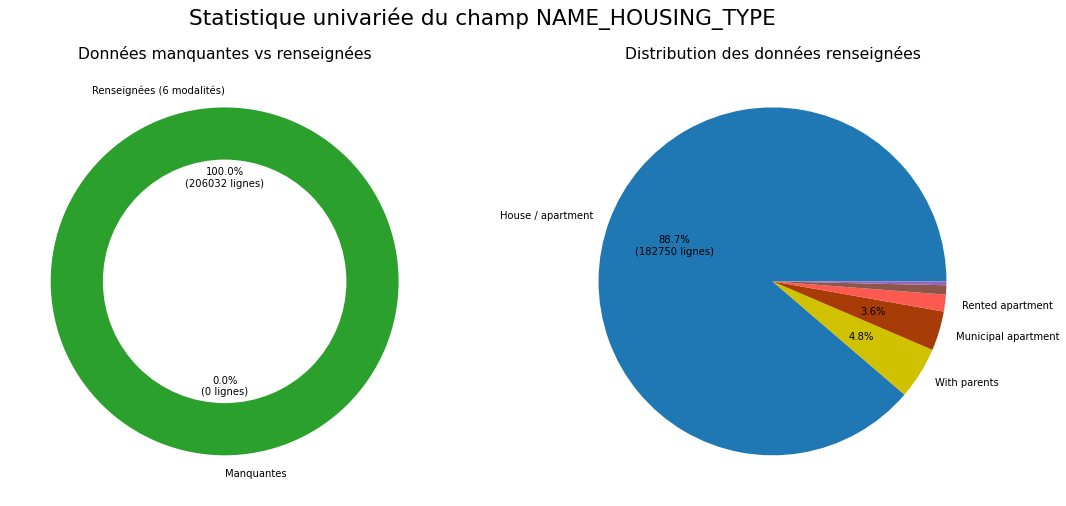

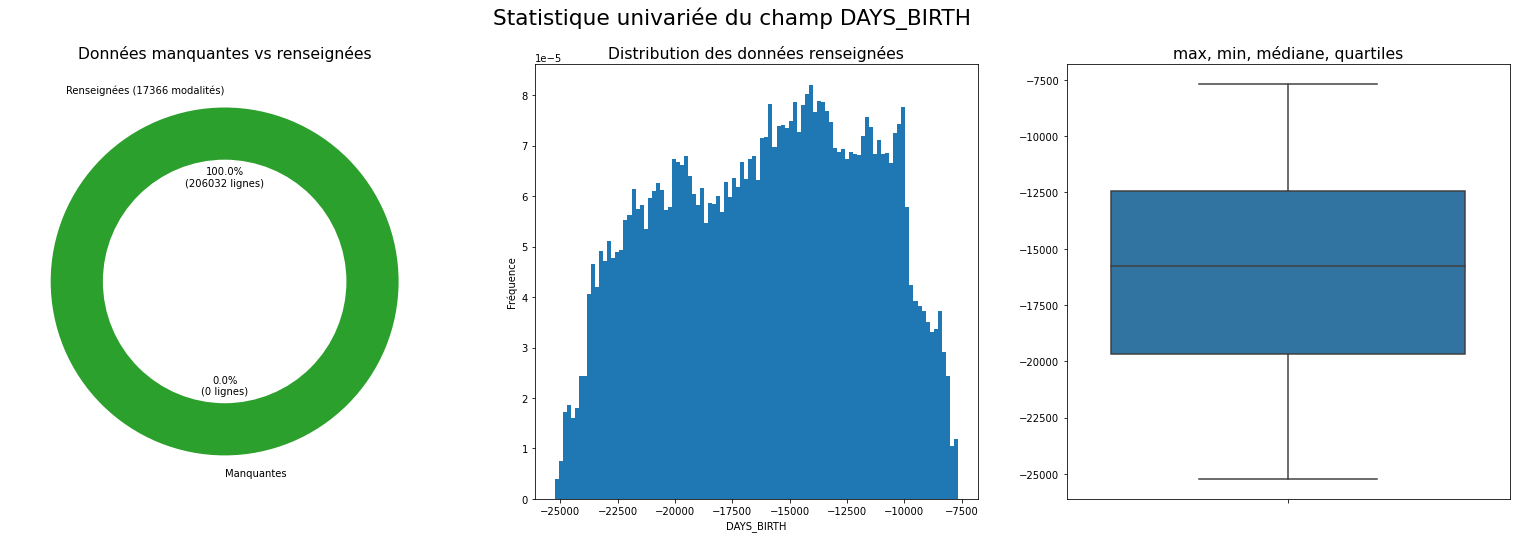

Mesures de position
 - Moyenne: -16039.89
 - Médiane: -15760.0
Mesures de dispertion
 - Ecart type: 4368.18
 - Min: -25229
 - Q25: -19692.0
 - Q75: -12414.0
 - Max: -7673
Mesures de forme
 - Skewness (asymétrie): -0.11
 - Kurtosis (applatissement): -1.05


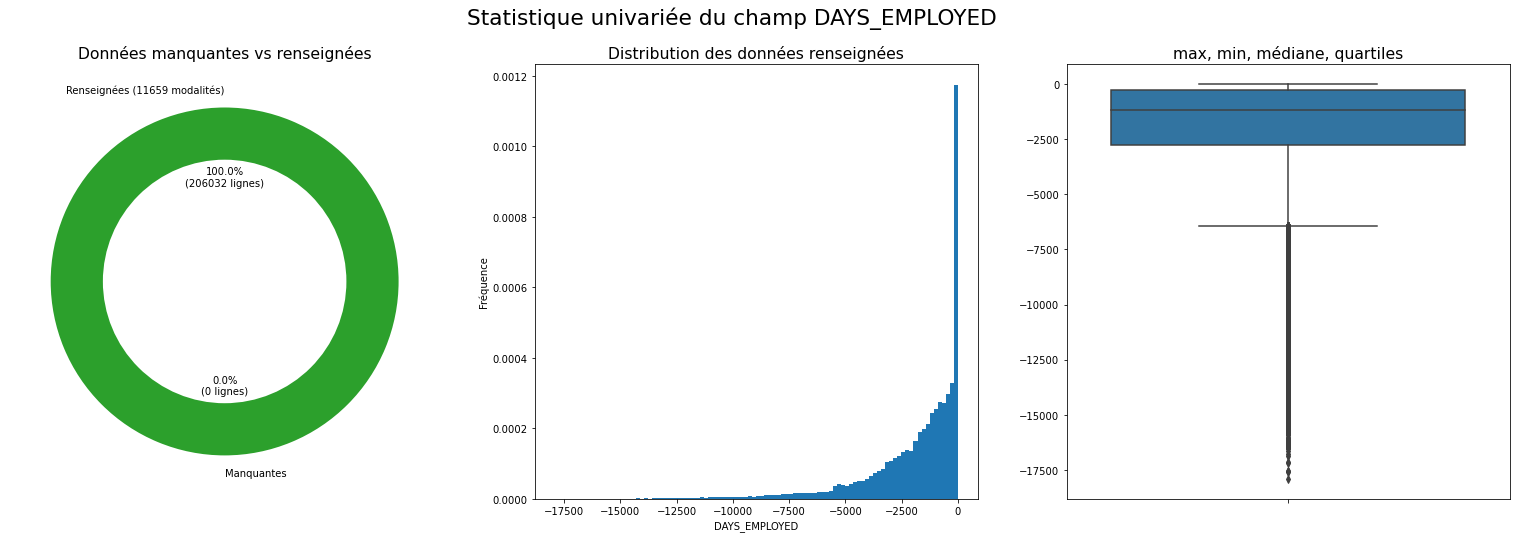

Mesures de position
 - Moyenne: -1950.6
 - Médiane: -1209.0
Mesures de dispertion
 - Ecart type: 2304.47
 - Min: -17912
 - Q25: -2755.0
 - Q75: -288.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.05
 - Kurtosis (applatissement): 5.24


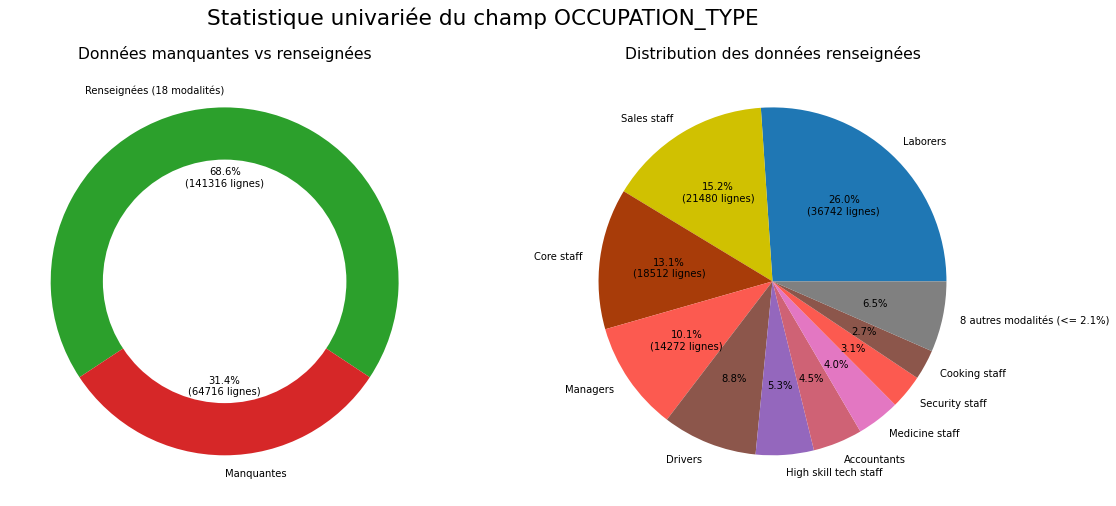

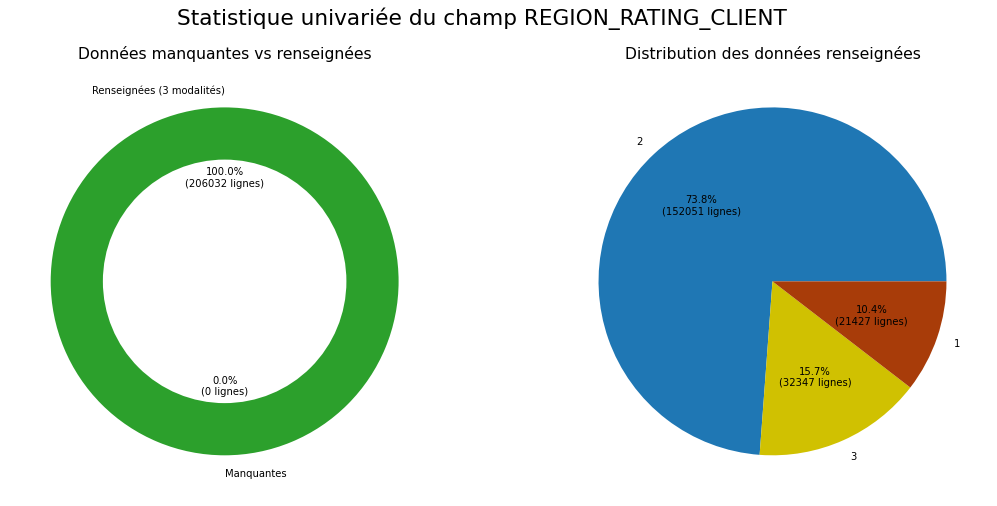

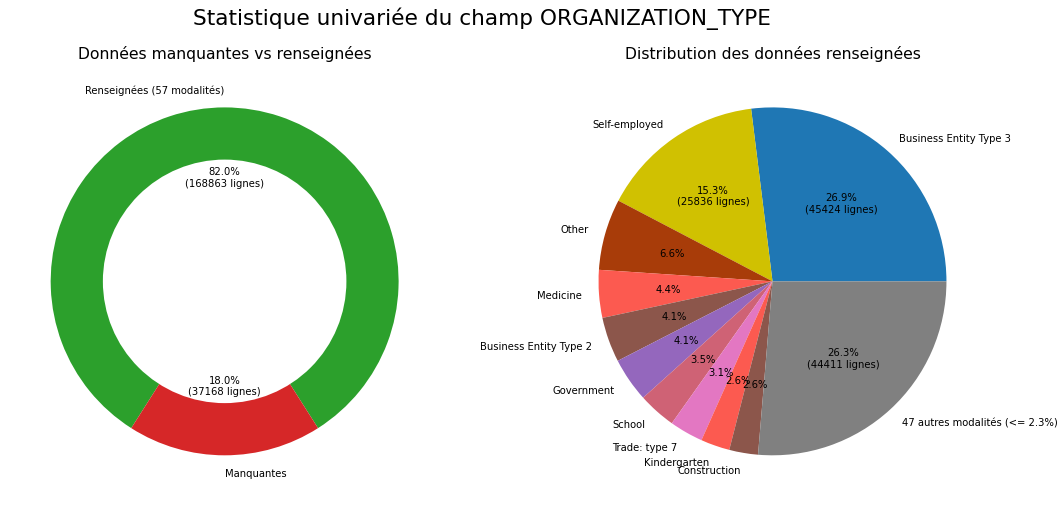

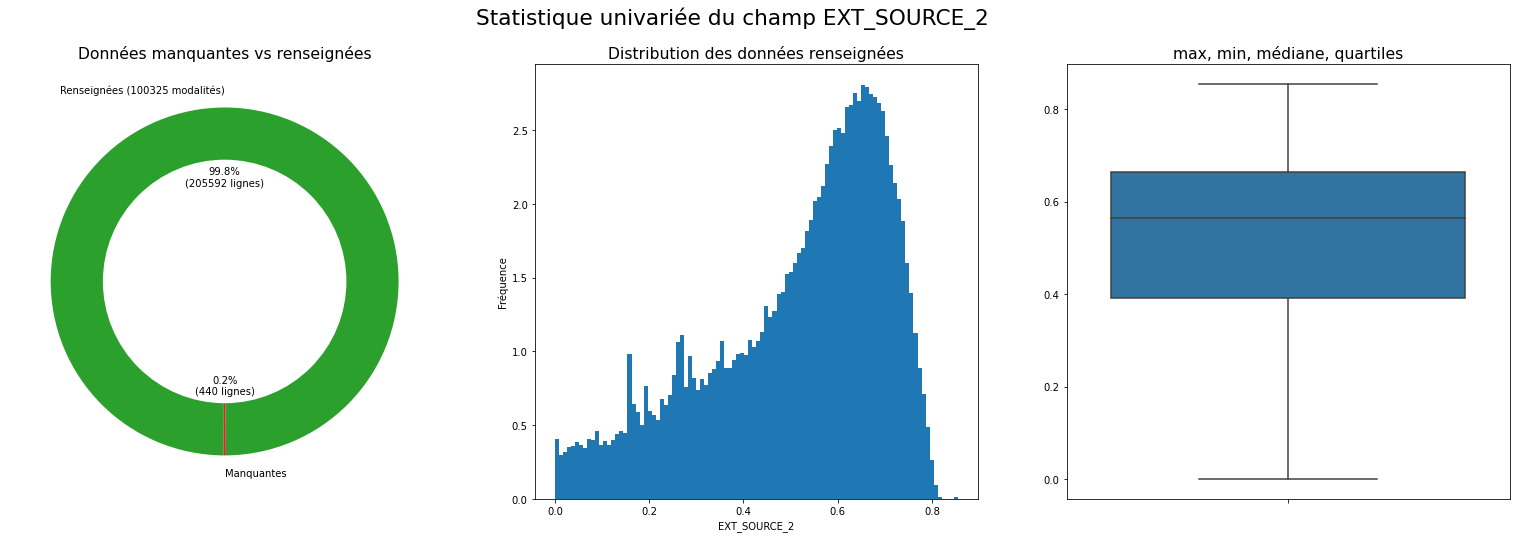

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.57
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.39
 - Q75: 0.66
 - Max: 0.85
Mesures de forme
 - Skewness (asymétrie): -0.79
 - Kurtosis (applatissement): -0.28


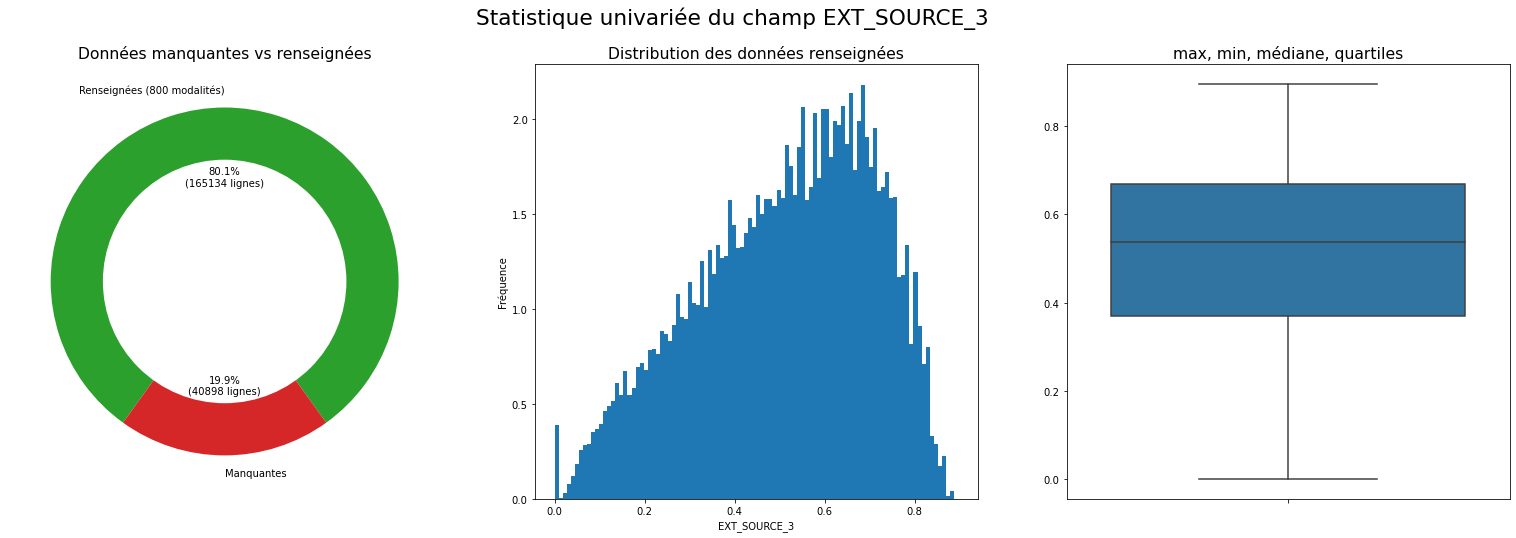

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.54
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.37
 - Q75: 0.67
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.66


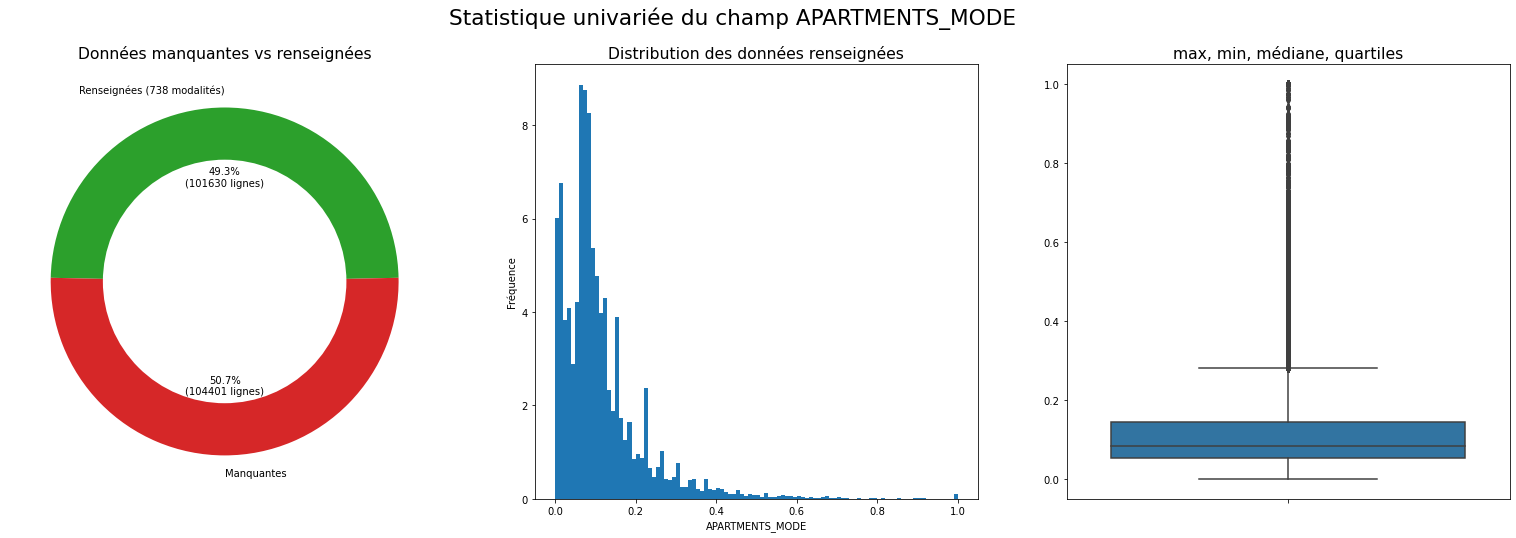

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.08
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.14
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.71
 - Kurtosis (applatissement): 11.78


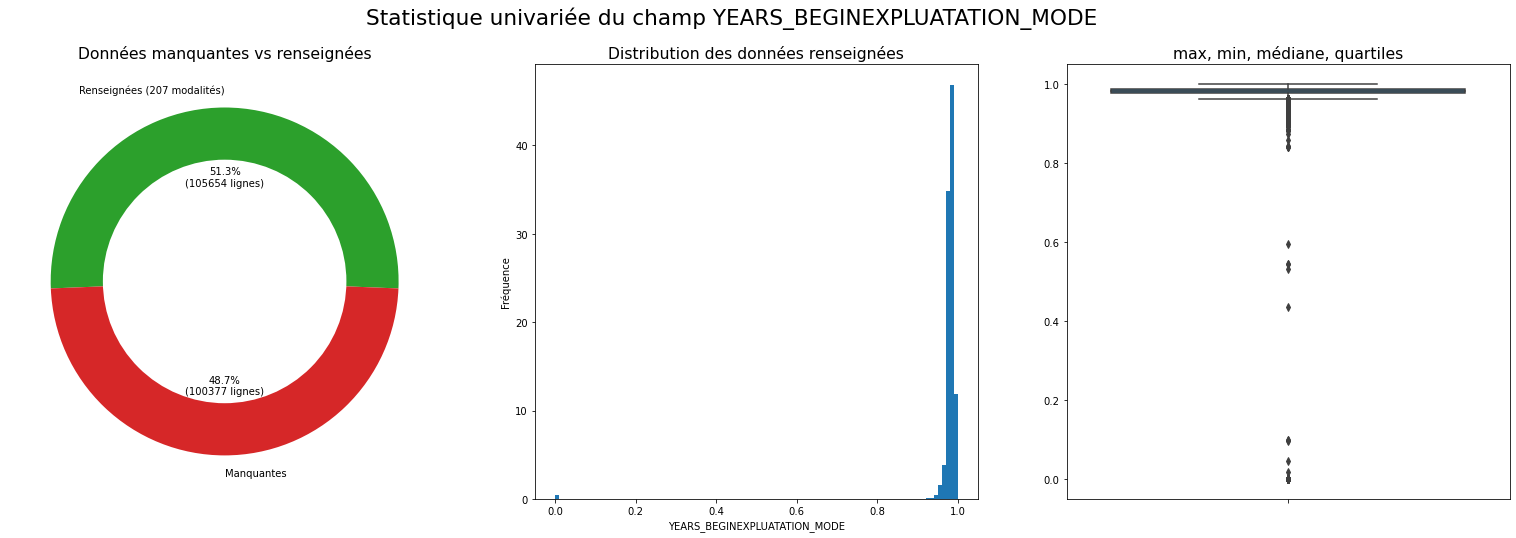

Mesures de position
 - Moyenne: 0.98
 - Médiane: 0.98
Mesures de dispertion
 - Ecart type: 0.06
 - Min: 0.0
 - Q25: 0.98
 - Q75: 0.99
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -15.05
 - Kurtosis (applatissement): 229.26


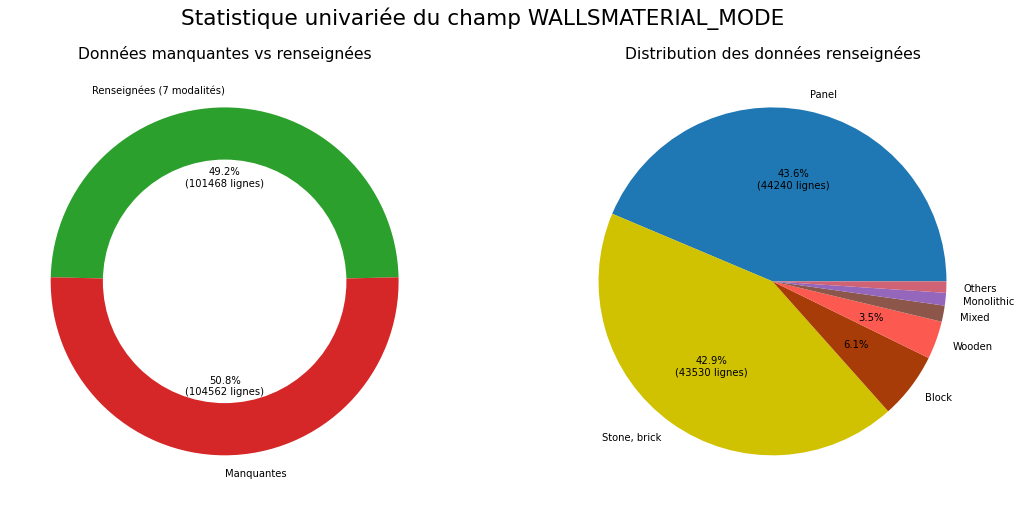

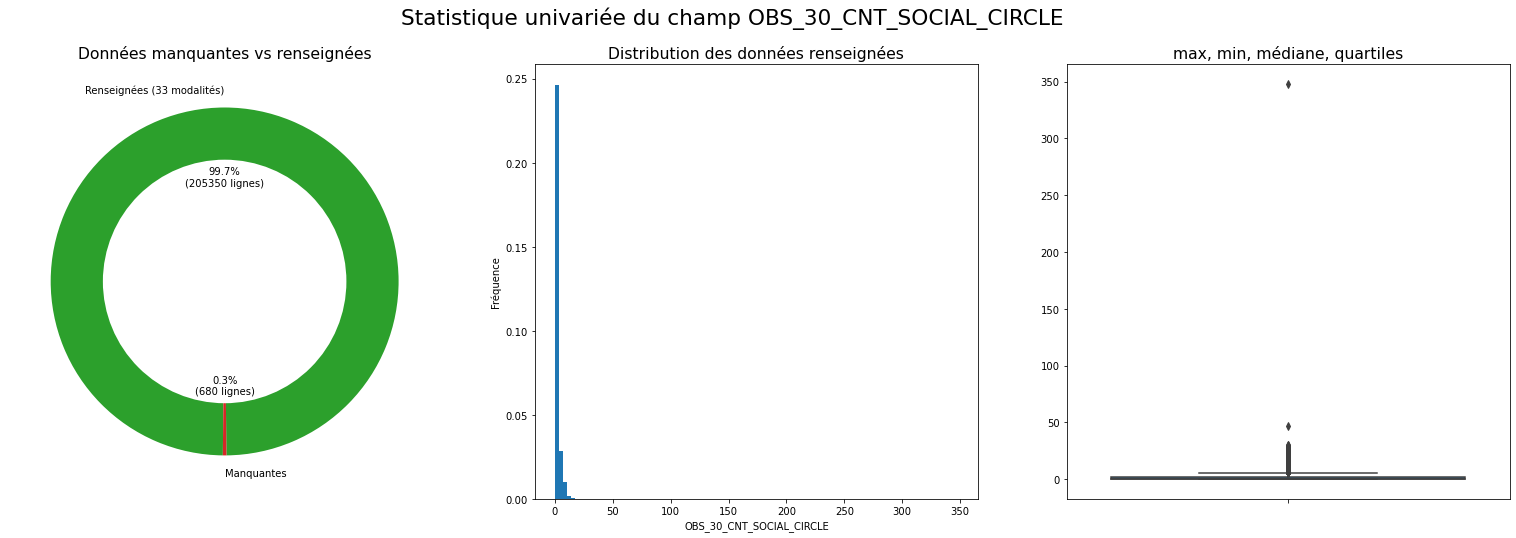

Mesures de position
 - Moyenne: 1.42
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 2.44
 - Min: 0.0
 - Q25: 0.0
 - Q75: 2.0
 - Max: 348.0
Mesures de forme
 - Skewness (asymétrie): 16.21
 - Kurtosis (applatissement): 1997.43


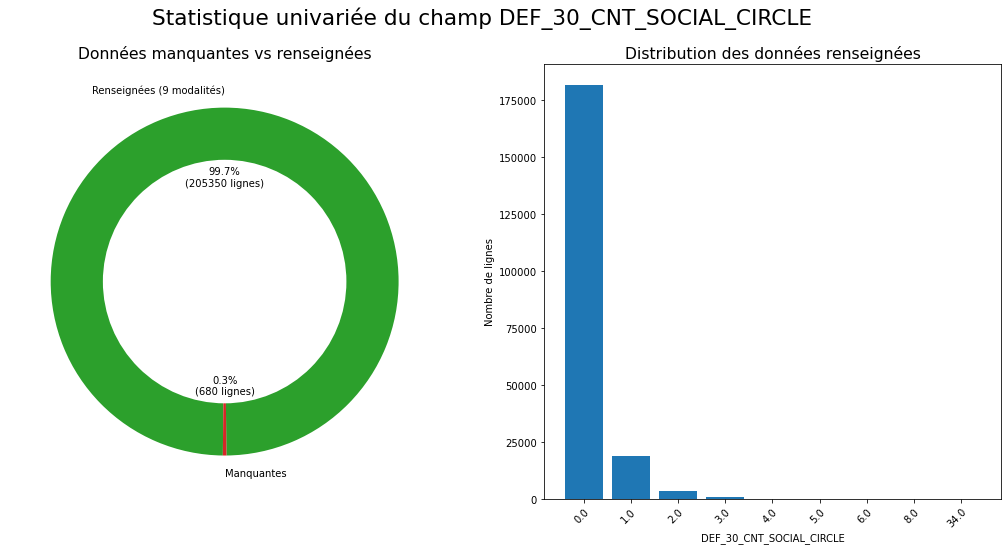

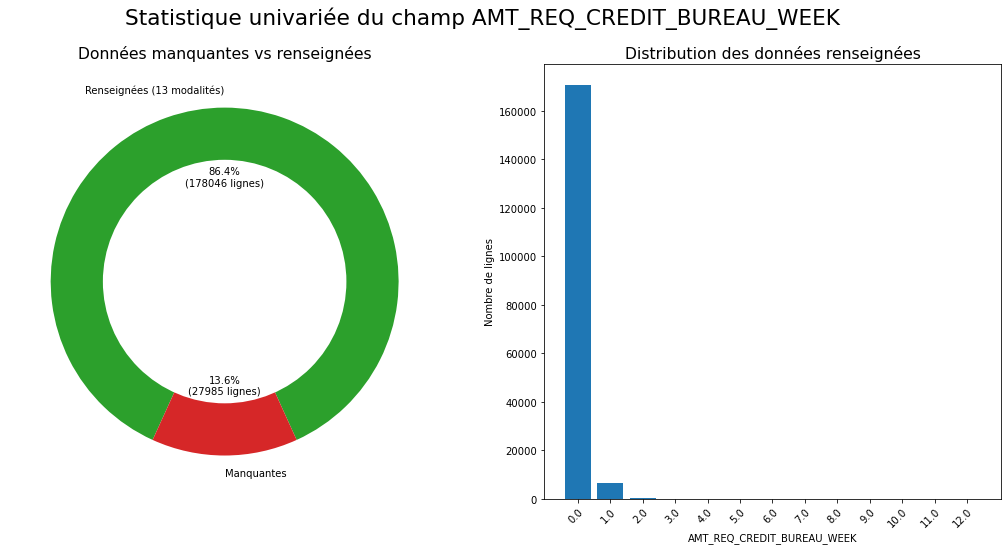

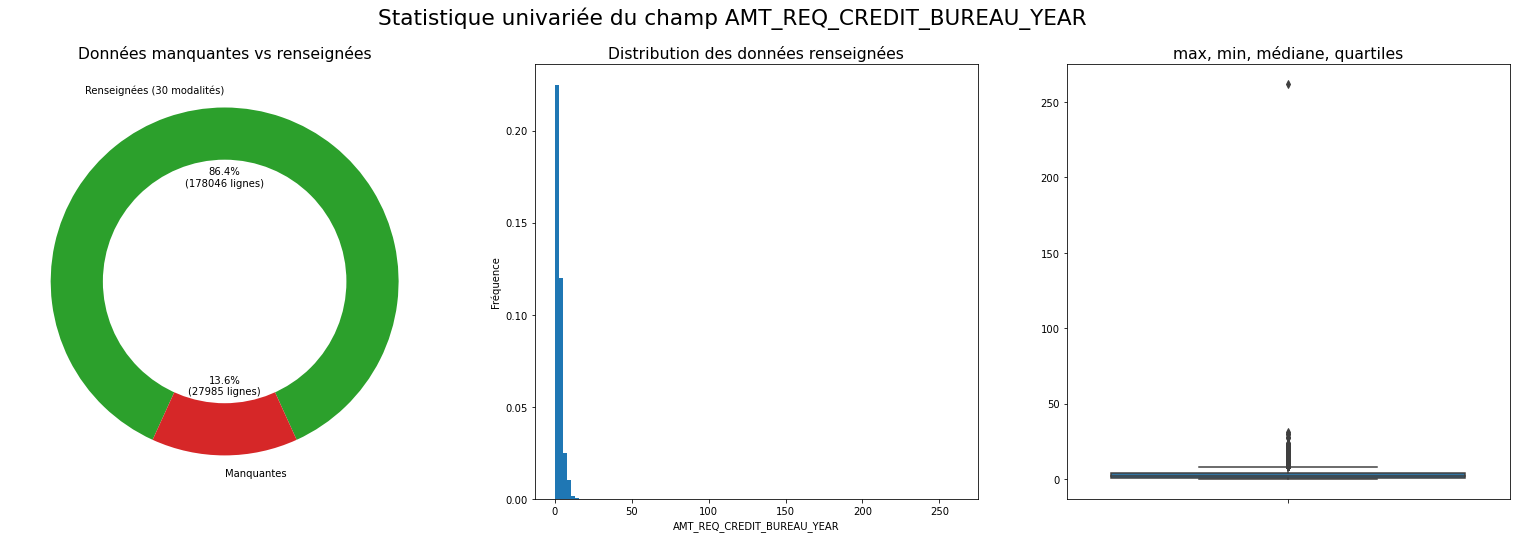

Mesures de position
 - Moyenne: 2.47
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 2.31
 - Min: 0.0
 - Q25: 1.0
 - Q75: 4.0
 - Max: 262.0
Mesures de forme
 - Skewness (asymétrie): 9.21
 - Kurtosis (applatissement): 894.15


In [59]:
myDf(dfApplicationTrain).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_CURR'])

## Gestion des outliers

In [60]:
dfApplicationTrain['AMT_INCOME_TOTAL'] = dfApplicationTrain.apply(lambda x: np.log(x.AMT_INCOME_TOTAL), axis=1)

In [61]:
dfApplicationTrain = dfApplicationTrain[(dfApplicationTrain.AMT_REQ_CREDIT_BUREAU_YEAR < 50) | dfApplicationTrain.AMT_REQ_CREDIT_BUREAU_YEAR.isnull()]
dfApplicationTrain = dfApplicationTrain[(dfApplicationTrain.OBS_30_CNT_SOCIAL_CIRCLE < 50) | dfApplicationTrain.OBS_30_CNT_SOCIAL_CIRCLE.isnull()]

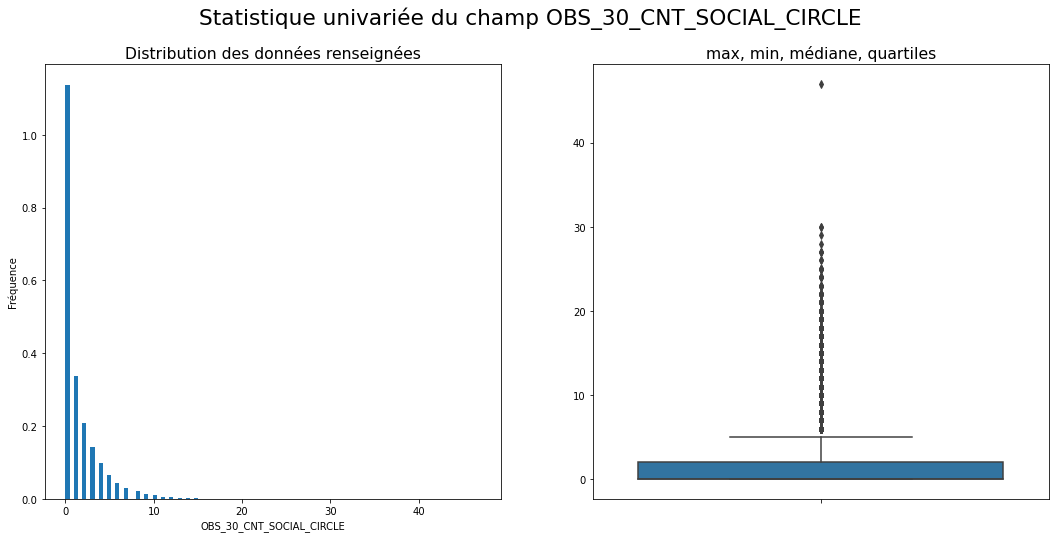

Mesures de position
 - Moyenne: 1.42
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 2.31
 - Min: 0.0
 - Q25: 0.0
 - Q75: 2.0
 - Max: 47.0
Mesures de forme
 - Skewness (asymétrie): 2.59
 - Kurtosis (applatissement): 10.17


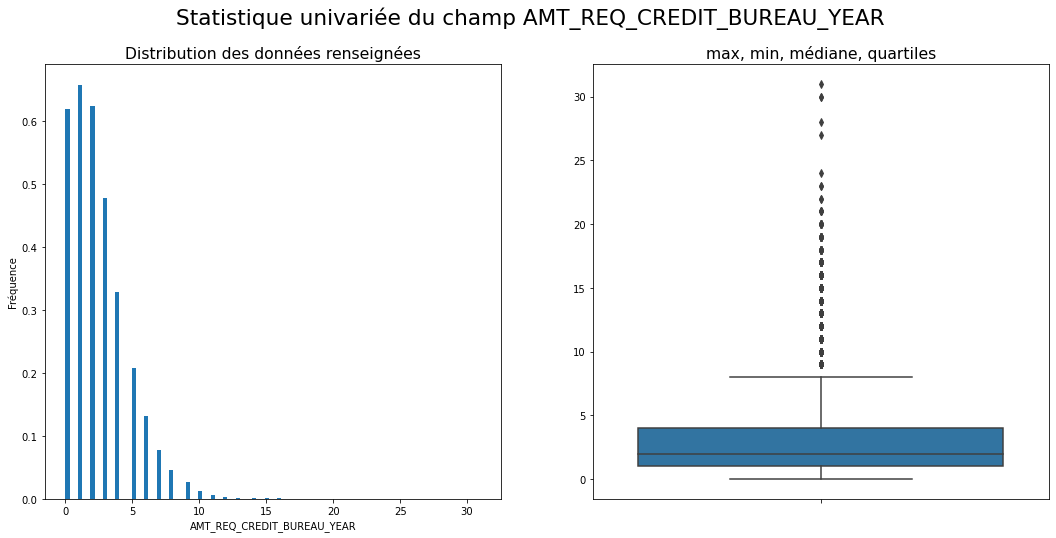

Mesures de position
 - Moyenne: 2.47
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 2.23
 - Min: 0.0
 - Q25: 1.0
 - Q75: 4.0
 - Max: 31.0
Mesures de forme
 - Skewness (asymétrie): 1.41
 - Kurtosis (applatissement): 3.82


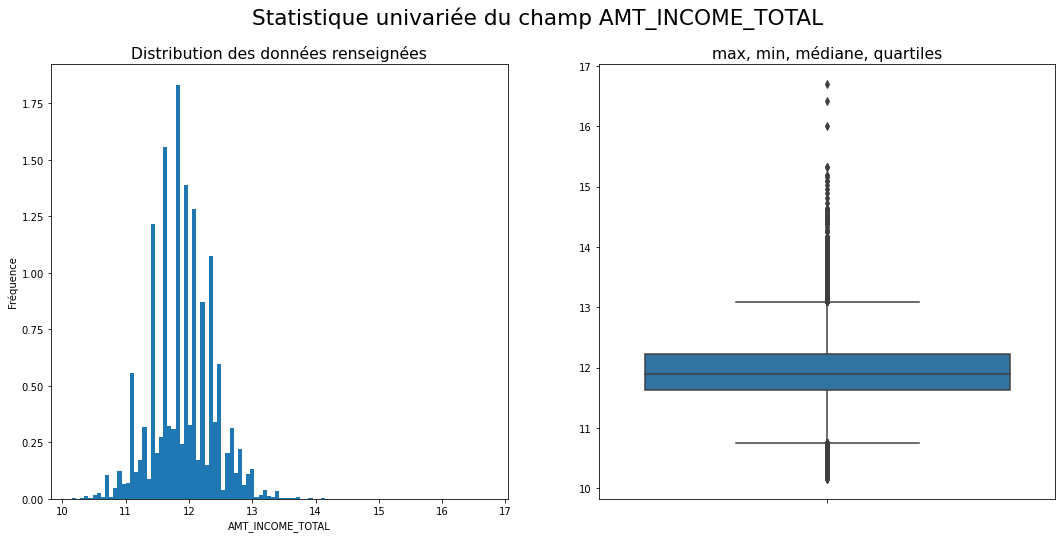

Mesures de position
 - Moyenne: 11.91
 - Médiane: 11.89
Mesures de dispertion
 - Ecart type: 0.49
 - Min: 10.15
 - Q25: 11.63
 - Q75: 12.22
 - Max: 16.71
Mesures de forme
 - Skewness (asymétrie): 0.17
 - Kurtosis (applatissement): 0.67


In [62]:
myDf(dfApplicationTrain).Stat(['OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_INCOME_TOTAL'], typeStat='univ')

## Encoding des variables catégorielles

In [63]:
categorical_ix = dfApplicationTrain.select_dtypes(include=['object', 'bool']).columns
dfApplicationTrain[categorical_ix] = dfApplicationTrain[categorical_ix].replace(np.nan, 'missing')

In [64]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
dfApplicationTrain['NAME_CONTRACT_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['NAME_CONTRACT_TYPE']])
dfApplicationTrain['CODE_GENDER'] = ordinal_encoder.fit_transform(dfApplicationTrain[['CODE_GENDER']])
dfApplicationTrain['FLAG_OWN_CAR'] = ordinal_encoder.fit_transform(dfApplicationTrain[['FLAG_OWN_CAR']])
dfApplicationTrain['FLAG_OWN_REALTY'] = ordinal_encoder.fit_transform(dfApplicationTrain[['FLAG_OWN_REALTY']])
dfApplicationTrain['NAME_INCOME_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['NAME_INCOME_TYPE']])
dfApplicationTrain['NAME_HOUSING_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['NAME_HOUSING_TYPE']])
dfApplicationTrain['OCCUPATION_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['OCCUPATION_TYPE']])
dfApplicationTrain['WALLSMATERIAL_MODE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['WALLSMATERIAL_MODE']])

In [65]:
dfApplicationTrain['NAME_EDUCATION_TYPE_ENCODED'] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Academic degree'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Higher education'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 2
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Incomplete higher'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 3
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Secondary / secondary special'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 4
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Lower secondary'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 5

In [66]:
dfApplicationTrain['MARRIED_FLAG'] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1

### Conservation des variables numériques uniquement

In [67]:
col_type = dfApplicationTrain.dtypes
col_type = col_type[(col_type == 'int64') | (col_type == 'uint8') | (col_type == 'float64')]
dfApplicationTrain = dfApplicationTrain[col_type.index]

# Exploration de PreviousApplication

In [68]:
dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)

## Suppression de lignes non pertinentes

In [69]:
dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]

In [70]:
dfPreviousApplication.NAME_CONTRACT_STATUS.value_counts()

Approved        1036044
Canceled         316317
Refused          282169
Unused offer      26423
Name: NAME_CONTRACT_STATUS, dtype: int64

In [71]:
dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]

In [72]:
dfPreviousApplication = dfPreviousApplication.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

## Suppression de variables non pertinentes

In [73]:
del dfPreviousApplication['NAME_TYPE_SUITE'] # Who accompanied client when applying for the previous application

## Statistiques par current application

In [74]:
nbWithPrevious = dfApplicationTrain[dfApplicationTrain.SK_ID_CURR.isin(dfPreviousApplication.SK_ID_CURR)].shape[0]
nbWithoutPrevious = dfApplicationTrain[~dfApplicationTrain.SK_ID_CURR.isin(dfPreviousApplication.SK_ID_CURR)].shape[0]
print("{} loans sans previous ({}%)".format(nbWithoutPrevious, np.round(100 * nbWithoutPrevious / (nbWithPrevious + nbWithoutPrevious), 1)))

11307 loans sans previous (5.5%)


Text(0.5, 1.0, 'Stat nb previous application at credit bureau')

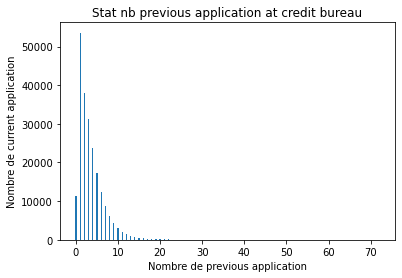

In [75]:
distrib_nb_previous = dfApplicationTrain.merge(dfPreviousApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')['SK_ID_CURR'].value_counts().value_counts()
distrib_nb_previous[0] = nbWithoutPrevious
tmp = pd.DataFrame({'nb_previous': pd.Series(distrib_nb_previous.index),
                   'nb_application': distrib_nb_previous.reset_index(drop=True)}).sort_values('nb_previous')
plt.bar(pd.Series(distrib_nb_previous.index), distrib_nb_previous.reset_index(drop=True), width=0.3)
plt.xlabel('Nombre de previous application')
plt.ylabel('Nombre de current application')
plt.title("Stat nb previous application at credit bureau")

## Suppression de variables non pertinentes

### Appliquées en filtre

In [ ]:
del dfPreviousApplication['FLAG_LAST_APPL_PER_CONTRACT']
del dfPreviousApplication['NFLAG_LAST_APPL_IN_DAY']

### Fonctionnellement inintéressantes

In [78]:
del dfPreviousApplication['WEEKDAY_APPR_PROCESS_START'] #On which day of the week did the client apply for the loan
del dfPreviousApplication['HOUR_APPR_PROCESS_START'] #Approximately at what hour did the client apply for the loan
del dfPreviousApplication['NAME_CLIENT_TYPE'] #Was the client old or new client when applying for the previous application
del dfPreviousApplication['SELLERPLACE_AREA'] #Selling area of seller place of the previous application

### Trop de valeurs manquantes

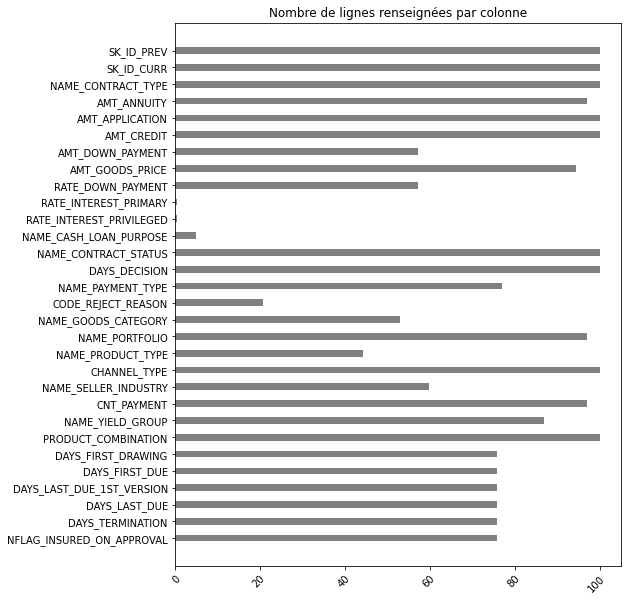

In [79]:
myDf(dfPreviousApplication).ColCountLinesChart(typeChart='barh', displayColName=True)

In [80]:
del dfPreviousApplication['RATE_INTEREST_PRIMARY']
del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']

### Trop de valeurs identiques

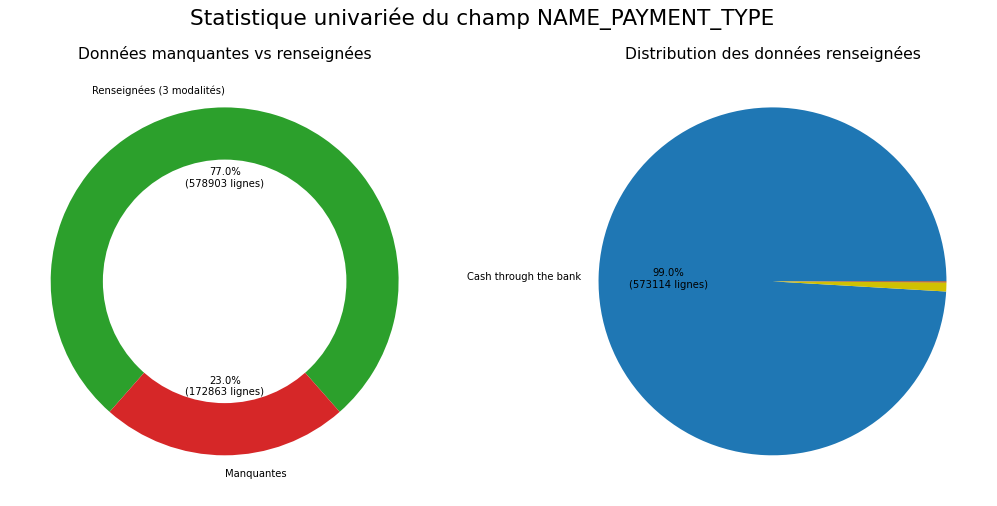

In [81]:
myDf(dfPreviousApplication).Stat(['NAME_PAYMENT_TYPE'],typeStat='univ', statsNan=True)

In [82]:
del dfPreviousApplication['NAME_PAYMENT_TYPE']

## Recherche de corrélations

### Champs days

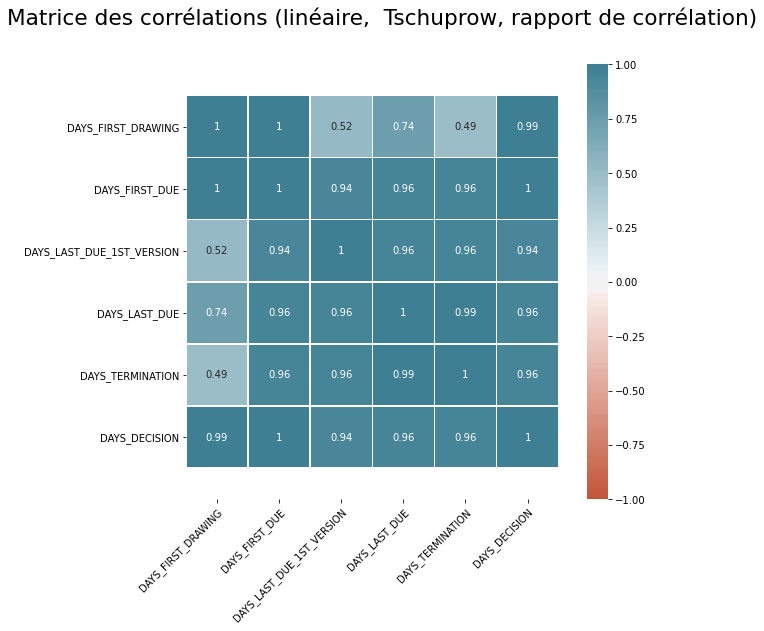

In [83]:
myDf(dfPreviousApplication.replace(365243,np.nan)).Stat(['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION','DAYS_DECISION'], bivOnlyCorrTable=True, typeStat='biv')

In [84]:
del dfPreviousApplication['DAYS_FIRST_DRAWING']
del dfPreviousApplication['DAYS_FIRST_DUE']
del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
del dfPreviousApplication['DAYS_LAST_DUE']
del dfPreviousApplication['DAYS_TERMINATION']

### Montants

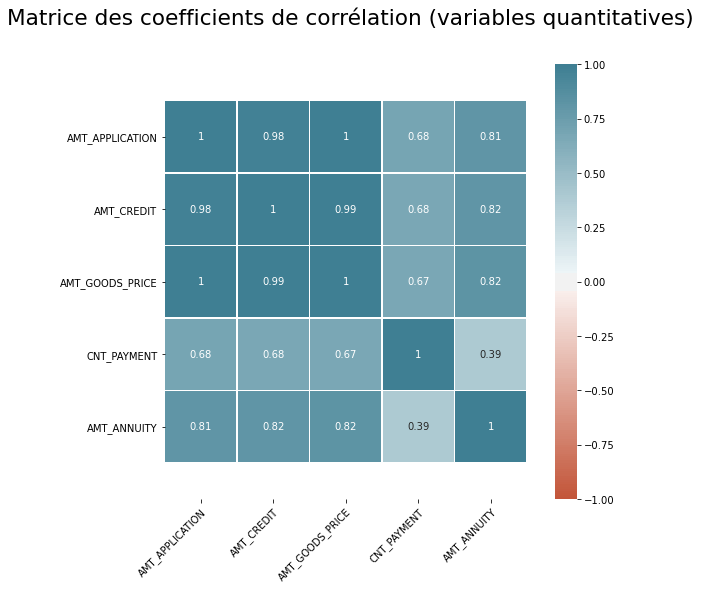

In [85]:
myDf(dfPreviousApplication).Stat(['AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','CNT_PAYMENT','AMT_ANNUITY'], typeStat='biv', bivThresholdCorr=2) 

In [86]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','CNT_PAYMENT','AMT_ANNUITY']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_APPLICATION        0
AMT_CREDIT             1
AMT_GOODS_PRICE    43154
CNT_PAYMENT        23065
AMT_ANNUITY        23065
dtype: int64

In [87]:
del dfPreviousApplication['AMT_APPLICATION']
del dfPreviousApplication['AMT_GOODS_PRICE']
del dfPreviousApplication['AMT_ANNUITY']
del dfPreviousApplication['CNT_PAYMENT']

### Contract type portfolio name

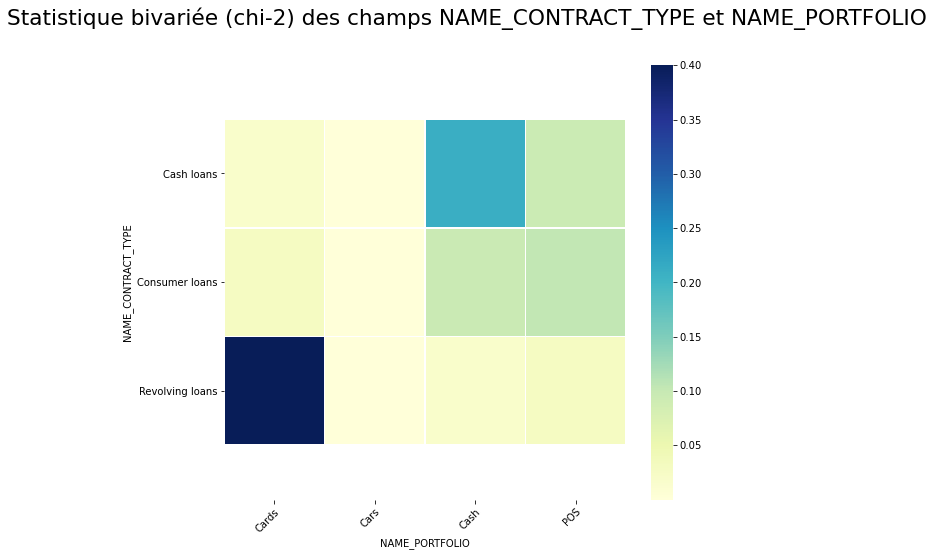

chi-2 entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 1457404.0 
phi-2 entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 2.0 
coefficient T de Tschuprow entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 0.9036020036098449 
coefficient C de Cramer entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 1.0 


In [88]:
myDf(dfPreviousApplication).Stat(['NAME_CONTRACT_TYPE','NAME_PORTFOLIO'], typeStat='biv')

In [89]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_CONTRACT_TYPE','NAME_PORTFOLIO']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_CONTRACT_TYPE       18
NAME_PORTFOLIO        23065
dtype: int64

In [90]:
del dfPreviousApplication['NAME_PORTFOLIO']

### Contract status, code reject reason

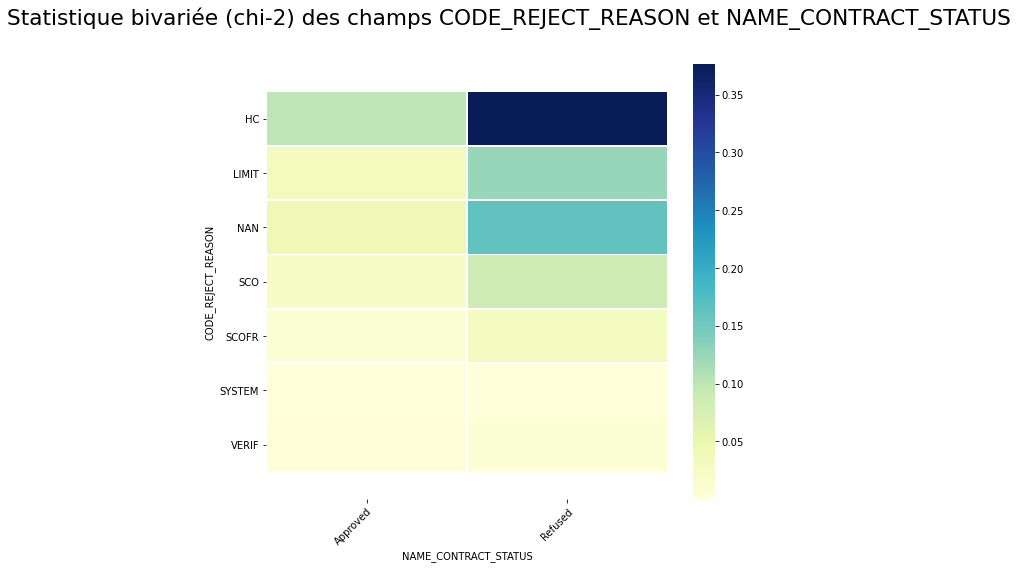

chi-2 entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 738048.5723018179 
phi-2 entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.9817517559321145 
coefficient T de Tschuprow entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.6330864680430166 
coefficient C de Cramer entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.9908338689871852 


In [91]:
myDf(dfPreviousApplication.replace(np.nan,'NAN')).Stat(['NAME_CONTRACT_STATUS','CODE_REJECT_REASON'], typeStat='biv')

In [92]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','CODE_REJECT_REASON']].replace(np.nan,'NAN').groupby(['NAME_CONTRACT_STATUS','CODE_REJECT_REASON']).size()

NAME_CONTRACT_STATUS  CODE_REJECT_REASON
Approved              NAN                   592924
Refused               HC                     94311
                      LIMIT                  31405
                      NAN                     2295
                      SCO                    21661
                      SCOFR                   7054
                      SYSTEM                   115
                      VERIF                   2002
dtype: int64

In [93]:
del dfPreviousApplication['CODE_REJECT_REASON']

### Contract_type, channel_type, flag_insurance

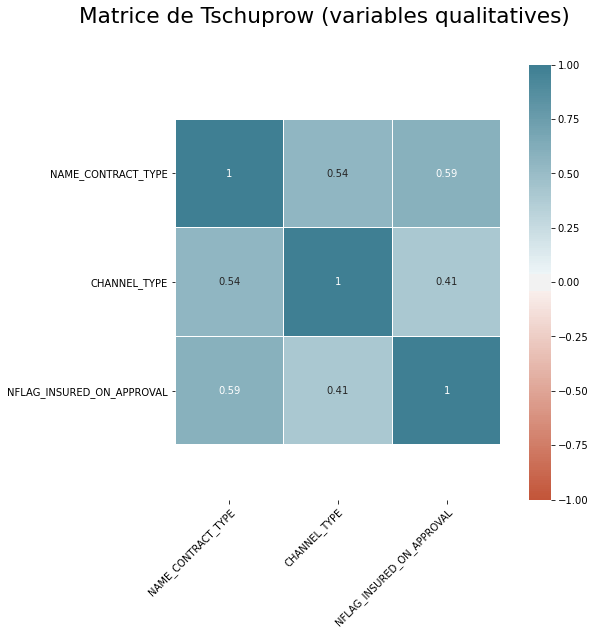

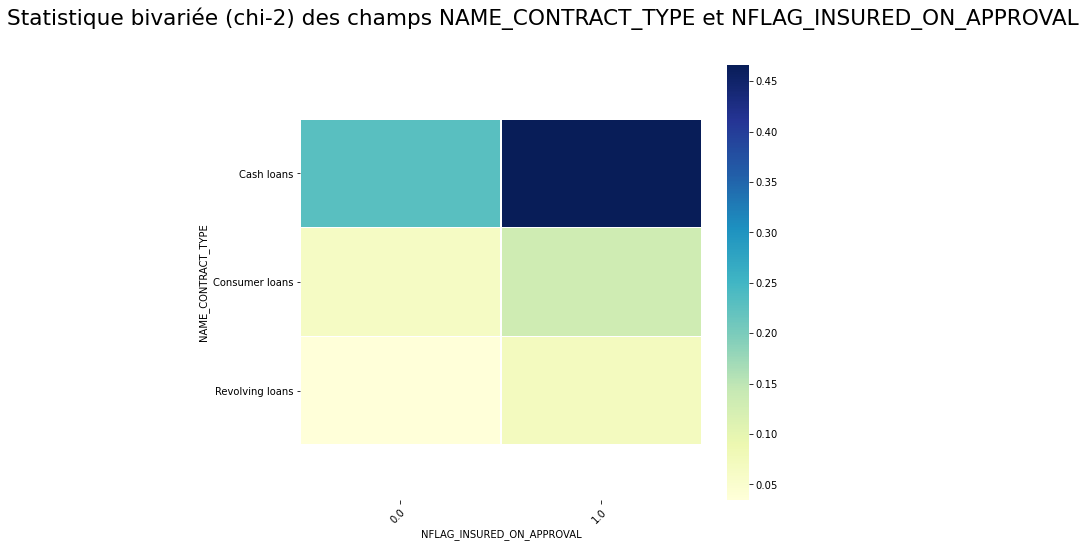

chi-2 entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 236064.2982536396 
phi-2 entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.413736332899799 
coefficient T de Tschuprow entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.5408842451178466 
coefficient C de Cramer entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.643223392687019 


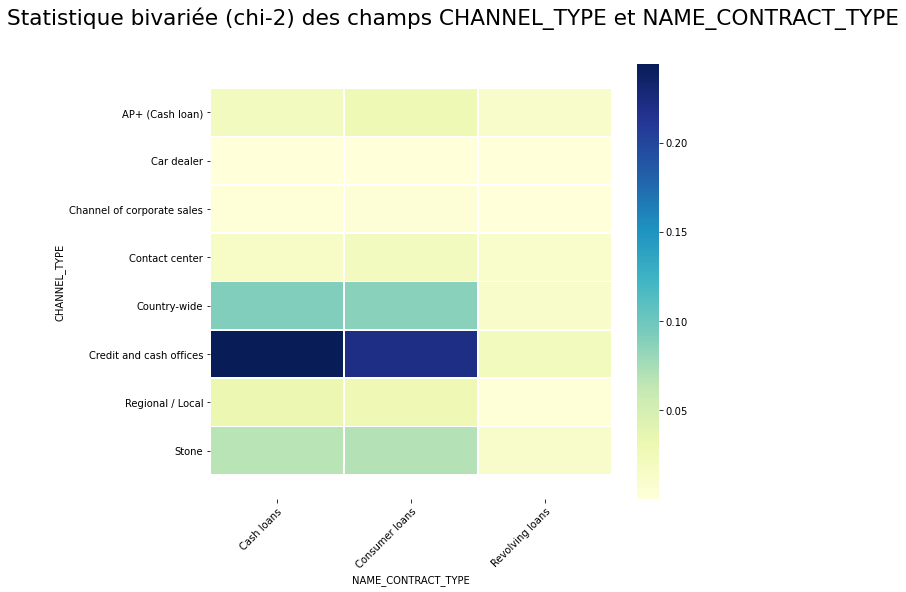

chi-2 entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 594402.8095701596 
phi-2 entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.7906931829243 
coefficient T de Tschuprow entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.4596973374297878 
coefficient C de Cramer entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.6287659274023601 


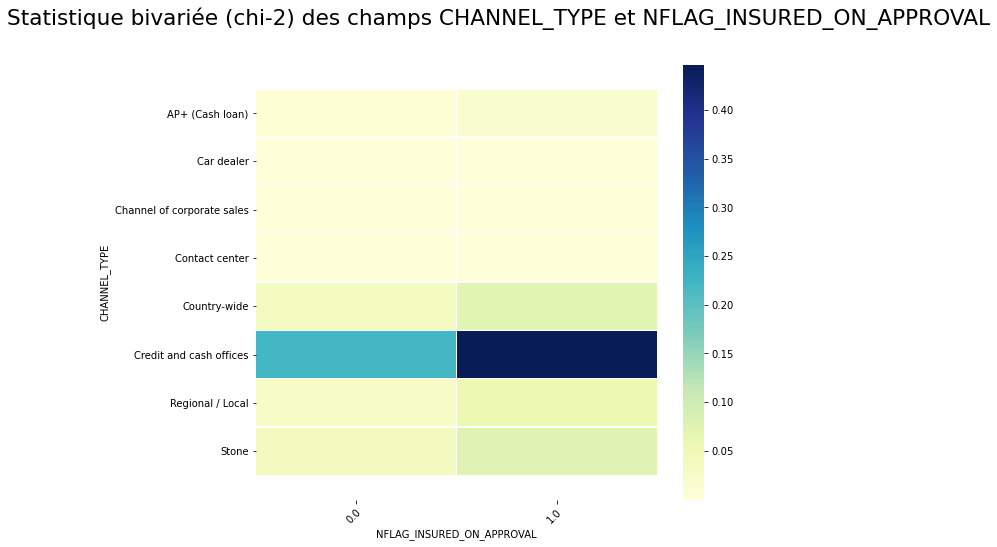

chi-2 entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 144141.78084831272 
phi-2 entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.2526290178862653 
coefficient T de Tschuprow entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.3090061384701296 
coefficient C de Cramer entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.5026221422562532 


In [94]:
myDf(dfPreviousApplication).Stat(['NAME_CONTRACT_TYPE','CHANNEL_TYPE','NFLAG_INSURED_ON_APPROVAL'], typeStat='biv')

C'est le flag insurance qui est le moins souvent renseigné

In [95]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_CONTRACT_TYPE','CHANNEL_TYPE','NFLAG_INSURED_ON_APPROVAL']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_CONTRACT_TYPE               18
CHANNEL_TYPE                      0
NFLAG_INSURED_ON_APPROVAL    181200
dtype: int64

Mais c'est surtout sur les crédit refusés que le flag insurance n'est pas renseigné

In [96]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','NFLAG_INSURED_ON_APPROVAL']].replace(np.nan, -99).groupby(['NAME_CONTRACT_STATUS','NFLAG_INSURED_ON_APPROVAL']).size()

NAME_CONTRACT_STATUS  NFLAG_INSURED_ON_APPROVAL
Approved              -99.0                         22357
                       0.0                         381904
                       1.0                         188663
Refused               -99.0                        158843
dtype: int64

De plus, la majeur partie des SK_ID_CURR ont au moins un SK_ID_PREV avec le flag insurance renseigné

In [97]:
NB_SK_ID_CURR_WITH_INSURANCE_FLAG = len(dfPreviousApplication[~dfPreviousApplication.NFLAG_INSURED_ON_APPROVAL.isnull()].SK_ID_CURR.unique())
NB_SK_ID_CURR = len(dfPreviousApplication.SK_ID_CURR.unique())
print("{} SK_ID_CURR sur {} n'ont aucune ligne avec un flag insurrance renseigné".format(NB_SK_ID_CURR-NB_SK_ID_CURR_WITH_INSURANCE_FLAG,NB_SK_ID_CURR))

598 SK_ID_CURR sur 194723 n'ont aucune ligne avec un flag insurrance renseigné


Donc on conserve le flag insurance car c'est un flag

In [98]:
del dfPreviousApplication['CHANNEL_TYPE']
del dfPreviousApplication['NAME_CONTRACT_TYPE']

### Name yield group et product combination

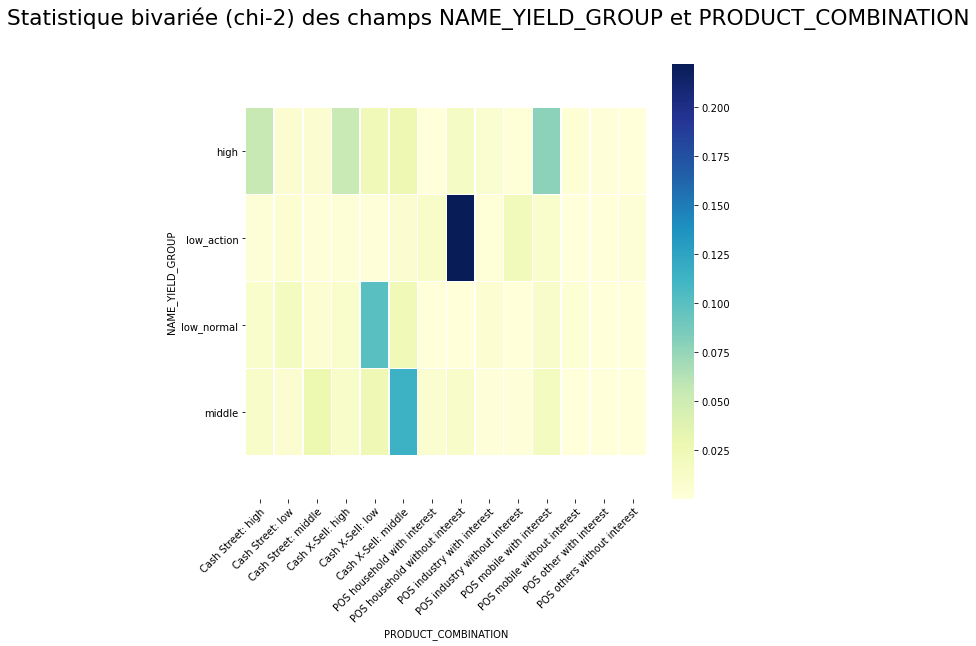

chi-2 entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 939236.1563181238 
phi-2 entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 1.4401045021743695 
coefficient T de Tschuprow entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 0.48020961591744066 
coefficient C de Cramer entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 0.6928454618875144 


In [99]:
myDf(dfPreviousApplication).Stat(['NAME_YIELD_GROUP','PRODUCT_COMBINATION'], typeStat='biv')

In [100]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_YIELD_GROUP','PRODUCT_COMBINATION']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_YIELD_GROUP       99567
PRODUCT_COMBINATION       18
dtype: int64

In [101]:
NB_SK_ID_CURR_WITH_YIELD_GROUP = len(dfPreviousApplication[~dfPreviousApplication.NAME_YIELD_GROUP.isnull()].SK_ID_CURR.unique())
NB_SK_ID_CURR = len(dfPreviousApplication.SK_ID_CURR.unique())
print("{} SK_ID_CURR sur {} n'ont aucune ligne avec un yield group renseigné".format(NB_SK_ID_CURR-NB_SK_ID_CURR_WITH_YIELD_GROUP,NB_SK_ID_CURR))

1460 SK_ID_CURR sur 194723 n'ont aucune ligne avec un yield group renseigné


On conserve NAME_YIELD_GROUP car c'est une variable ordonnable

In [102]:
del dfPreviousApplication['PRODUCT_COMBINATION']

### Name seller industry, name goods category

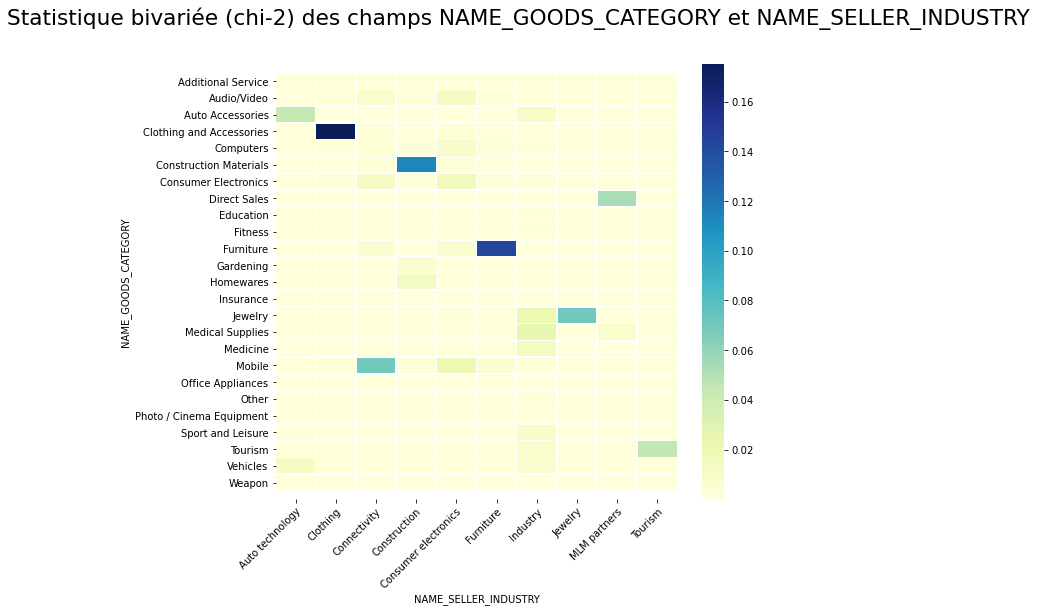

chi-2 entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 1908360.3186324455 
phi-2 entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 4.806008690062017 
coefficient T de Tschuprow entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 0.5718456714406268 
coefficient C de Cramer entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 0.7307536969201361 


In [103]:
myDf(dfPreviousApplication).Stat(['NAME_SELLER_INDUSTRY','NAME_GOODS_CATEGORY'], typeStat='biv')

In [104]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_SELLER_INDUSTRY','NAME_GOODS_CATEGORY']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_SELLER_INDUSTRY    302496
NAME_GOODS_CATEGORY     354159
dtype: int64

In [105]:
del dfPreviousApplication['NAME_GOODS_CATEGORY']

### Down payment

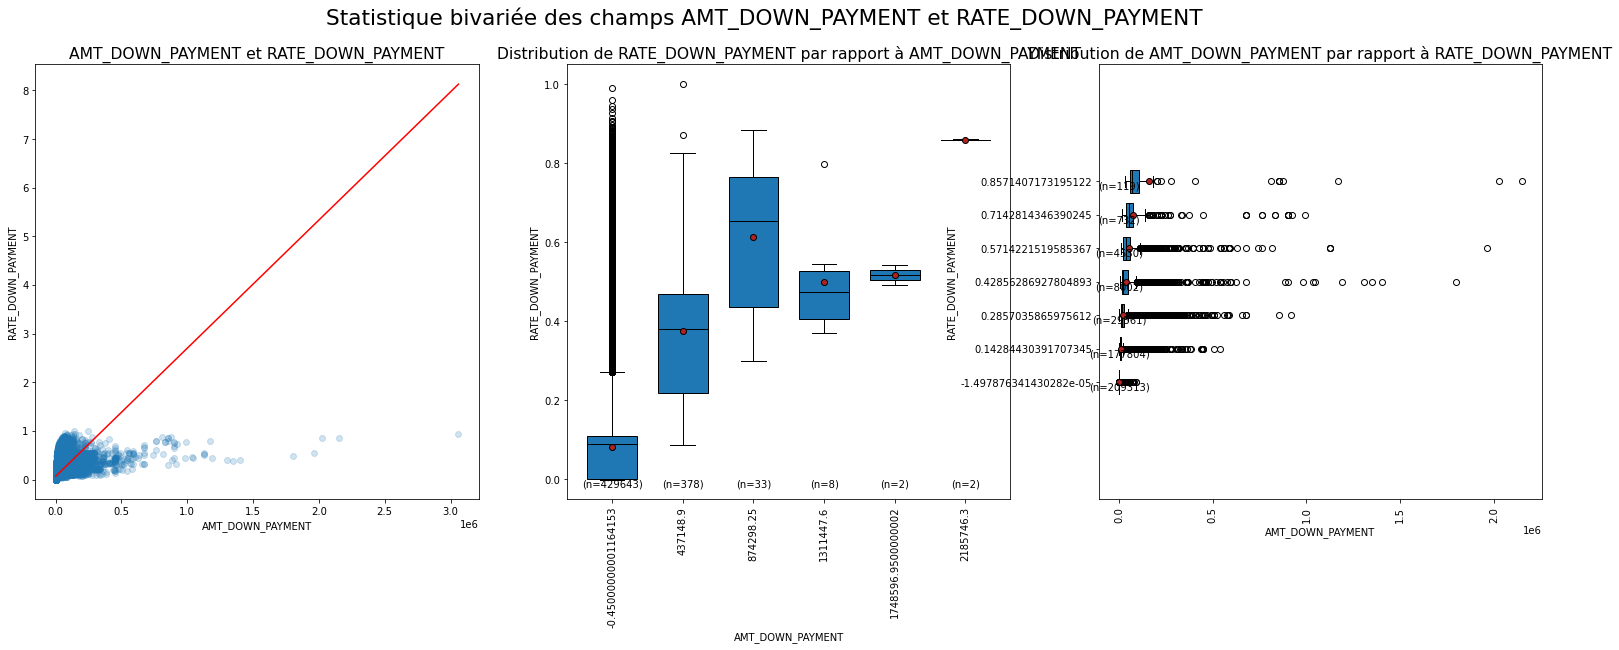

Covariance entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 1064.6146271110447 
Covariance débiaisée entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 1064.617102579059 
Coefficient de correlation linéaire entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 0.48836181470729334 
Régression linéaire entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT: y = 2.6355708756480583e-06x + 0.06477540891083616
Coefficient de détermination entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 0.23849726206420072 


In [106]:
myDf(dfPreviousApplication).Stat(['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT'], typeStat='biv')

In [107]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_DOWN_PAYMENT     321700
RATE_DOWN_PAYMENT    321700
dtype: int64

In [108]:
del dfPreviousApplication['AMT_DOWN_PAYMENT']

### Matrice des corrélations des variables restantes

/home/pierre/Documents/Projet_7/Git/credit_scoring/myTools.py:1477: RuntimeWarning: invalid value encountered in double_scalars
  tschuprow = math.sqrt(phi2 / math.sqrt((r-1)*(c-1)))
/home/pierre/Documents/Projet_7/Git/credit_scoring/myTools.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  cramer = math.sqrt(phi2/(min(r,c)-1))


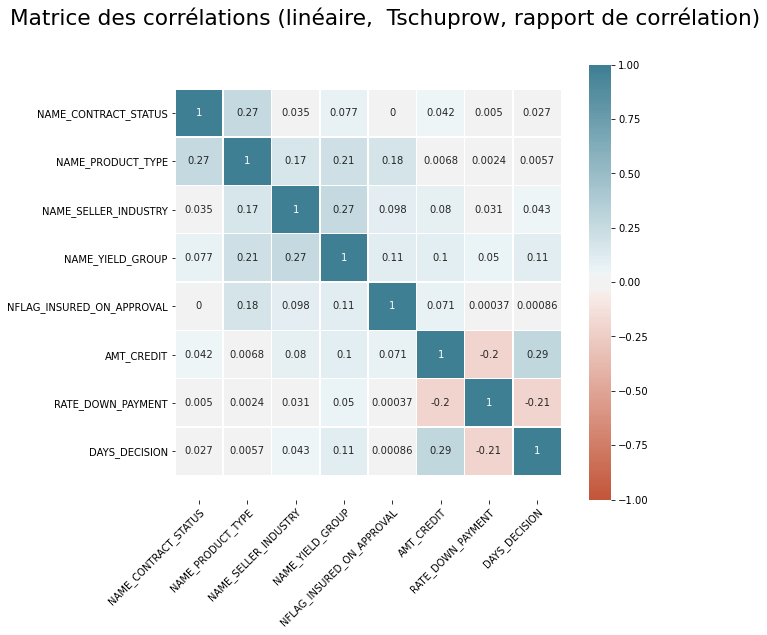

In [109]:
myDf(dfPreviousApplication).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='biv', bivOnlyCorrTable=True)

## Statistique univariée

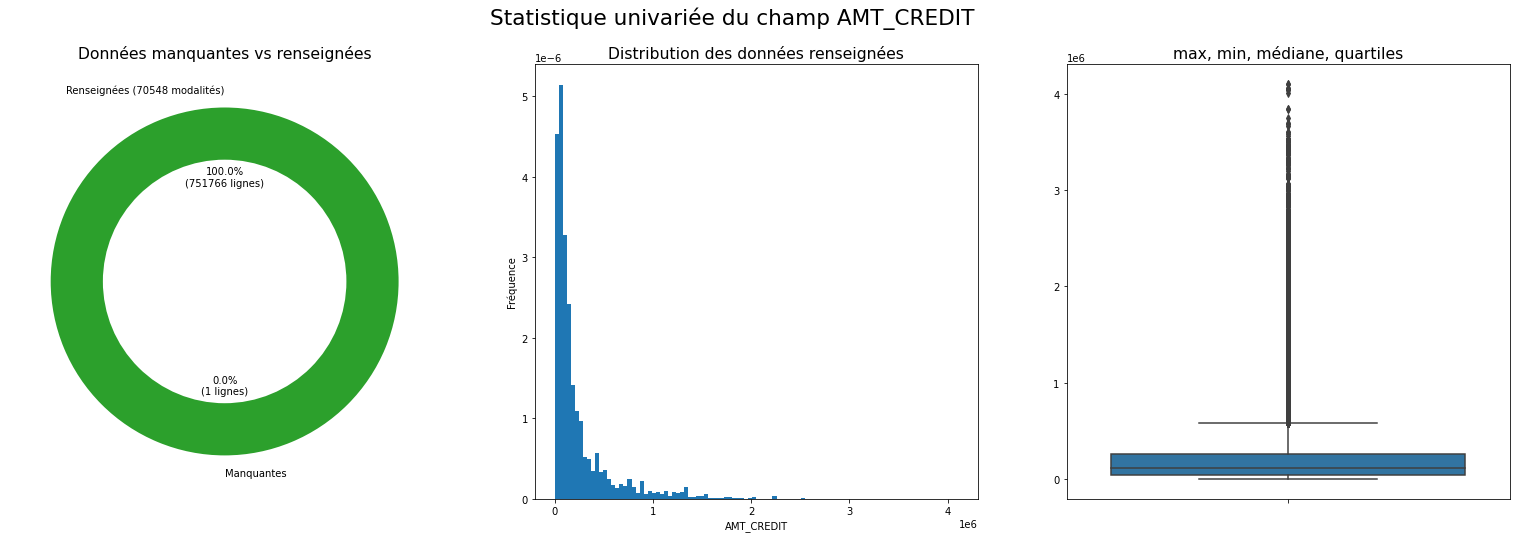

Mesures de position
 - Moyenne: 237266.59
 - Médiane: 111919.5
Mesures de dispertion
 - Ecart type: 335157.27
 - Min: 0.0
 - Q25: 47970.0
 - Q75: 260896.5
 - Max: 4104351.0
Mesures de forme
 - Skewness (asymétrie): 3.04
 - Kurtosis (applatissement): 12.38


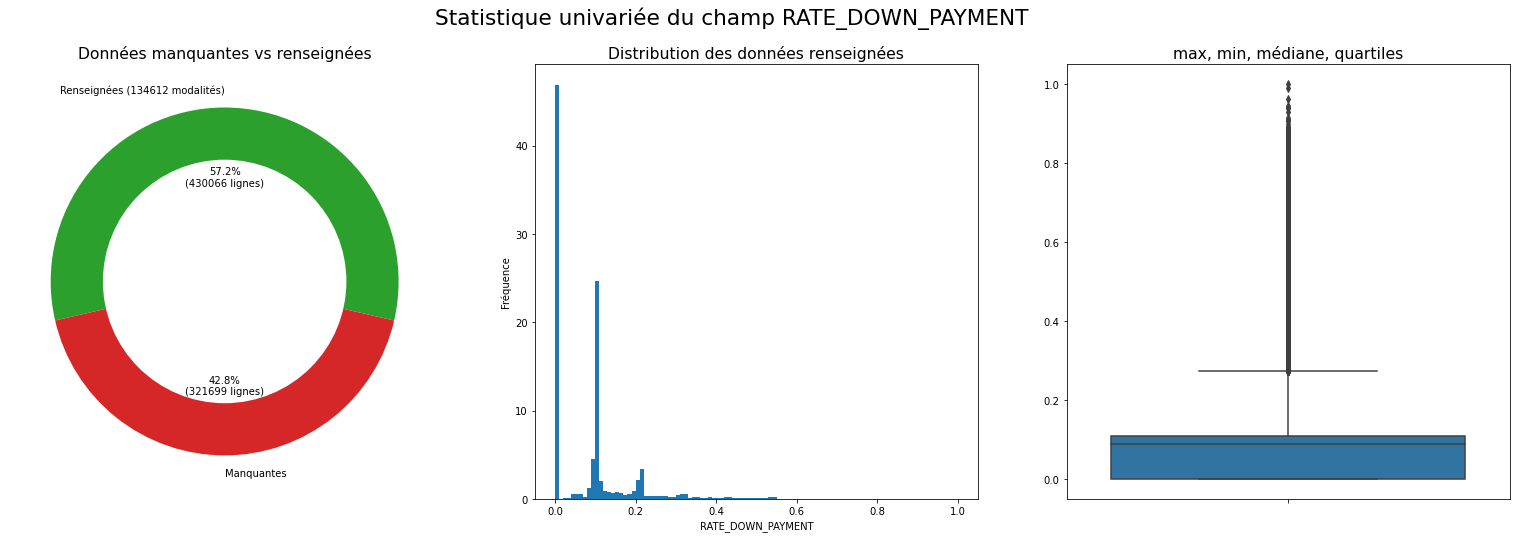

Mesures de position
 - Moyenne: 0.08
 - Médiane: 0.09
Mesures de dispertion
 - Ecart type: 0.11
 - Min: -0.0
 - Q25: 0.0
 - Q75: 0.11
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.07
 - Kurtosis (applatissement): 6.03


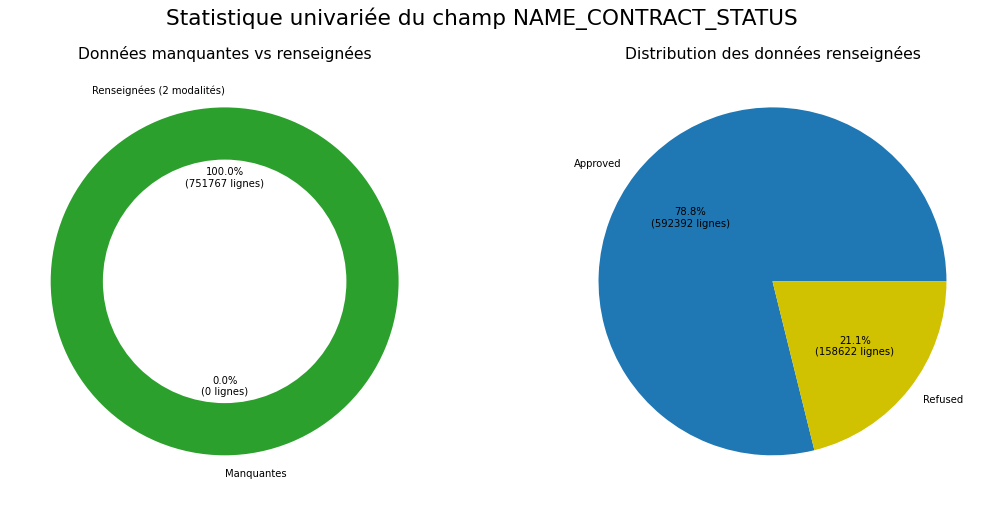

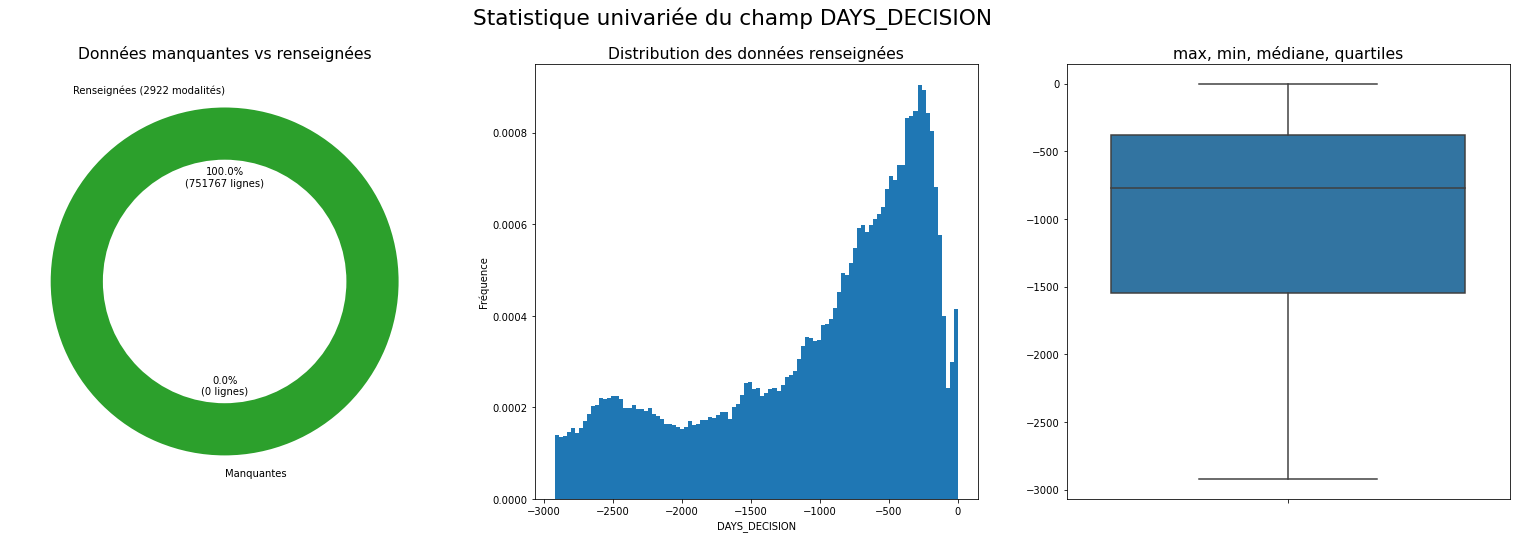

Mesures de position
 - Moyenne: -1030.38
 - Médiane: -773.0
Mesures de dispertion
 - Ecart type: 794.53
 - Min: -2922
 - Q25: -1549.0
 - Q75: -380.0
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -0.8
 - Kurtosis (applatissement): -0.55


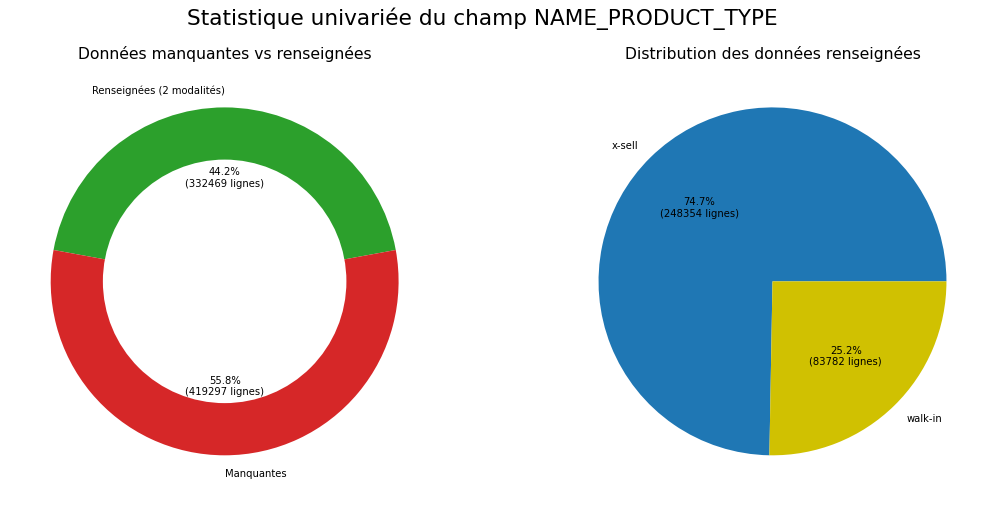

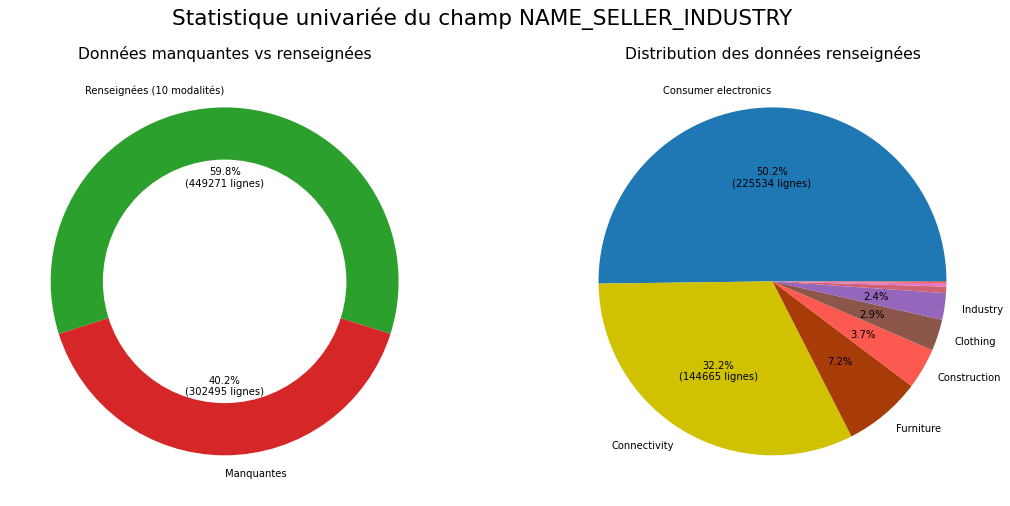

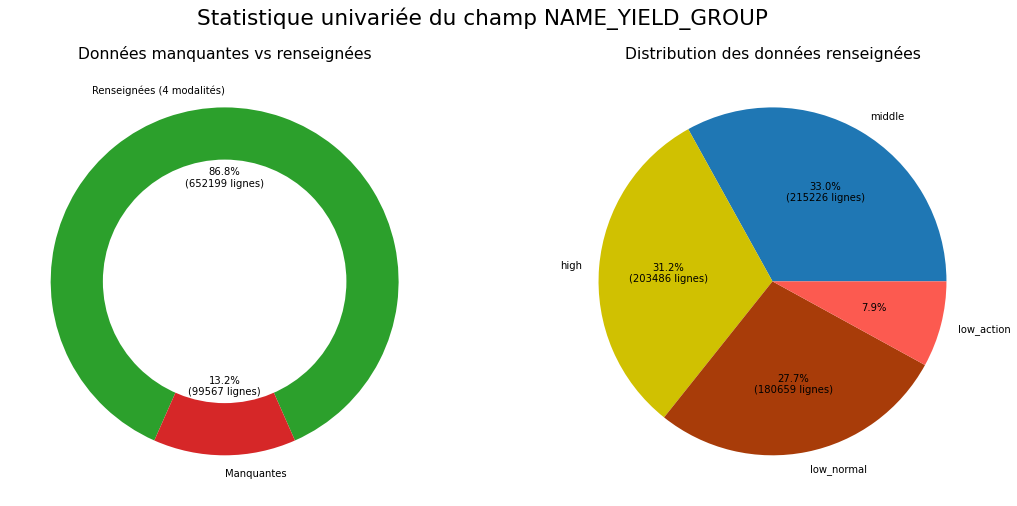

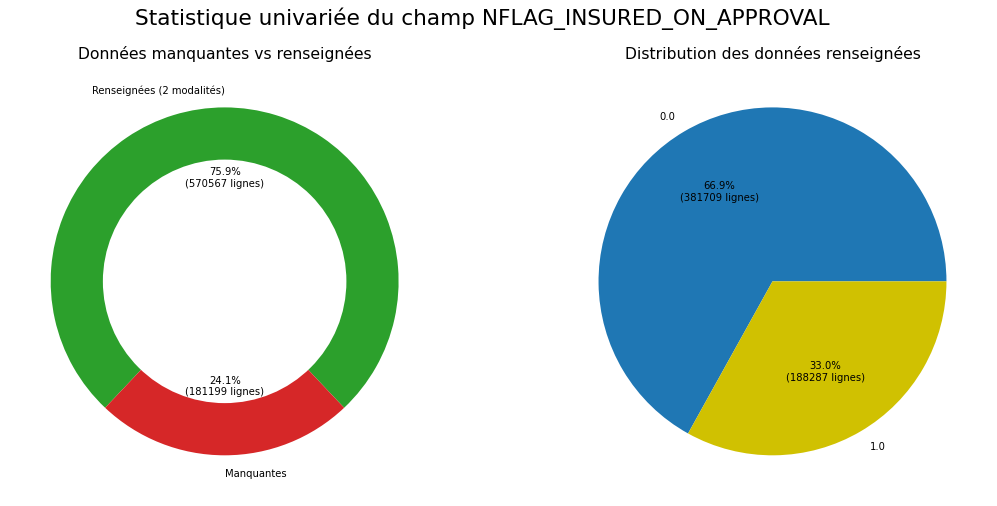

In [110]:
myDf(dfPreviousApplication).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_PREV','SK_ID_CURR'])

## Encodage de variables catégorielles

In [111]:
dfPreviousApplication['NAME_YIELD_GROUP_ENCODED'] = -1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP_ENCODED"] = 3
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP_ENCODED"] = 2
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP_ENCODED"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP_ENCODED"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP_ENCODED == -1].index, "NAME_YIELD_GROUP_ENCODED"] = np.nan
del dfPreviousApplication['NAME_YIELD_GROUP']

In [112]:
dfPreviousApplication['NAME_CONTRACT_STATUS_ENCODED'] = -1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved'].index, "NAME_CONTRACT_STATUS_ENCODED"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused'].index, "NAME_CONTRACT_STATUS_ENCODED"] = 0
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS_ENCODED == -1].index, "NAME_CONTRACT_STATUS_ENCODED"] = np.nan
del dfPreviousApplication['NAME_CONTRACT_STATUS']

In [113]:
dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
dfXSell['X_SELL'] = 1
dfXSell
dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication['X_SELL'] = dfPreviousApplication.apply(lambda x: np.where(x.X_SELL==1,1,0), axis=1)
del dfPreviousApplication['NAME_PRODUCT_TYPE']

# Exploration de installment payments

## Suppression de variables inintéressantes

In [6]:
del dfInstallmentsPayments['NUM_INSTALMENT_VERSION'] #Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER'] #On which installment we observe payment

## Statistique univariée

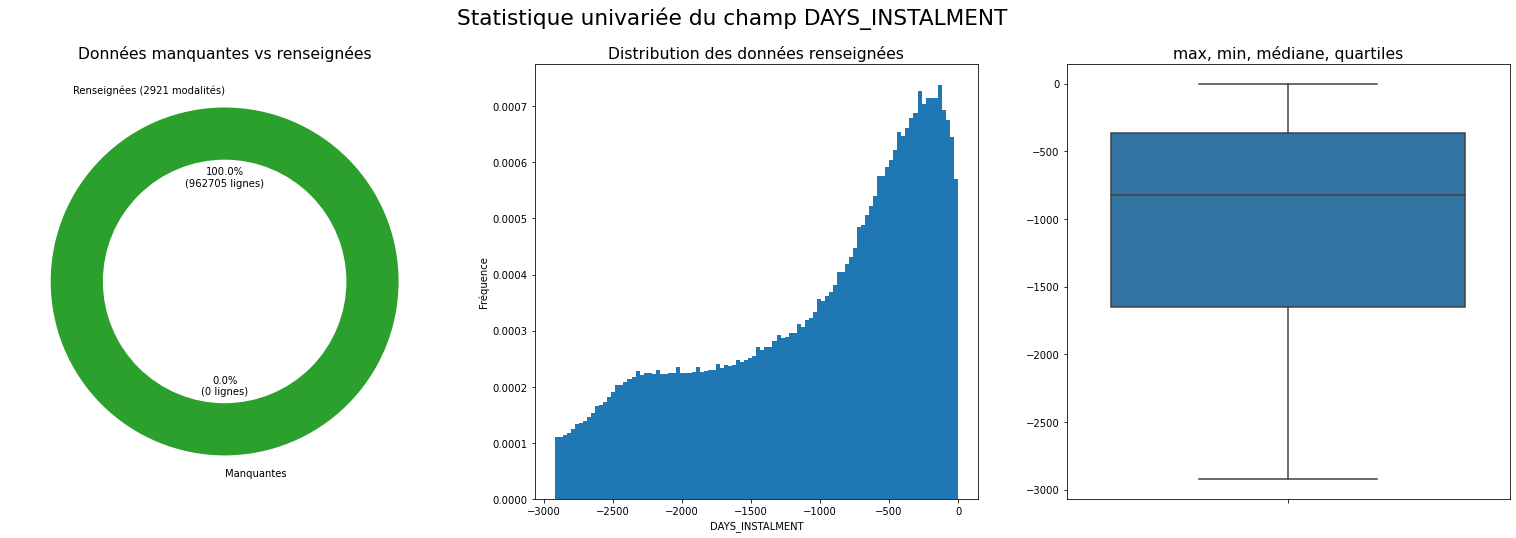

Mesures de position
 - Moyenne: -1045.79
 - Médiane: -826.0
Mesures de dispertion
 - Ecart type: 799.73
 - Min: -2922.0
 - Q25: -1653.0
 - Q75: -365.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.63
 - Kurtosis (applatissement): -0.79


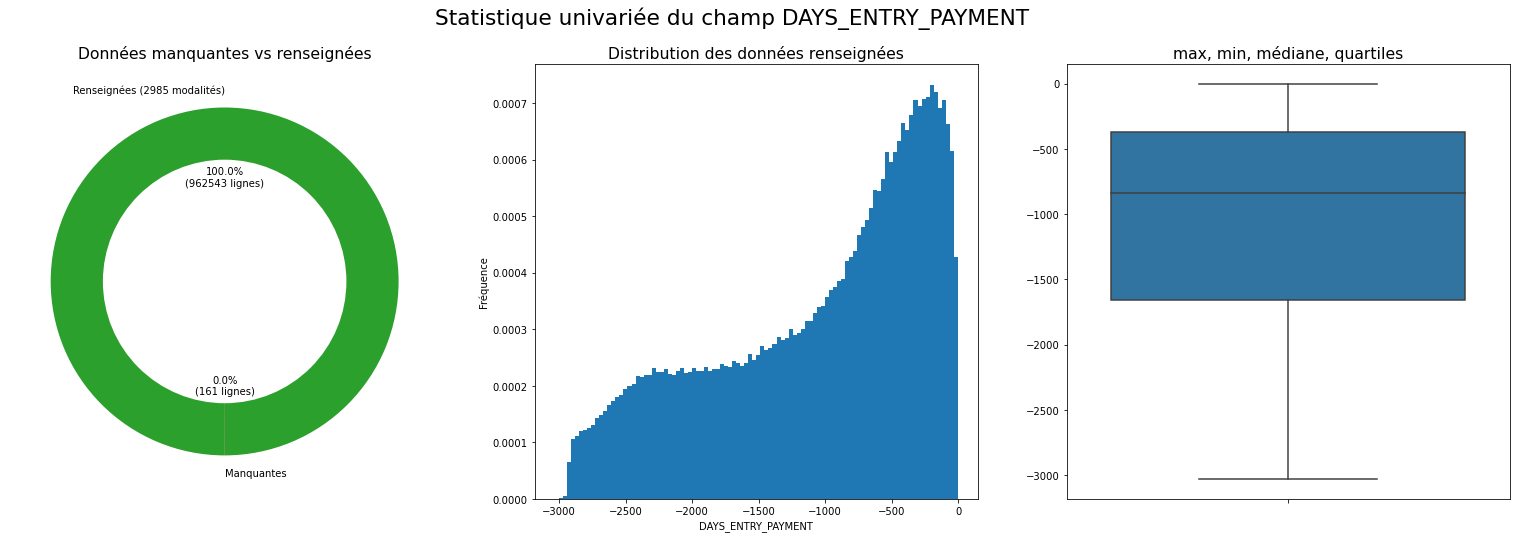

Mesures de position
 - Moyenne: -1054.55
 - Médiane: -835.0
Mesures de dispertion
 - Ecart type: 799.23
 - Min: -3031.0
 - Q25: -1661.0
 - Q75: -375.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.62
 - Kurtosis (applatissement): -0.8


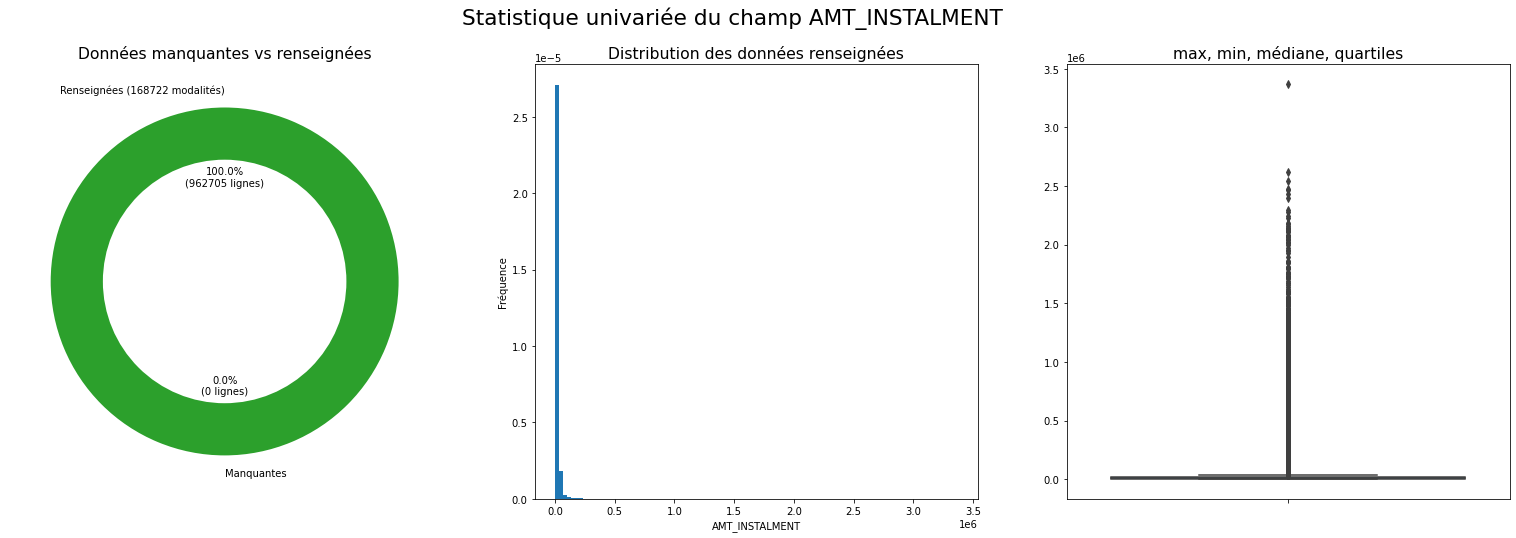

Mesures de position
 - Moyenne: 16891.28
 - Médiane: 8772.3
Mesures de dispertion
 - Ecart type: 50604.59
 - Min: 0.0
 - Q25: 4182.03
 - Q75: 16563.15
 - Max: 3371884.16
Mesures de forme
 - Skewness (asymétrie): 16.51
 - Kurtosis (applatissement): 404.66


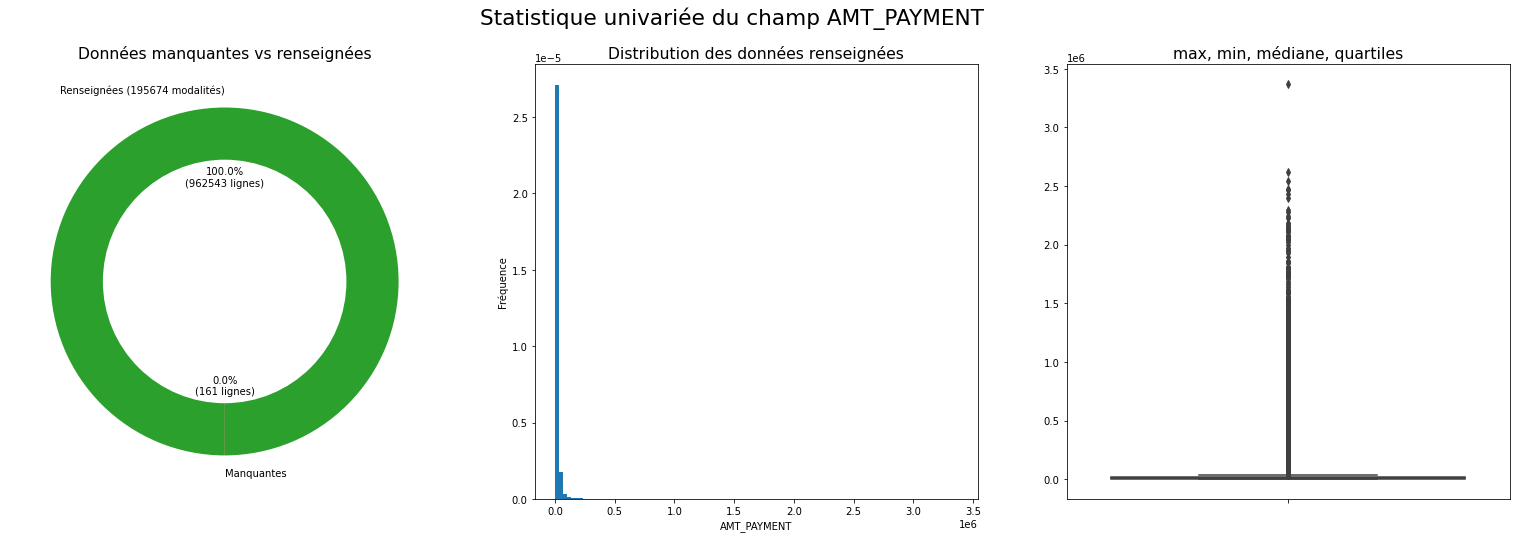

Mesures de position
 - Moyenne: 17082.12
 - Médiane: 8100.0
Mesures de dispertion
 - Ecart type: 54507.83
 - Min: 0.0
 - Q25: 3379.28
 - Q75: 15955.42
 - Max: 3371884.16
Mesures de forme
 - Skewness (asymétrie): 15.04
 - Kurtosis (applatissement): 329.84


In [21]:
myDf(dfInstallmentsPayments).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

# Exploration de PosCashBalance

In [88]:
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")

In [89]:
dfPosCashBalance = dfPosCashBalance[(dfPosCashBalance.SK_ID_CURR >150000) & (dfPosCashBalance.SK_ID_CURR <175000)]

## Variables inintéressantes

In [90]:
dfPosCashBalance.NAME_CONTRACT_STATUS.value_counts()

Active                   637691
Completed                 51801
Signed                     6113
Returned to the store       404
Approved                    338
Demand                      219
Amortized debt               11
Name: NAME_CONTRACT_STATUS, dtype: int64

In [91]:
del dfPosCashBalance['NAME_CONTRACT_STATUS']
del dfPosCashBalance['CNT_INSTALMENT'] # Term of previous credit (can change over time)
del dfPosCashBalance['CNT_INSTALMENT_FUTURE'] # Installments left to pay on the previous credit

## Recherche de corrélations

### Entre SK_DPD et SK_DPD_DEF

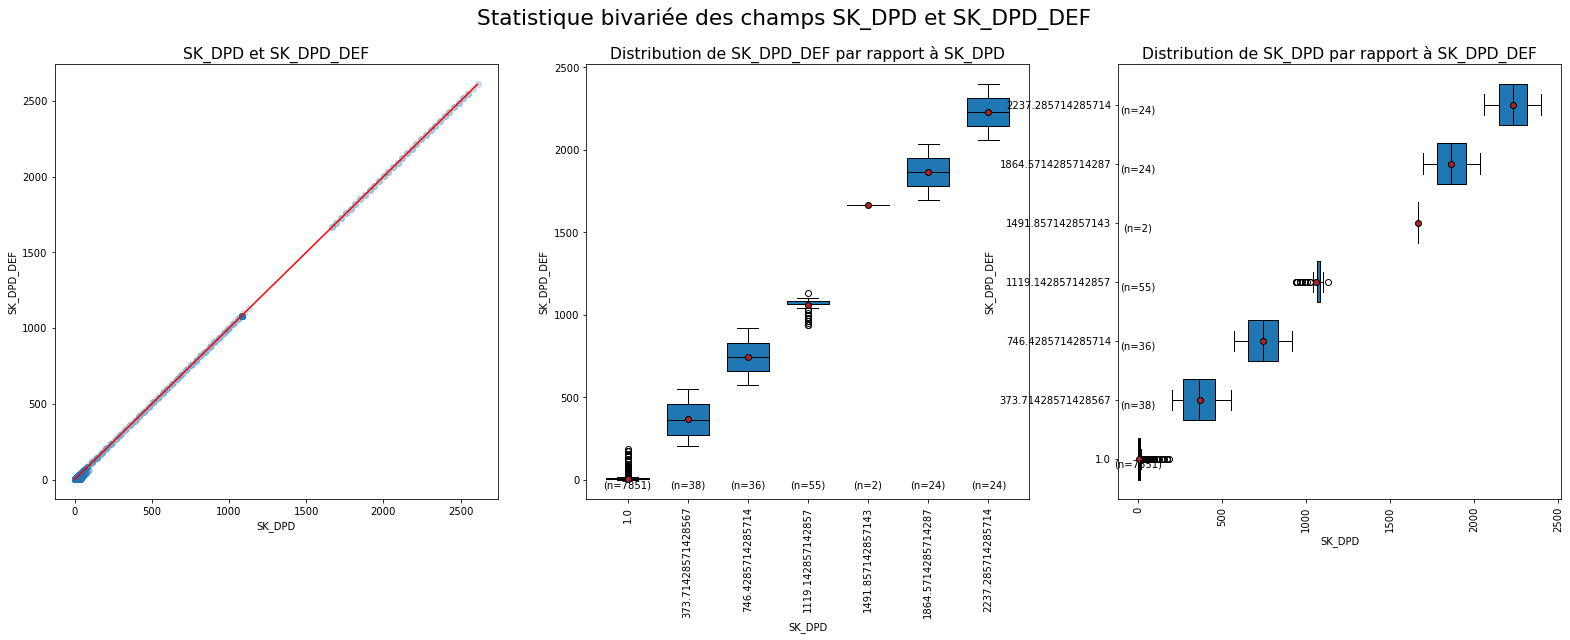

Covariance entre SK_DPD et SK_DPD_DEF : 45124.90762801437 
Covariance débiaisée entre SK_DPD et SK_DPD_DEF : 45130.51948072274 
Coefficient de correlation linéaire entre SK_DPD et SK_DPD_DEF : 0.9998198958785647 
Régression linéaire entre SK_DPD et SK_DPD_DEF: y = 0.9999639124983335x + -0.550815617827929
Coefficient de détermination entre SK_DPD et SK_DPD_DEF : 0.9996398241946239 


In [92]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD_DEF != 0]).Stat(['SK_DPD','SK_DPD_DEF'], typeStat='biv')

In [93]:
print('Nombre de lignes avec le champ vide:')
(dfPosCashBalance[['SK_DPD','SK_DPD_DEF']].isnull()).sum()

Nombre de lignes avec le champ vide:


SK_DPD        0
SK_DPD_DEF    0
dtype: int64

In [94]:
print('Nombre de lignes avec SK_DPD=0 et SK_DPD_DEF != 0:')
dfPosCashBalance[(dfPosCashBalance.SK_DPD == 0) & (dfPosCashBalance.SK_DPD_DEF != 0)].shape[0]

Nombre de lignes avec SK_DPD=0 et SK_DPD_DEF != 0:


0

In [95]:
print('Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF=0:')
dfPosCashBalance[(dfPosCashBalance.SK_DPD != 0) & (dfPosCashBalance.SK_DPD_DEF == 0)].shape[0]

Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF=0:


13040

In [96]:
print('Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF!=0:')
dfPosCashBalance[dfPosCashBalance.SK_DPD != 0].shape[0]

Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF!=0:


21082

On prend la moyenne des deux

In [97]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: (x.SK_DPD + x.SK_DPD_DEF) / 2, axis=1)

In [98]:
del dfPosCashBalance['SK_DPD_DEF']

## Statistique univariée

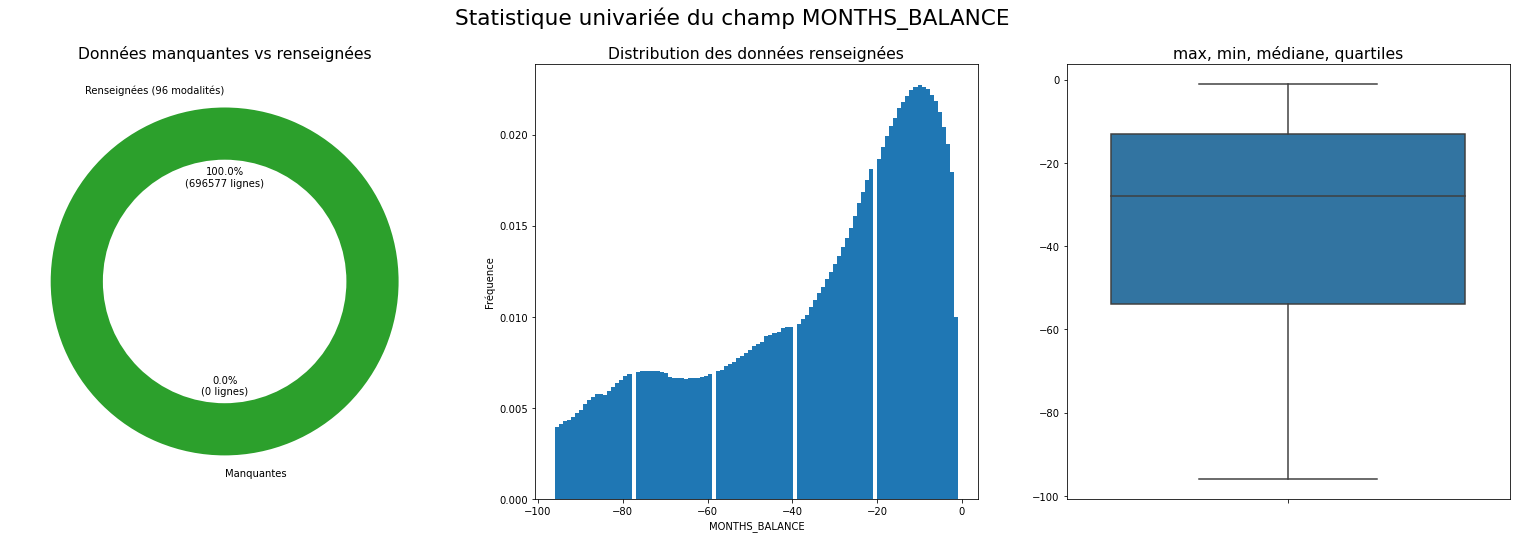

Mesures de position
 - Moyenne: -35.15
 - Médiane: -28.0
Mesures de dispertion
 - Ecart type: 26.17
 - Min: -96
 - Q25: -54.0
 - Q75: -13.0
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -0.66
 - Kurtosis (applatissement): -0.73


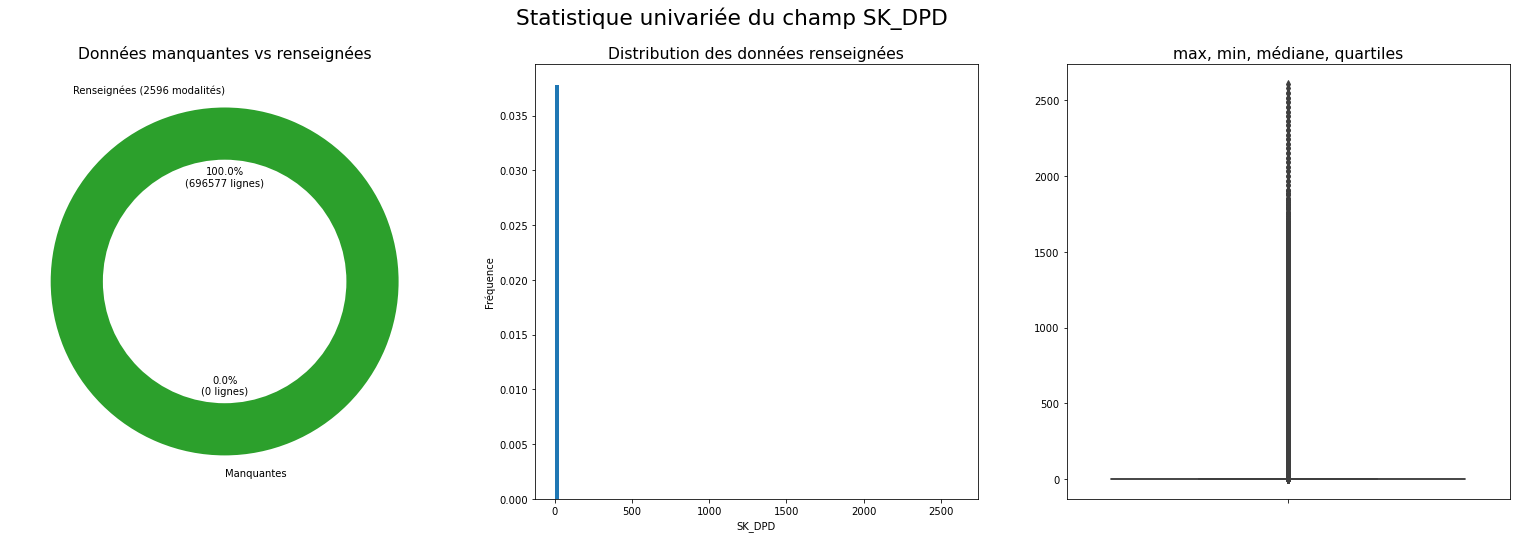

Mesures de position
 - Moyenne: 6.3
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 70.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 2610.0
Mesures de forme
 - Skewness (asymétrie): 15.07
 - Kurtosis (applatissement): 273.47


In [99]:
myDf(dfPosCashBalance).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

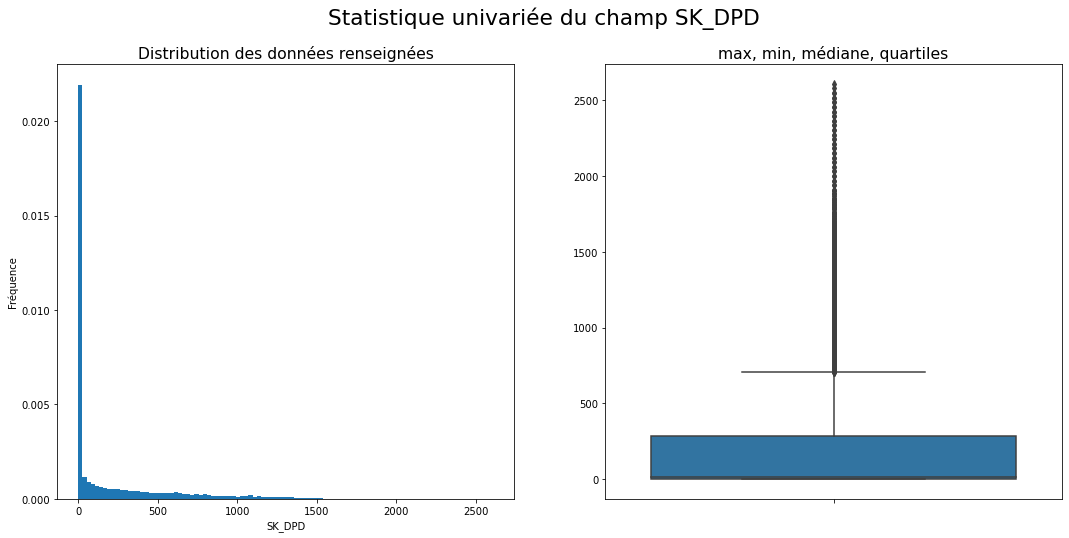

Mesures de position
 - Moyenne: 208.21
 - Médiane: 13.0
Mesures de dispertion
 - Ecart type: 351.65
 - Min: 0.5
 - Q25: 4.0
 - Q75: 286.0
 - Max: 2610.0
Mesures de forme
 - Skewness (asymétrie): 2.16
 - Kurtosis (applatissement): 4.99


In [100]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD > 0]).Stat('SK_DPD')

# Exploration de CreditCardBalance

In [5]:
dfPosCashBalance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [ ]:
dfPosCashBalance = dfPosCashBalance[(dfPosCashBalance.SK_ID_CURR > 150000) & (dfPosCashBalance.SK_ID_CURR < 200000)]
dfInstallmentsPayments = dfInstallmentsPayments[(dfInstallmentsPayments.SK_ID_CURR > 150000) & (dfInstallmentsPayments.SK_ID_CURR < 200000)]
dfCreditCardBalance = dfCreditCardBalance[(dfCreditCardBalance.SK_ID_CURR > 150000) & (dfCreditCardBalance.SK_ID_CURR < 200000)]

In [ ]:
dfPosCashBalance.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])

# Exploration de dfBureau

In [114]:
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureau = dfBureau.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)

In [115]:
dfBureau = dfBureau.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

## Statistiques sur les previous par current application

In [116]:
nbWithPrevious = dfApplicationTrain[dfApplicationTrain.SK_ID_CURR.isin(dfBureau.SK_ID_CURR)].shape[0]
nbWithoutPrevious = dfApplicationTrain[~dfApplicationTrain.SK_ID_CURR.isin(dfBureau.SK_ID_CURR)].shape[0]
print("{} loans sans previous ({}%)".format(nbWithoutPrevious, np.round(100 * nbWithoutPrevious / (nbWithPrevious + nbWithoutPrevious), 1)))

29649 loans sans previous (14.4%)


Text(0.5, 1.0, 'Stat nb previous application in other financial institution')

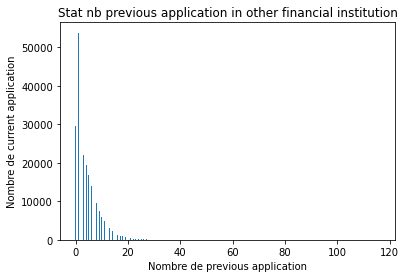

In [117]:
distrib_nb_previous = dfApplicationTrain.merge(dfBureau[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')['SK_ID_CURR'].value_counts().value_counts()
distrib_nb_previous[0] = nbWithoutPrevious
tmp = pd.DataFrame({'nb_previous': pd.Series(distrib_nb_previous.index),
                   'nb_application': distrib_nb_previous.reset_index(drop=True)}).sort_values('nb_previous')
plt.bar(pd.Series(distrib_nb_previous.index), distrib_nb_previous.reset_index(drop=True), width=0.3)
plt.xlabel('Nombre de previous application')
plt.ylabel('Nombre de current application')
plt.title("Stat nb previous application in other financial institution")

## Suppression de variables non pertinentes

### Trop de valeurs manquantes

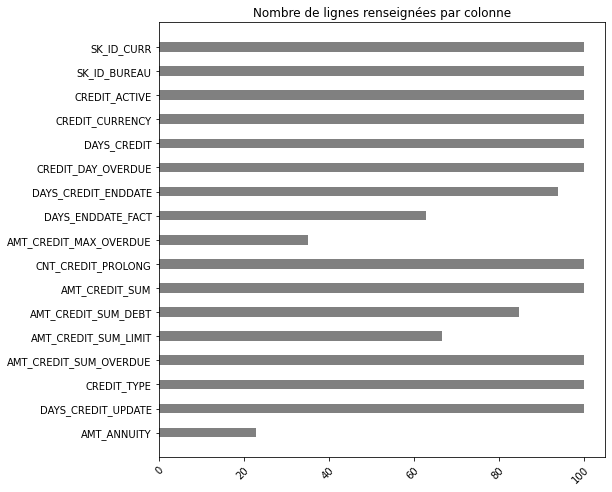

In [118]:
myDf(dfBureau).ColCountLinesChart(typeChart='barh', displayColName=True)

In [119]:
del dfBureau['AMT_ANNUITY']

### Devise

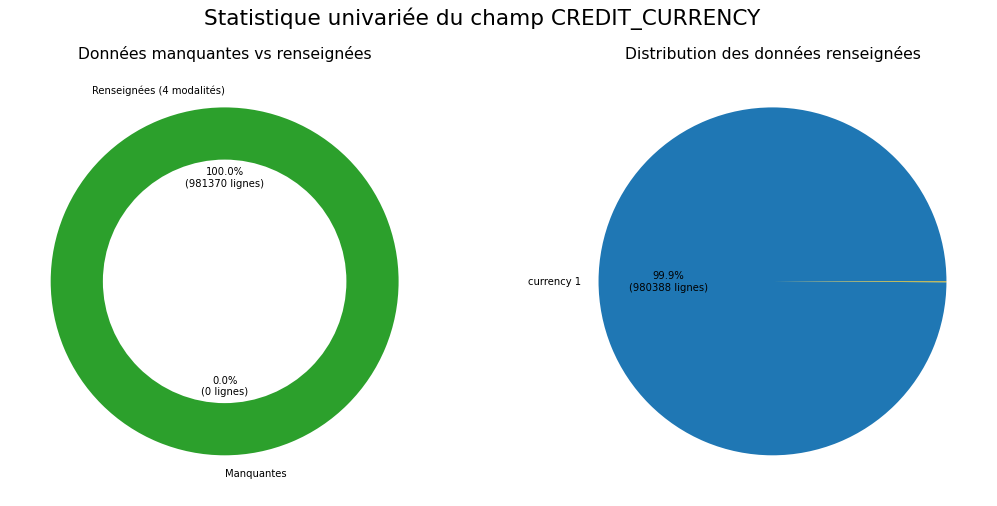

In [120]:
myDf(dfBureau).Stat('CREDIT_CURRENCY', statsNan=True)

In [121]:
dfBureau['AMT_CREDIT_SUM'] = dfBureau.apply(lambda x: np.where(x.CREDIT_CURRENCY=='currency 1', x.AMT_CREDIT_SUM, np.nan), axis=1)
dfBureau['AMT_CREDIT_SUM_DEBT'] = dfBureau.apply(lambda x: np.where(x.CREDIT_CURRENCY=='currency 1', x.AMT_CREDIT_SUM_DEBT, np.nan), axis=1)
#dfBureau['AMT_CREDIT_SUM_LIMIT'] = dfBureau.apply(lambda x: np.where(x.CREDIT_CURRENCY=='currency 1', x.AMT_CREDIT_SUM_LIMIT, np.nan), axis=1)
#dfBureau['AMT_CREDIT_SUM_OVERDUE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_CURRENCY=='currency 1', x.AMT_CREDIT_SUM_OVERDUE, np.nan), axis=1)
#dfBureau['AMT_CREDIT_MAX_OVERDUE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_CURRENCY=='currency 1', x.AMT_CREDIT_MAX_OVERDUE, np.nan), axis=1)

In [122]:
del dfBureau['CREDIT_CURRENCY']

### Trop de valeurs identiques

In [123]:
nb_zero = dfBureau[dfBureau.CNT_CREDIT_PROLONG==0].shape[0]
nb_not_null = dfBureau[~dfBureau.CNT_CREDIT_PROLONG.isnull()].shape[0]
print("CNT_CREDIT_PROLONG: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

CNT_CREDIT_PROLONG: 975425 sur 981370 à zéro (99.0%)


In [124]:
nb_zero = dfBureau[dfBureau.CREDIT_DAY_OVERDUE==0].shape[0]
nb_not_null = dfBureau[~dfBureau.CREDIT_DAY_OVERDUE.isnull()].shape[0]
print("CREDIT_DAY_OVERDUE: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

CREDIT_DAY_OVERDUE: 978903 sur 981370 à zéro (100.0%)


In [125]:
nb_zero = dfBureau[dfBureau.AMT_CREDIT_SUM_OVERDUE==0].shape[0]
nb_not_null = dfBureau[~dfBureau.AMT_CREDIT_SUM_OVERDUE.isnull()].shape[0]
print("AMT_CREDIT_SUM_OVERDUE: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

AMT_CREDIT_SUM_OVERDUE: 978947 sur 981370 à zéro (100.0%)


In [126]:
nb_zero = dfBureau[dfBureau['AMT_CREDIT_SUM_LIMIT']==0].shape[0]
nb_total = dfBureau[~dfBureau['AMT_CREDIT_SUM_LIMIT'].isnull()].shape[0]
print("{} AMT_CREDIT_SUM_LIMIT à zéro sur {} renseignés ({}%)".format(nb_zero,nb_total,np.round(100*nb_zero/nb_total,1)))

609652 AMT_CREDIT_SUM_LIMIT à zéro sur 653208 renseignés (93.3%)


In [127]:
nb_zero = dfBureau[dfBureau['AMT_CREDIT_MAX_OVERDUE']==0].shape[0]
nb_total = dfBureau[~dfBureau['AMT_CREDIT_MAX_OVERDUE'].isnull()].shape[0]
print("{} AMT_CREDIT_MAX_OVERDUE à zéro sur {} renseignés ({}%)".format(nb_zero,nb_total,np.round(100*nb_zero/nb_total,1)))

273836 AMT_CREDIT_MAX_OVERDUE à zéro sur 345742 renseignés (79.2%)


In [128]:
del dfBureau['CNT_CREDIT_PROLONG']
del dfBureau['CREDIT_DAY_OVERDUE']
del dfBureau['AMT_CREDIT_SUM_OVERDUE']
del dfBureau['AMT_CREDIT_SUM_LIMIT']
del dfBureau['AMT_CREDIT_MAX_OVERDUE']

## Recherche de corrélations

### Champs days

In [129]:
dfBureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'DAYS_CREDIT',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE'],
      dtype='object')

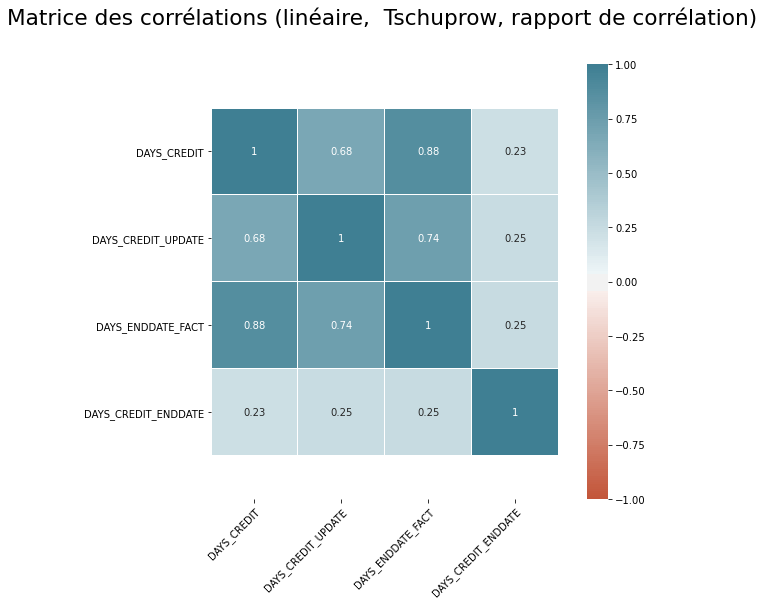

In [130]:
myDf(dfBureau).Stat(['DAYS_CREDIT','DAYS_CREDIT_UPDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_ENDDATE'], typeStat='biv', bivOnlyCorrTable=True)

In [131]:
print('Nombre de lignes avec le champ vide:')
(dfBureau[['DAYS_CREDIT','DAYS_CREDIT_UPDATE','DAYS_ENDDATE_FACT']].isnull()).sum()

Nombre de lignes avec le champ vide:


DAYS_CREDIT                0
DAYS_CREDIT_UPDATE         0
DAYS_ENDDATE_FACT     364634
dtype: int64

In [132]:
del dfBureau['DAYS_CREDIT_UPDATE']
del dfBureau['DAYS_ENDDATE_FACT']

### Champs amount

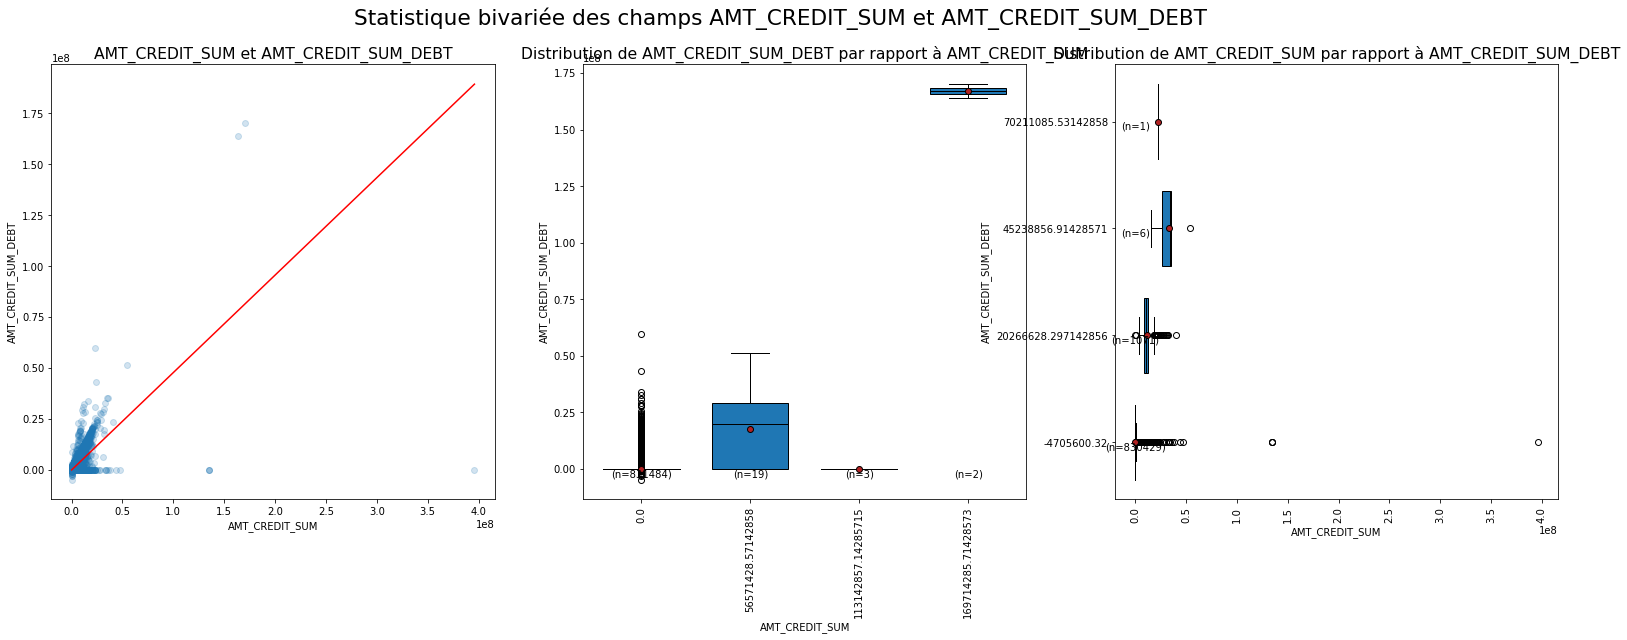

Covariance entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 472755949347.8521 
Covariance débiaisée entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 472756517900.3487 
Coefficient de correlation linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.7036006721172358 
Régression linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT: y = 0.4780494684885271x + -23284.38978539379
Coefficient de détermination entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.4950539058038259 


In [133]:
myDf(dfBureau).Stat(['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT'], typeStat='biv')

In [134]:
print('Nombre de lignes avec le champ vide:')
(dfBureau[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_CREDIT_SUM            793
AMT_CREDIT_SUM_DEBT    149858
dtype: int64

In [135]:
del dfBureau['AMT_CREDIT_SUM_DEBT']

### Autres champs

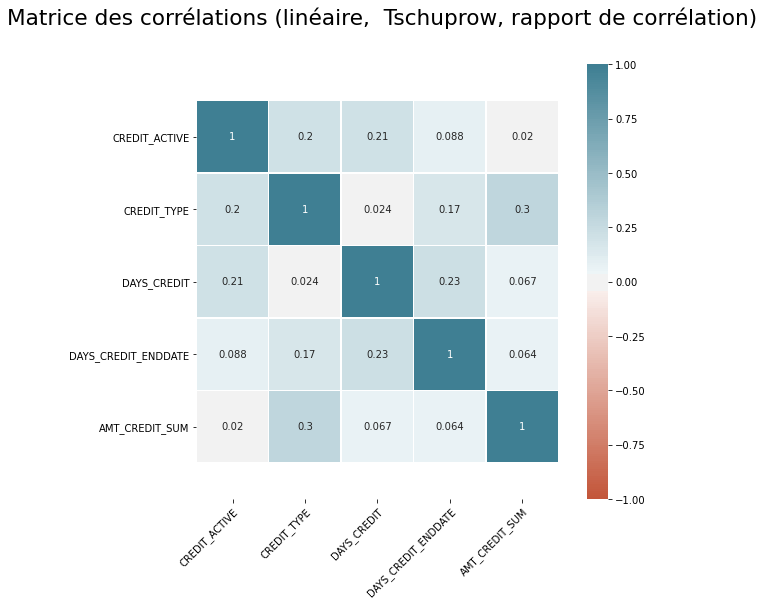

In [136]:
myDf(dfBureau).Stat(exclCol=['SK_ID_CURR','SK_ID_BUREAU'], typeStat='biv', bivOnlyCorrTable=True)

## Statistique univariée

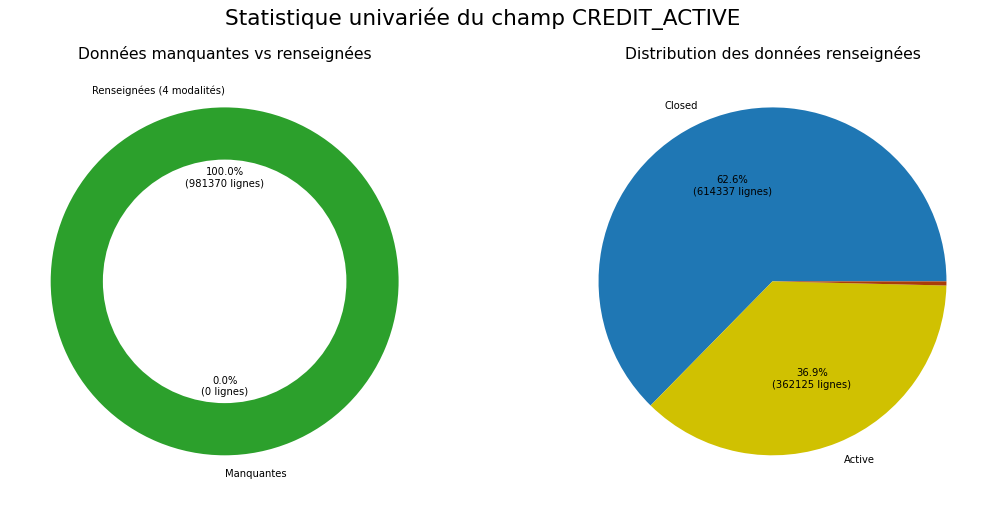

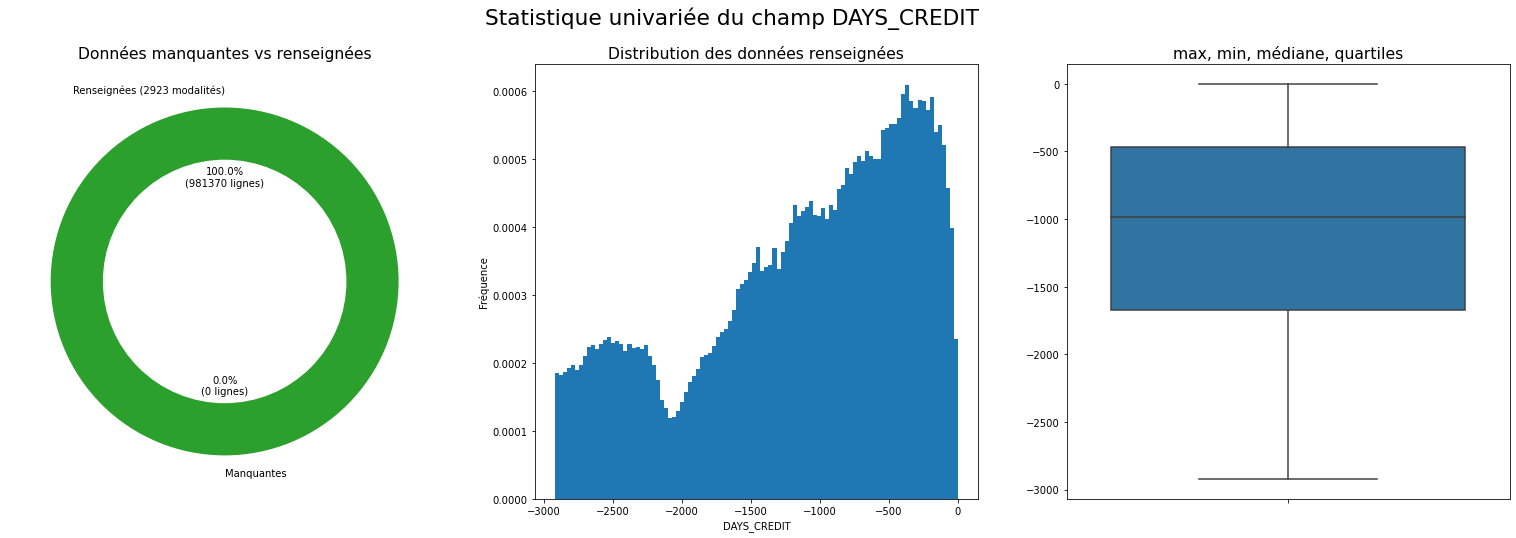

Mesures de position
 - Moyenne: -1143.14
 - Médiane: -985.0
Mesures de dispertion
 - Ecart type: 799.87
 - Min: -2922
 - Q25: -1671.0
 - Q75: -470.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -0.58
 - Kurtosis (applatissement): -0.76


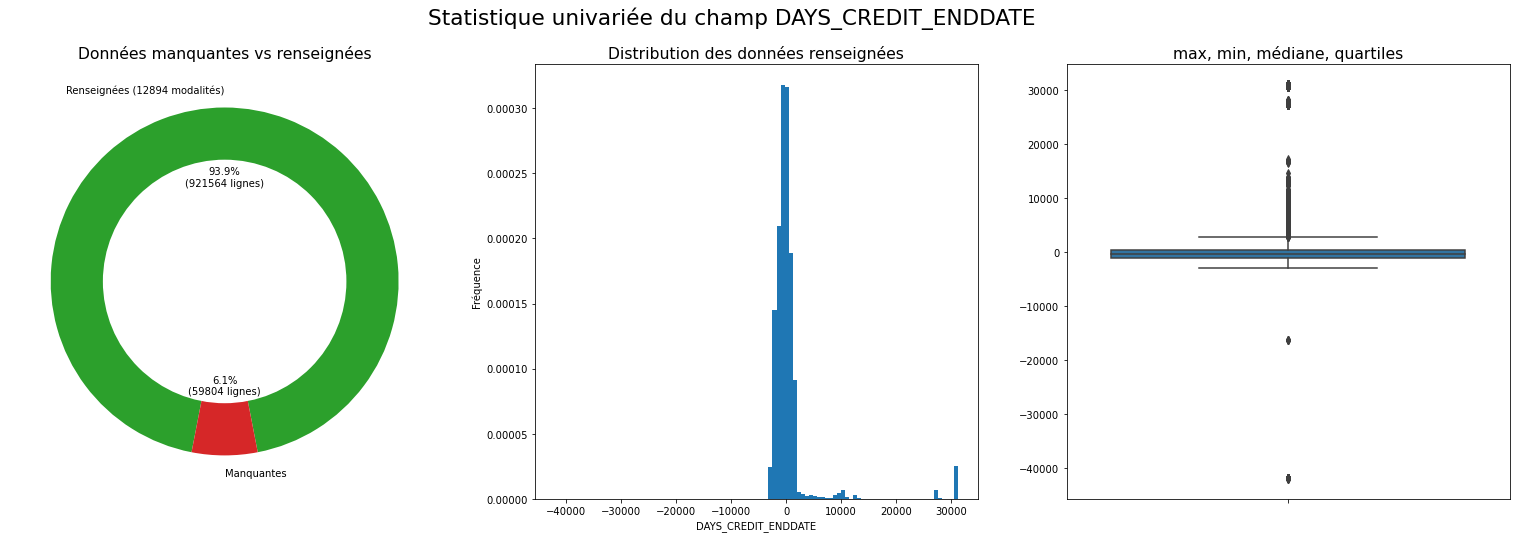

Mesures de position
 - Moyenne: 495.52
 - Médiane: -333.0
Mesures de dispertion
 - Ecart type: 4975.02
 - Min: -42060.0
 - Q25: -1143.0
 - Q75: 472.0
 - Max: 31199.0
Mesures de forme
 - Skewness (asymétrie): 5.13
 - Kurtosis (applatissement): 28.57


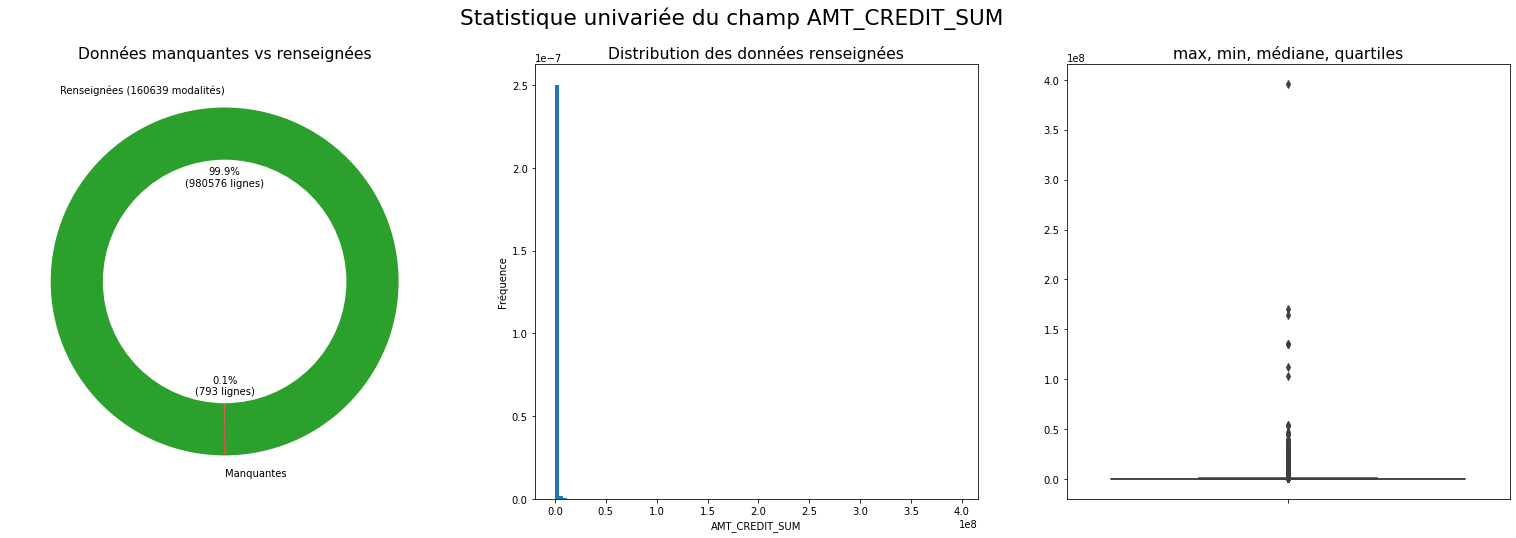

Mesures de position
 - Moyenne: 346099.67
 - Médiane: 124276.5
Mesures de dispertion
 - Ecart type: 1006853.9
 - Min: 0.0
 - Q25: 51165.0
 - Q75: 306000.0
 - Max: 396000000.0
Mesures de forme
 - Skewness (asymétrie): 87.46
 - Kurtosis (applatissement): 27222.38


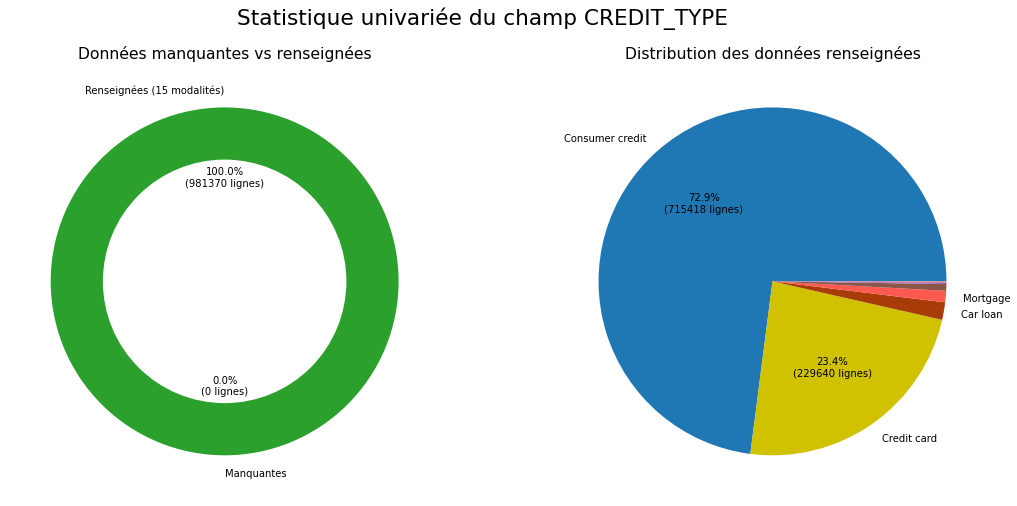

In [137]:
myDf(dfBureau).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_BUREAU','SK_ID_CURR'])

## Gestion des outliers

In [138]:
dfBureau = dfBureau[((dfBureau.DAYS_CREDIT_ENDDATE > -10000) & (dfBureau.DAYS_CREDIT_ENDDATE < 20000)) | dfBureau.DAYS_CREDIT_ENDDATE.isnull()]

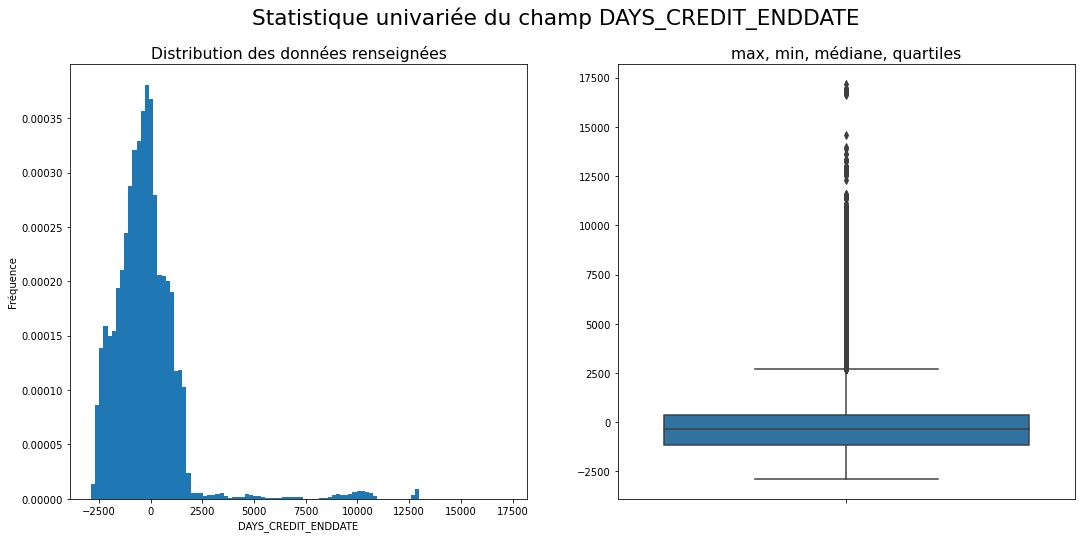

Mesures de position
 - Moyenne: -220.4
 - Médiane: -366.0
Mesures de dispertion
 - Ecart type: 1771.5
 - Min: -2890.0
 - Q25: -1167.0
 - Q75: 379.0
 - Max: 17185.0
Mesures de forme
 - Skewness (asymétrie): 3.47
 - Kurtosis (applatissement): 19.14


In [139]:
myDf(dfBureau).Stat('DAYS_CREDIT_ENDDATE')

# Exploration de Bureau Balance

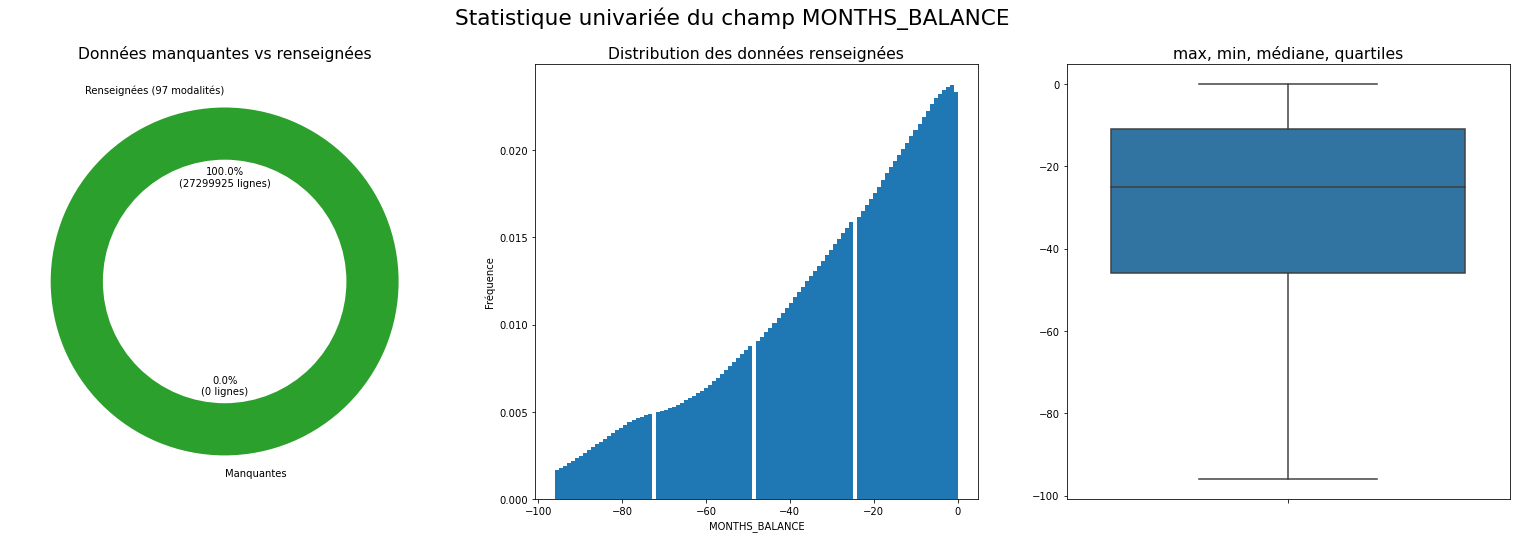

Mesures de position
 - Moyenne: -30.74
 - Médiane: -25.0
Mesures de dispertion
 - Ecart type: 23.86
 - Min: -96
 - Q25: -46.0
 - Q75: -11.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -0.76
 - Kurtosis (applatissement): -0.32


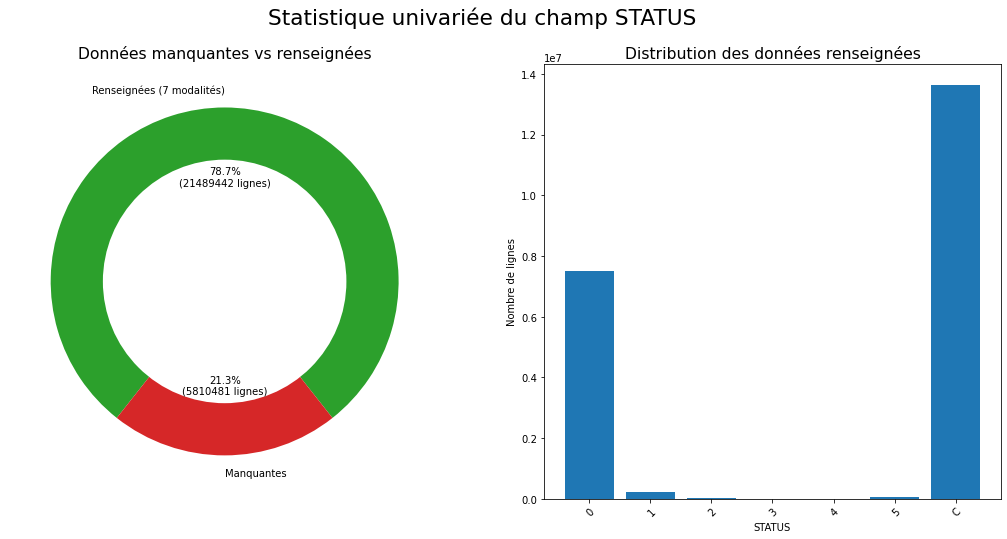

In [226]:
myDf(dfBureauBalance).Stat(['MONTHS_BALANCE','STATUS'], typeStat='univ', statsNan=True)

# Feature engineering

## Feature engineering sur des variables communes à Bureau et PreviousApplication

### Days credit et Days decision

In [140]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
dfDays = pd.concat([df1,df2])

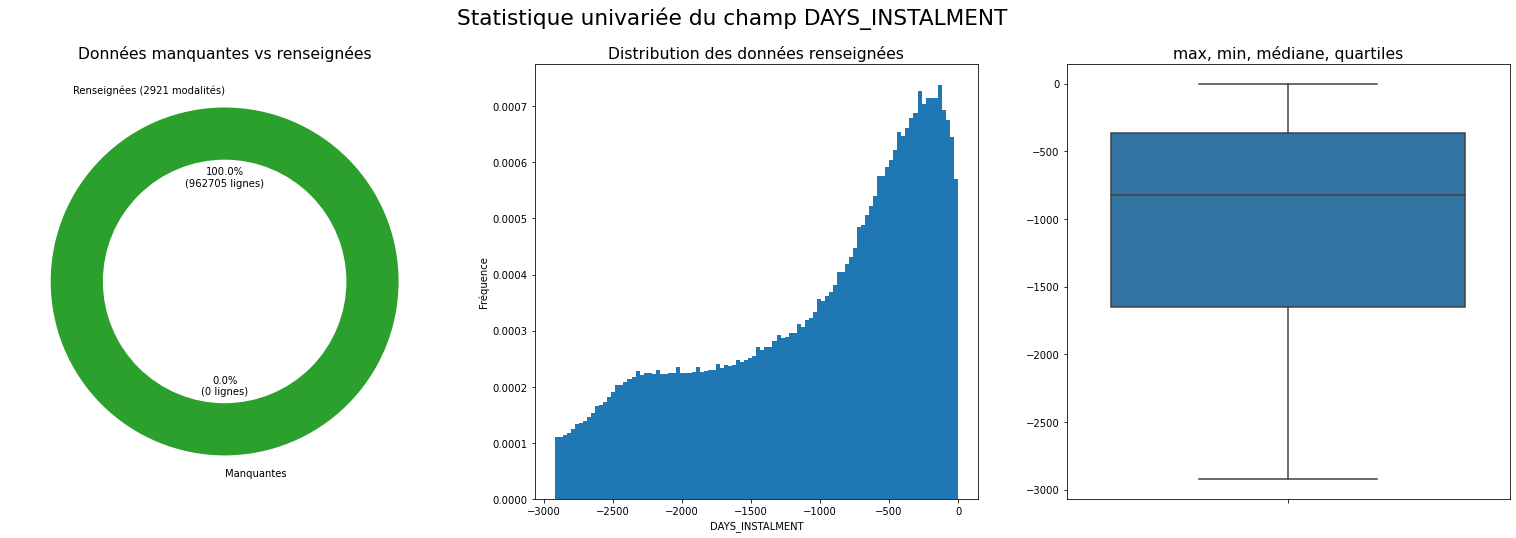

Mesures de position
 - Moyenne: -1045.79
 - Médiane: -826.0
Mesures de dispertion
 - Ecart type: 799.73
 - Min: -2922.0
 - Q25: -1653.0
 - Q75: -365.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.63
 - Kurtosis (applatissement): -0.79


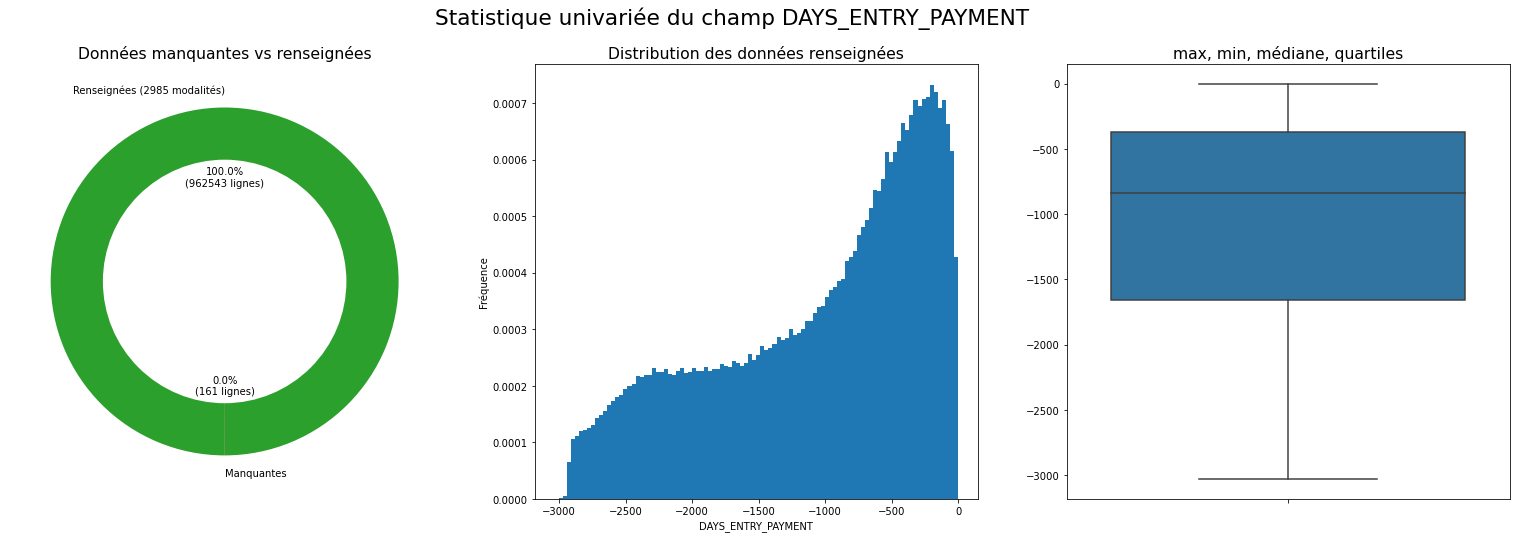

Mesures de position
 - Moyenne: -1054.55
 - Médiane: -835.0
Mesures de dispertion
 - Ecart type: 799.23
 - Min: -3031.0
 - Q25: -1661.0
 - Q75: -375.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.62
 - Kurtosis (applatissement): -0.8


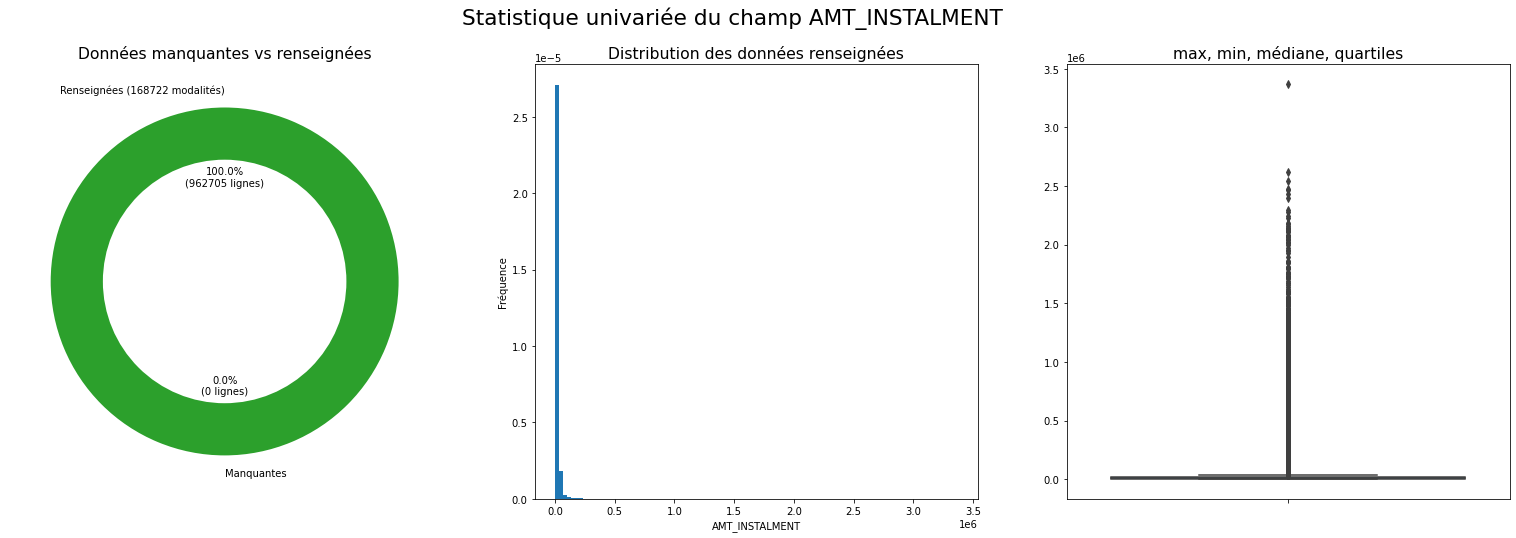

Mesures de position
 - Moyenne: 16891.28
 - Médiane: 8772.3
Mesures de dispertion
 - Ecart type: 50604.59
 - Min: 0.0
 - Q25: 4182.03
 - Q75: 16563.15
 - Max: 3371884.16
Mesures de forme
 - Skewness (asymétrie): 16.51
 - Kurtosis (applatissement): 404.66


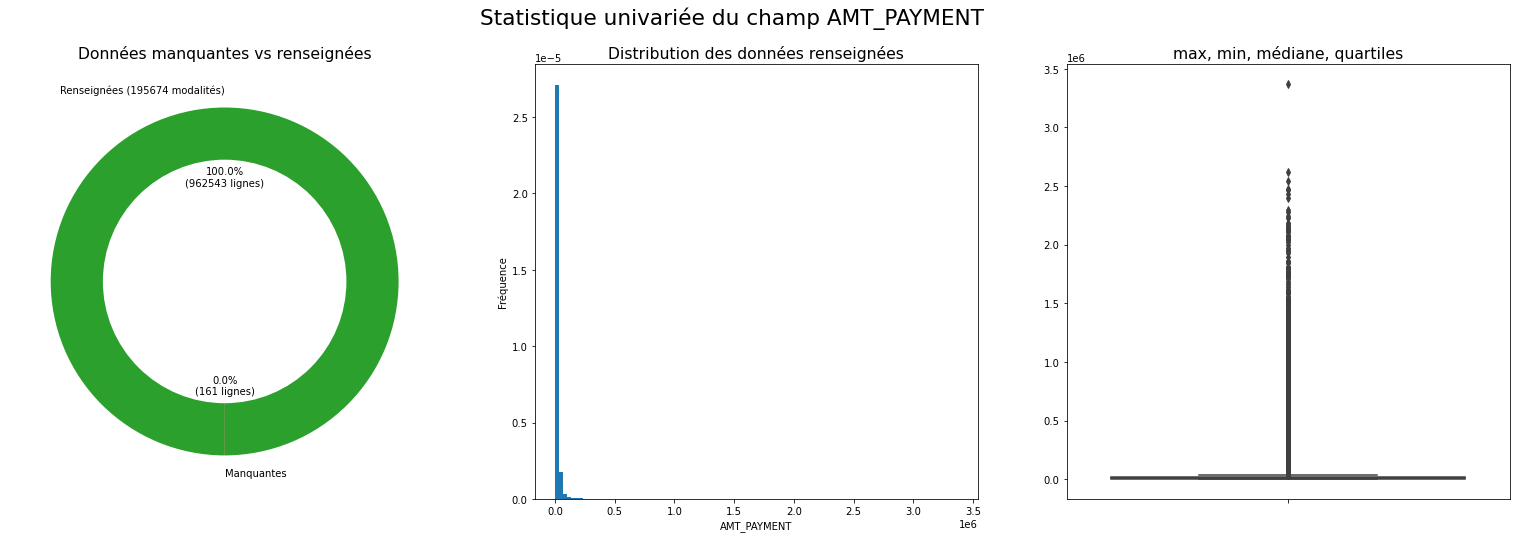

Mesures de position
 - Moyenne: 17082.12
 - Médiane: 8100.0
Mesures de dispertion
 - Ecart type: 54507.83
 - Min: 0.0
 - Q25: 3379.28
 - Q75: 15955.42
 - Max: 3371884.16
Mesures de forme
 - Skewness (asymétrie): 15.04
 - Kurtosis (applatissement): 329.84


In [21]:
myDf(dfInstallmentsPayments).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

In [141]:
dfDays.isnull().any()

SK_ID_CURR       False
SK_ID_PREV       False
DAYS_DECISION    False
dtype: bool

In [142]:
#https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
del dfDays['DAYS_DECISION']
del dfDays['SK_ID_PREV']
dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfDays['DAYS_DIFF'] = dfDays['DAYS_DIFF'].astype(int)

### Champs amount

#### Création d'une variable montant moyen logarithmique

Passage au log des montants

In [166]:
dfPreviousApplication['AMT_CREDIT_LOG'] = dfPreviousApplication.apply(lambda x: np.log(x.AMT_CREDIT+1), axis=1)
dfBureau['AMT_CREDIT_SUM_LOG'] = dfBureau.apply(lambda x: np.log(x.AMT_CREDIT_SUM+1), axis=1)

Concaténation

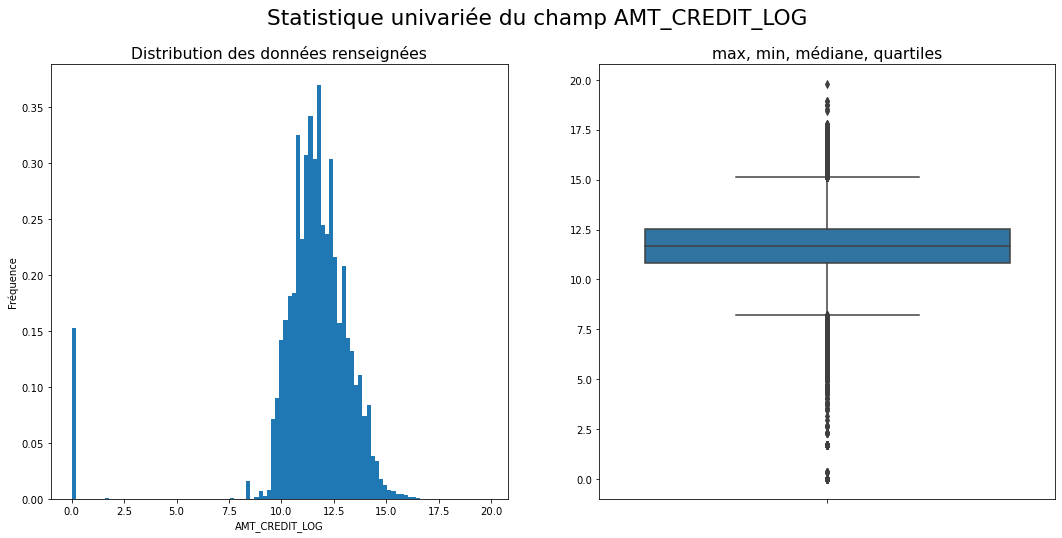

Mesures de position
 - Moyenne: 11.45
 - Médiane: 11.67
Mesures de dispertion
 - Ecart type: 2.36
 - Min: 0.0
 - Q25: 10.81
 - Q75: 12.54
 - Max: 19.8
Mesures de forme
 - Skewness (asymétrie): -3.31
 - Kurtosis (applatissement): 14.15


In [167]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM_LOG']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']]
dfAmtLog = pd.concat([df1,df2])
myDf(dfAmtLog).Stat('AMT_CREDIT_LOG')

Moyenne

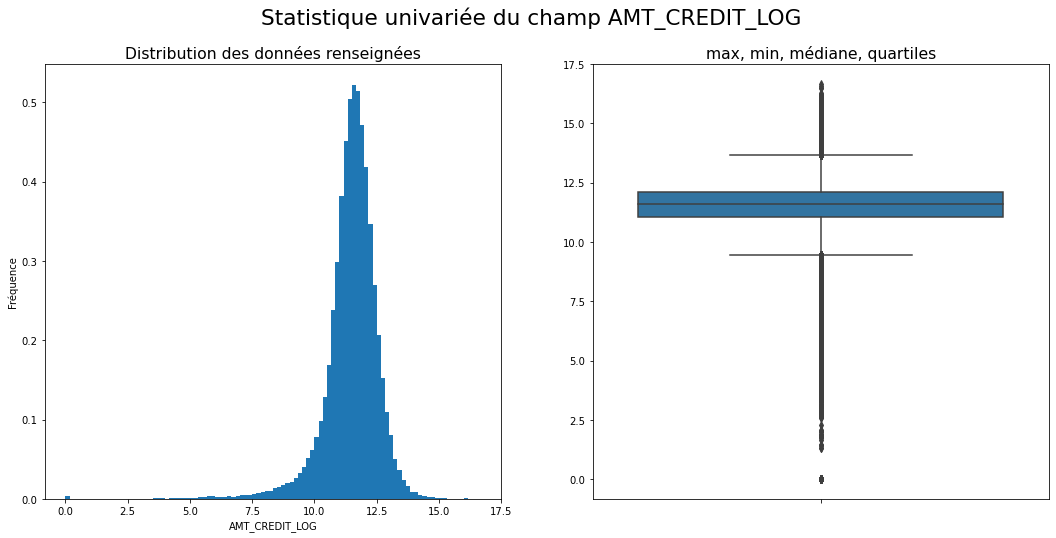

Mesures de position
 - Moyenne: 11.48
 - Médiane: 11.59
Mesures de dispertion
 - Ecart type: 1.1
 - Min: 0.0
 - Q25: 11.05
 - Q75: 12.1
 - Max: 16.67
Mesures de forme
 - Skewness (asymétrie): -2.1
 - Kurtosis (applatissement): 13.14


In [168]:
del dfAmtLog['SK_ID_PREV']
dfAmtLogMean = dfAmtLog.groupby('SK_ID_CURR').mean().reset_index(drop=False)
myDf(dfAmtLogMean).Stat('AMT_CREDIT_LOG')

#### Création d'une variable écart type logarithmique des montants 

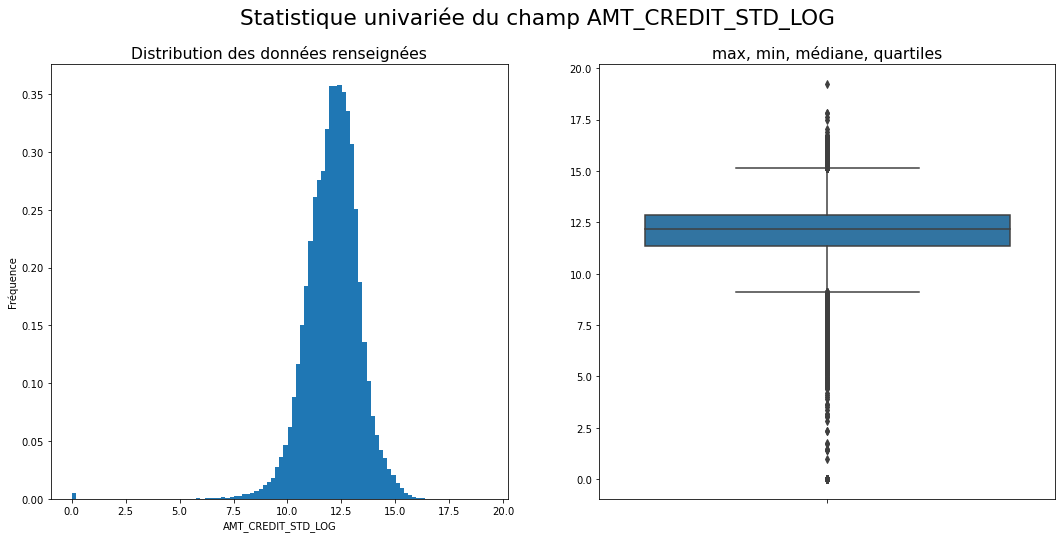

Mesures de position
 - Moyenne: 12.1
 - Médiane: 12.16
Mesures de dispertion
 - Ecart type: 1.23
 - Min: 0.0
 - Q25: 11.36
 - Q75: 12.88
 - Max: 19.25
Mesures de forme
 - Skewness (asymétrie): -1.23
 - Kurtosis (applatissement): 9.76


In [182]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']]
dfAmt = pd.concat([df1,df2])
del dfAmt['SK_ID_PREV']
dfAmtStdLog = dfAmt.groupby('SK_ID_CURR').std().reset_index(drop=False).rename(columns = {'AMT_CREDIT': 'AMT_CREDIT_STD'})
dfAmtStdLog['AMT_CREDIT_STD_LOG'] = dfAmtStd.apply(lambda x: np.log(1+x.AMT_CREDIT_STD), axis=1)
del dfAmtStdLog['AMT_CREDIT_STD']
myDf(dfAmtStdLog).Stat('AMT_CREDIT_STD_LOG')

#### Visualisation d'une variable écart type des montants logarithmique (non conservée)

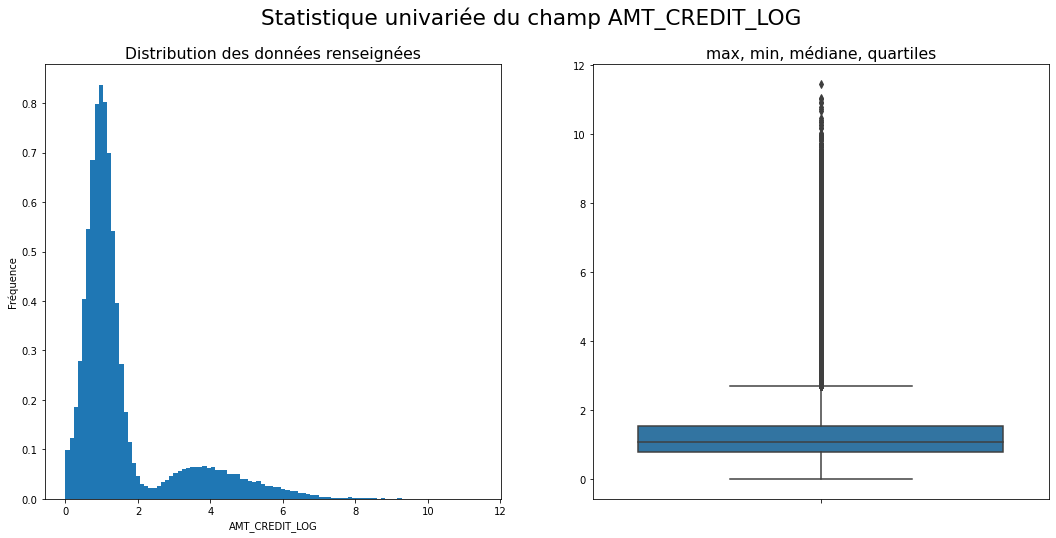

Mesures de position
 - Moyenne: 1.59
 - Médiane: 1.09
Mesures de dispertion
 - Ecart type: 1.43
 - Min: 0.0
 - Q25: 0.78
 - Q75: 1.55
 - Max: 11.45
Mesures de forme
 - Skewness (asymétrie): 1.93
 - Kurtosis (applatissement): 3.34


In [181]:
myDf(dfAmtLog.groupby('SK_ID_CURR').std().reset_index(drop=False)).Stat('AMT_CREDIT_LOG')

## Feature engineering sur PreviousApplication

### Feature engineering sur NAME_SELLER_INDUSTRY

#### NameSellerIndustry avec le plus gros montant cumulé par client

In [187]:
tmp0 = dfPreviousApplication[~dfPreviousApplication.NAME_SELLER_INDUSTRY.isnull()].reset_index(drop=False)
tmp1 = tmp0[['SK_ID_CURR','NAME_SELLER_INDUSTRY','AMT_CREDIT']].groupby(['SK_ID_CURR','NAME_SELLER_INDUSTRY']).sum().reset_index(drop=False)
tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT'], right_on=['SK_ID_CURR','AMT_CREDIT'])
tmp3.head(5)

SK_ID_CURR  NAME_SELLER_INDUSTRY  AMT_CREDIT
0      100002       Auto technology    179055.0
1      100004          Connectivity     20106.0
2      100008  Consumer electronics    773883.0
3      100010             Furniture    260811.0
4      100012          Connectivity     23697.0

Nombre de clients qui ressortent avec plusieurs lignes: on en sélectionne une au hasard

In [188]:
x = tmp3.SK_ID_CURR.value_counts()
len(x[x>1])

31

Pour les clients avec plusieurs seller_industry préférés, on en sélectionne un au hasard en se basant sur l'index

In [189]:
tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
tmp3 = tmp3.reset_index(drop=False)
tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
dfPreviousApplicationMainSellerIndustry = tmp3[['SK_ID_CURR','NAME_SELLER_INDUSTRY']]
dfPreviousApplicationMainSellerIndustry.columns = ['SK_ID_CURR','MAIN_SELLER_INDUSTRY']

#### Nombre de type de seller industry par client

In [190]:
dfPreviousApplicationNbSellerIndustry = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
dfPreviousApplicationNbSellerIndustry.columns = ['SK_ID_CURR','NB_SELLER_INDUSTRY']

#### Merge avec dfPreviousApplication

In [191]:
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationMainSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationNbSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfPreviousApplication['NAME_SELLER_INDUSTRY']

### Création d'une variable nombre de previous application

In [192]:
dfNbPreviousApplication = pd.DataFrame(dfPreviousApplication.groupby('SK_ID_CURR').size(), columns=['NB_PREVIOUS']).reset_index(drop=False)
dfPreviousApplication = dfPreviousApplication.merge(dfNbPreviousApplication, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

## Feature engineering sur Bureau

### Transformation de CREDIT_ACTIVE

On considère que les status Sold et Bad debt correspondent à de crédits actifs (comme dans https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering)

In [205]:
tmp = dfBureau[['CREDIT_ACTIVE','DAYS_CREDIT_ENDDATE']]
tmp = tmp[~tmp.DAYS_CREDIT_ENDDATE.isnull()]
tmp = tmp[tmp.DAYS_CREDIT_ENDDATE != 0]
tmp['DAYS_CREDIT_ENDDATE'] = tmp['DAYS_CREDIT_ENDDATE'] / abs(tmp['DAYS_CREDIT_ENDDATE'])
tmp.groupby(['CREDIT_ACTIVE','DAYS_CREDIT_ENDDATE']).size()

CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE
Active         -1.0                    45488
                1.0                   257546
Bad debt       -1.0                       13
Closed         -1.0                   529440
                1.0                    63282
Sold           -1.0                     2276
                1.0                     1118
dtype: int64

In [206]:
dfBureau['CREDIT_ACTIVE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_ACTIVE == 'Active', 1, 0), axis=1)

### Feature engineering sur CREDIT_TYPE

#### Type de crédit avec le plus gros montant cumulé par client

In [207]:
tmp0 = dfBureau[~dfBureau.CREDIT_TYPE.isnull()].reset_index(drop=False)
tmp1 = tmp0[['SK_ID_CURR','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR','CREDIT_TYPE']).sum().reset_index(drop=False)
tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT_SUM'], right_on=['SK_ID_CURR','AMT_CREDIT_SUM'])
tmp3.head(5)

SK_ID_CURR      CREDIT_TYPE  AMT_CREDIT_SUM
0      100002  Consumer credit      724806.000
1      100004  Consumer credit      189037.800
2      100008  Consumer credit      468445.500
3      100010  Consumer credit      675000.000
4      100014  Consumer credit     2729932.425

Clients qui ressortent avec plusieurs lignes: on en sélectionne une au hasard

In [208]:
x = tmp3.SK_ID_CURR.value_counts()
len(x[x>1])

129

In [209]:
tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
tmp3 = tmp3.reset_index(drop=False)
tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
dfBureauMainCreditType = tmp3[['SK_ID_CURR','CREDIT_TYPE']]
dfBureauMainCreditType.columns = ['SK_ID_CURR','MAIN_CREDIT_TYPE']

#### Nombre de type de crédits par client

In [210]:
dfBureauNbCreditType = dfBureau[['SK_ID_CURR','CREDIT_TYPE']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
dfBureauNbCreditType.columns = ['SK_ID_CURR','NB_CREDIT_TYPE']

#### Merge avec dfBureau

In [211]:
dfBureau = dfBureau.merge(dfBureauMainCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfBureau = dfBureau.merge(dfBureauNbCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfBureau['CREDIT_TYPE']

### Création d'une variable nombre de bureau

In [212]:
dfNbBureau = pd.DataFrame(dfBureau.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU']).reset_index(drop=False)
dfBureau = dfBureau.merge(dfNbBureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

## Fearture engineering sur Installment Payment

In [129]:
dfInstallmentsPaymentsOri = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
dfInstallmentsPayments = dfInstallmentsPaymentsOri[(dfInstallmentsPaymentsOri.SK_ID_CURR>175000) & (dfInstallmentsPaymentsOri.SK_ID_CURR<200000)]

In [130]:
dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]

### Nombre d'installment par client

In [131]:
dfInstallmentsPaymentsCount = pd.DataFrame(dfInstallmentsPayments.groupby('SK_ID_CURR').size(), columns=['NB_INSTALLMENT']).reset_index(drop=False)
dfInstallmentsPaymentsCount.head(3)

SK_ID_CURR  NB_INSTALLMENT
0      175001              10
1      175002              29
2      175003              14

### Différence entre les montants et dates effectifs et prévues (positifs et négatifs)

In [132]:
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: x.DAYS_INSTALMENT - x.DAYS_ENTRY_PAYMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.AMT_INSTALMENT - x.AMT_PAYMENT)/x.AMT_INSTALMENT, axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT>0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0), axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT<0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT>0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT<0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0), axis=1)

On applique un facteur temporel afin de diminuer l'impact des installments anciens

In [133]:
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_POS / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_NEG / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_POS / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_NEG / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)

In [134]:
dfInstallmentsPayments = dfInstallmentsPayments[['SK_ID_CURR','DIFF_DAYS_INSTALLMENT_PAYMENT_NEG','DIFF_DAYS_INSTALLMENT_PAYMENT_POS','DIFF_AMT_INSTALLMENT_PAYMENT_NEG','DIFF_AMT_INSTALLMENT_PAYMENT_POS']]

On somme par client

In [135]:
dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').sum().reset_index(drop=False)

On divise par le nombre d'installments

In [136]:
dfInstallmentsPayments = dfInstallmentsPayments.merge(dfInstallmentsPaymentsCount, right_on='SK_ID_CURR', left_on='SK_ID_CURR')
dfInstallmentsPayments

SK_ID_CURR  DIFF_DAYS_INSTALLMENT_PAYMENT_NEG  \
0          175001                           0.000000   
1          175002                          -0.191372   
2          175003                           0.000000   
3          175004                          -1.794636   
4          175005                          -0.524986   
...           ...                                ...   
23787      199995                          -1.124131   
23788      199996                           0.000000   
23789      199997                           0.000000   
23790      199998                          -1.619088   
23791      199999                          -0.149509   

       DIFF_DAYS_INSTALLMENT_PAYMENT_POS  DIFF_AMT_INSTALLMENT_PAYMENT_NEG  \
0                              16.607710                          0.000000   
1                              10.746188                          0.000000   
2                              12.361473                         -0.265709   
3                               3.481881                          0.000000   
4                              19.710058                         -0.454521   
...                                  ...                               ...   
23787                           9.468127                          0.000000   
23788                           1.830655                          0.000000   
23789                          18.622550                          0.000000   
23790                          24.219661                         -0.125952   
23791                          45.987523                          0.000000   

       DIFF_AMT_INSTALLMENT_PAYMENT_POS  NB_INSTALLMENT  
0                              0.000000              10  
1                              0.059083              29  
2                              0.000000              14  
3                              0.068391              14  
4                              0.107899              36  
...                                 ...             ...  
23787                          0.288538              11  
23788                          0.000000               6  
23789                          0.000000              36  
23790                          0.187060             153  
23791                          0.065041             107  

[23792 rows x 6 columns]

In [139]:
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_POS / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_NEG / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_POS / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_NEG / x.NB_INSTALLMENT, axis=1)

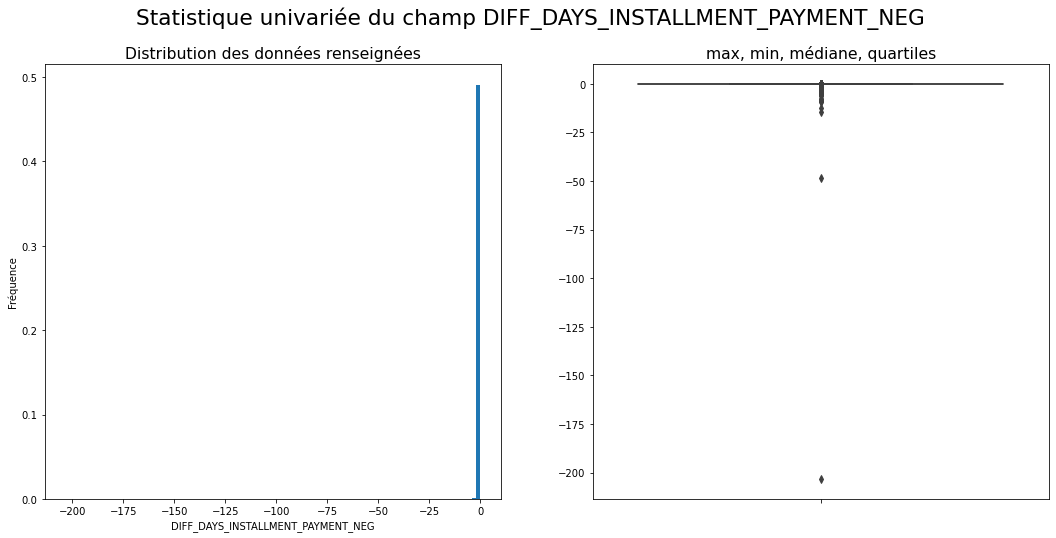

Mesures de position
 - Moyenne: -0.05
 - Médiane: -0.0
Mesures de dispertion
 - Ecart type: 1.38
 - Min: -203.3
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -136.96
 - Kurtosis (applatissement): 19973.11


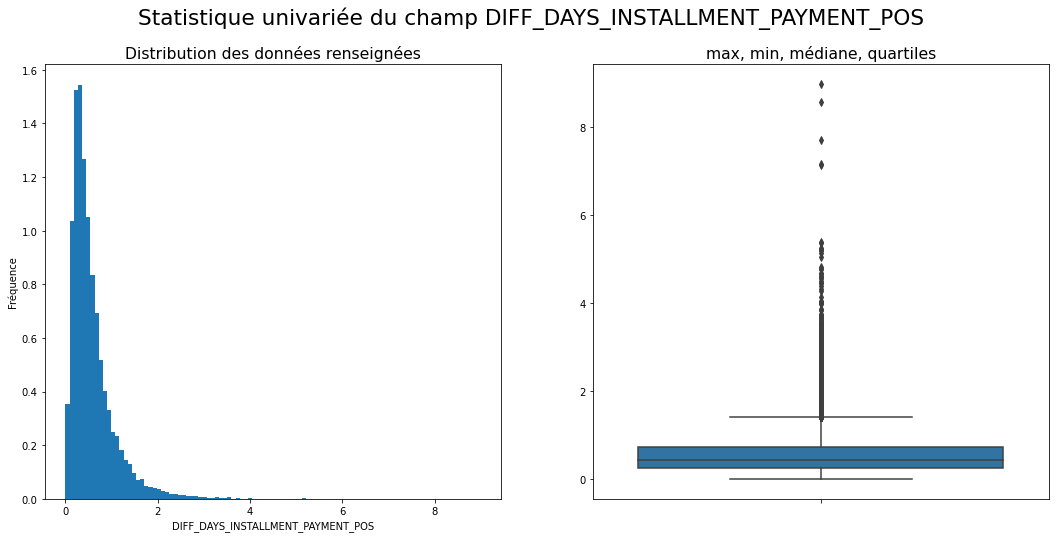

Mesures de position
 - Moyenne: 0.58
 - Médiane: 0.44
Mesures de dispertion
 - Ecart type: 0.5
 - Min: 0.0
 - Q25: 0.26
 - Q75: 0.72
 - Max: 8.99
Mesures de forme
 - Skewness (asymétrie): 3.11
 - Kurtosis (applatissement): 20.32


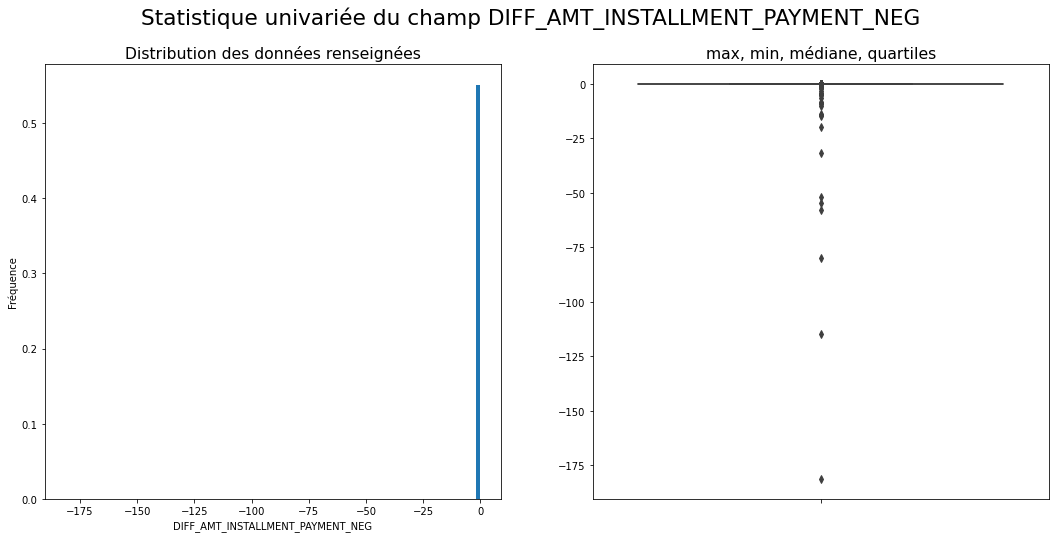

Mesures de position
 - Moyenne: -0.03
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1.64
 - Min: -181.32
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -81.3
 - Kurtosis (applatissement): 7689.17


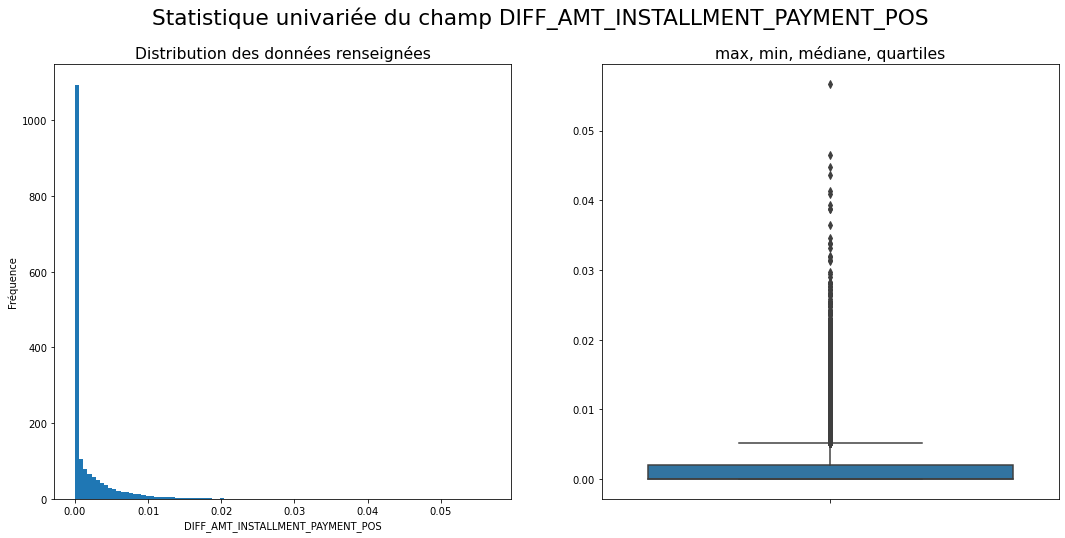

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.06
Mesures de forme
 - Skewness (asymétrie): 3.61
 - Kurtosis (applatissement): 20.69


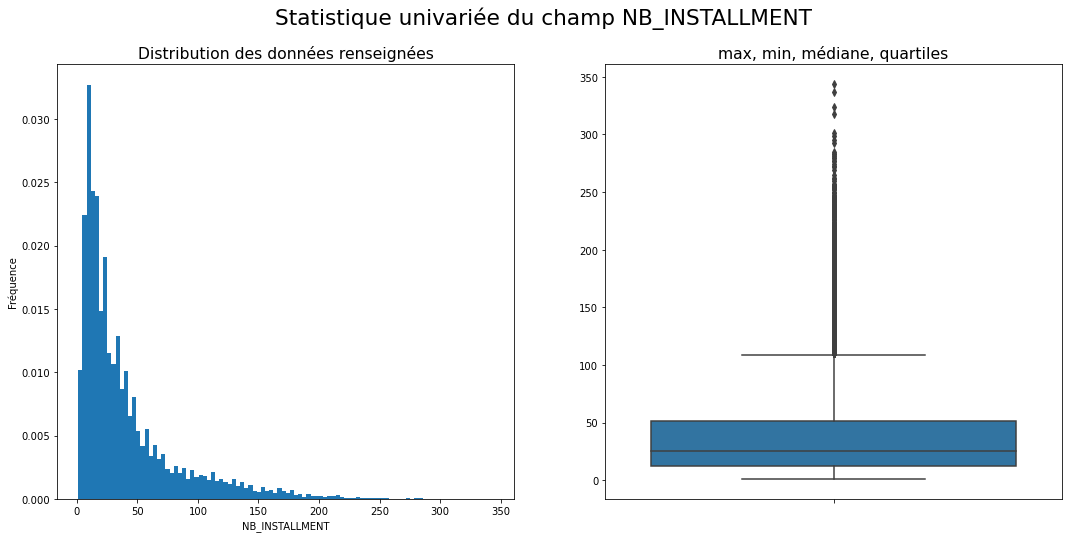

Mesures de position
 - Moyenne: 40.46
 - Médiane: 25.0
Mesures de dispertion
 - Ecart type: 41.98
 - Min: 1
 - Q25: 12.0
 - Q75: 51.0
 - Max: 344
Mesures de forme
 - Skewness (asymétrie): 2.02
 - Kurtosis (applatissement): 4.63


In [128]:
myDf(dfInstallmentsPayments).Stat(exclCol='SK_ID_CURR', typeStat='univ')

## Feature engineering sur Pos Cash Balance

In [101]:
dfPosCashBalanceCount = pd.DataFrame(dfPosCashBalance.groupby('SK_ID_CURR').size(), columns=['NB_POS_CASH_BALANCE']).reset_index(drop=False)
dfPosCashBalanceCount.head(3)

SK_ID_CURR  NB_POS_CASH_BALANCE
0      150001                   12
1      150003                   20
2      150004                   19

In [102]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfPosCashBalance['MONTHS_BALANCE']
del dfPosCashBalance['SK_ID_PREV']

In [103]:
dfPosCashBalance = dfPosCashBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)

In [104]:
dfPosCashBalance = dfPosCashBalance.merge(dfPosCashBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [105]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / x.NB_POS_CASH_BALANCE, axis=1)

In [112]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)

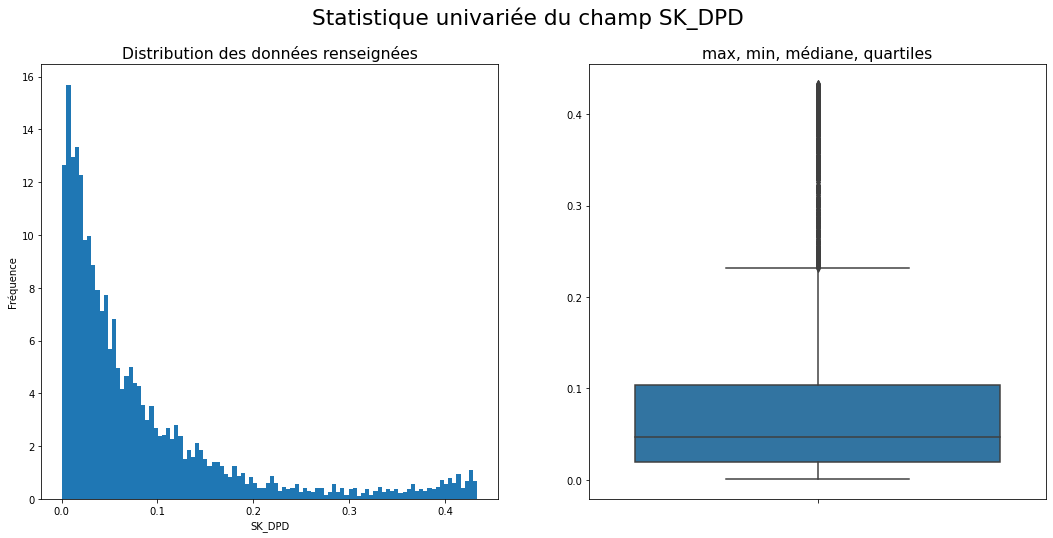

Mesures de position
 - Moyenne: 0.08
 - Médiane: 0.05
Mesures de dispertion
 - Ecart type: 0.1
 - Min: 0.0
 - Q25: 0.02
 - Q75: 0.1
 - Max: 0.43
Mesures de forme
 - Skewness (asymétrie): 2.01
 - Kurtosis (applatissement): 3.7


In [113]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD != 0]).Stat('SK_DPD')

## Feature engineering sur Bureau Balance

In [190]:
dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')

#### Création d'une variable iniquant le niveau de DPD (day past due) du client sur Bureau

On récupère le SK_ID_CURR

In [191]:
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_CURR','SK_ID_BUREAU']], left_on=['SK_ID_BUREAU'], right_on=['SK_ID_BUREAU'])

On compte le nombre de ligne par client

In [192]:
dfBureauBalanceCount = pd.DataFrame(dfBureauBalance.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU_BALANCE']).reset_index(drop=False)
dfBureauBalanceCount.head(3)

SK_ID_CURR  NB_BUREAU_BALANCE
0      100001                172
1      100002                110
2      100005                 21

On ne conserve que les lignes avec un DPD (day past due) positif

In [193]:
del dfBureauBalance['SK_ID_BUREAU']
dfBureauBalance = dfBureauBalance[dfBureauBalance.STATUS.isin(['1','2','3','4','5'])]
dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype('int')

On applique un facteur temporel afin de diminuer l'impact des DPD anciens

In [194]:
dfBureauBalance['STATUS_DPD'] = dfBureauBalance.apply(lambda x: x.STATUS / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfBureauBalance['STATUS']
del dfBureauBalance['MONTHS_BALANCE']

On somme par SK_ID_CURR

In [195]:
dfBureauDPD = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)[['SK_ID_CURR','STATUS_DPD']]

On divise par le nombre de lignes

In [196]:
dfBureauDPD = dfBureauDPD.merge(dfBureauBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
#dfBureauDPD['STATUS_DPD'] = dfBureauDPD.apply(lambda x: x.STATUS_DPD / x.NB_BUREAU_BALANCE, axis=1)

On ajoute les SK_ID_CURR sans DPD

In [197]:
dfBureauNoDPD = myDf(dfBureau).WhereNotExists(dfBureauDPD, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])[['SK_ID_CURR']].drop_duplicates()
dfBureauNoDPD['STATUS_DPD'] = 0

In [198]:
dfBureauDPD = pd.concat([dfBureauDPD,dfBureauNoDPD])

On passe au log

In [199]:
dfBureauDPD['STATUS_DPD'] = dfBureauDPD.apply(lambda x: np.log(1+x.STATUS_DPD), axis=1)

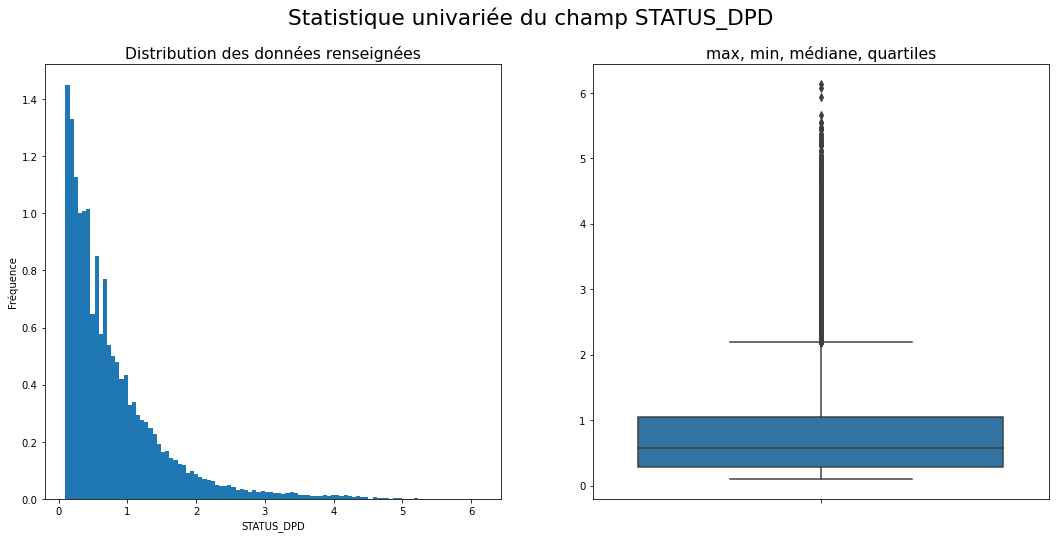

Mesures de position
 - Moyenne: 0.8
 - Médiane: 0.57
Mesures de dispertion
 - Ecart type: 0.74
 - Min: 0.1
 - Q25: 0.29
 - Q75: 1.05
 - Max: 6.14
Mesures de forme
 - Skewness (asymétrie): 2.12
 - Kurtosis (applatissement): 5.8


In [200]:
myDf(dfBureauDPD[dfBureauDPD.STATUS_DPD>0]).Stat('STATUS_DPD')

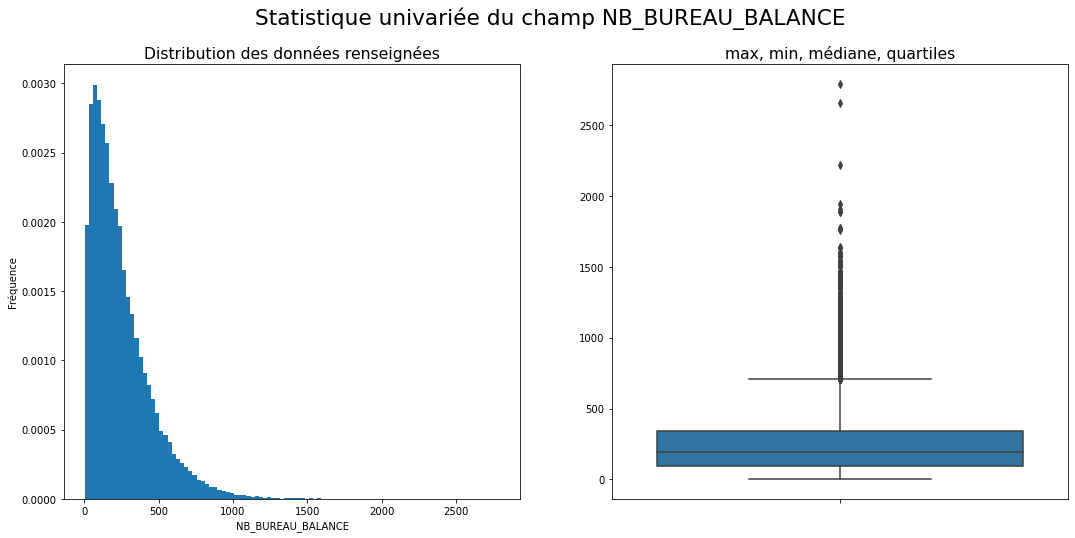

Mesures de position
 - Moyenne: 246.73
 - Médiane: 193.0
Mesures de dispertion
 - Ecart type: 205.11
 - Min: 2.0
 - Q25: 96.0
 - Q75: 340.0
 - Max: 2791.0
Mesures de forme
 - Skewness (asymétrie): 1.71
 - Kurtosis (applatissement): 4.95


In [201]:
myDf(dfBureauDPD).Stat('NB_BUREAU_BALANCE')

# Transformation de dfBureau et dfPreviousApplication en un dataframe avec une ligne par SK_ID_CURR

## Transformation de dfPreviousApplication

In [114]:
del dfPreviousApplication['SK_ID_PREV']
dfPreviousApplicationCat = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates()
dfPreviousApplicationNum = dfPreviousApplication.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfPreviousApplication = dfPreviousApplicationNum.merge(dfPreviousApplicationCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR')
dfPreviousApplication

SK_ID_CURR  AMT_CREDIT  RATE_DOWN_PAYMENT  DAYS_DECISION  \
0           100002  179055.000           0.000000       -606.000   
1           100004   20106.000           0.212008       -815.000   
2           100008  203459.625           0.073051      -1469.500   
3           100010  260811.000           0.000000      -1070.000   
4           100012   98826.000           0.000000      -1004.000   
...            ...         ...                ...            ...   
194718      456251   40455.000           0.000000       -273.000   
194719      456252   56821.500           0.062443      -2497.000   
194720      456253   20625.750           0.214316      -2380.000   
194721      456254  134439.750           0.000000       -299.500   
194722      456255  424431.000           0.064780       -587.625   

        NFLAG_INSURED_ON_APPROVAL  NAME_YIELD_GROUP_ENCODED  \
0                        0.000000                      1.00   
1                        0.000000                      2.00   
2                        0.250000                      1.25   
3                        0.000000                      1.00   
4                        0.666667                      3.00   
...                           ...                       ...   
194718                   0.000000                      3.00   
194719                   1.000000                      1.00   
194720                   0.500000                      3.00   
194721                   0.500000                      2.00   
194722                   0.333333                      2.00   

        NAME_CONTRACT_STATUS_ENCODED  X_SELL  NB_PREVIOUS  \
0                               1.00     0.0          1.0   
1                               1.00     0.0          1.0   
2                               1.00     1.0          4.0   
3                               1.00     0.0          1.0   
4                               1.00     1.0          3.0   
...                              ...     ...          ...   
194718                          1.00     0.0          1.0   
194719                          1.00     0.0          1.0   
194720                          1.00     0.0          2.0   
194721                          1.00     0.0          2.0   
194722                          0.75     1.0          8.0   

        NAME_SELLER_INDUSTRY  
0            Auto technology  
1               Connectivity  
2       Consumer electronics  
3                  Furniture  
4               Connectivity  
...                      ...  
194718          Connectivity  
194719  Consumer electronics  
194720          Connectivity  
194721  Consumer electronics  
194722          Connectivity  

[194723 rows x 10 columns]

## Transformation de dfBureau

### On isole les variables catégorielles

In [296]:
categorical_ix = list(dfBureau.select_dtypes(include=['object', 'bool']).columns)
cols = ['SK_ID_CURR']
cols.extend(categorical_ix)
dfBureauCat = dfBureau[cols].drop_duplicates()

### On moyenne les variables numériques

In [294]:
del dfBureau['SK_ID_BUREAU']
dfBureauNum = dfBureau.groupby('SK_ID_CURR').mean().reset_index(drop=False)

### Merge des variables numériques et catégorielles

In [297]:
dfBureau = dfBureauNum.merge(dfBureauCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR')
dfBureau

SK_ID_CURR  CREDIT_ACTIVE  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  \
0           100002       0.250000  -874.000000          -349.000000   
1           100004       0.000000  -867.000000          -488.500000   
2           100008       0.333333  -757.333333          -391.333333   
3           100010       0.500000 -1939.500000          -119.500000   
4           100014       0.250000 -1095.375000          -387.375000   
...            ...            ...          ...                  ...   
175662      456246       0.333333 -1361.000000          -234.666667   
175663      456249       0.153846 -1667.076923         -1232.333333   
175664      456253       0.500000  -867.500000           280.500000   
175665      456254       0.000000 -1104.000000          -859.000000   
175666      456255       0.400000 -1160.600000           822.400000   

        AMT_CREDIT_SUM  NB_CREDIT_TYPE MAIN_CREDIT_TYPE  
0             9.811994             2.0  Consumer credit  
1            11.456566             1.0  Consumer credit  
2            11.842916             1.0  Consumer credit  
3            13.041400             2.0  Consumer credit  
4            12.207262             1.0  Consumer credit  
...                ...             ...              ...  
175662       11.617111             2.0  Consumer credit  
175663       12.218622             3.0  Consumer credit  
175664       13.566311             2.0  Consumer credit  
175665       10.714440             1.0  Consumer credit  
175666       12.043499             2.0  Consumer credit  

[175667 rows x 7 columns]

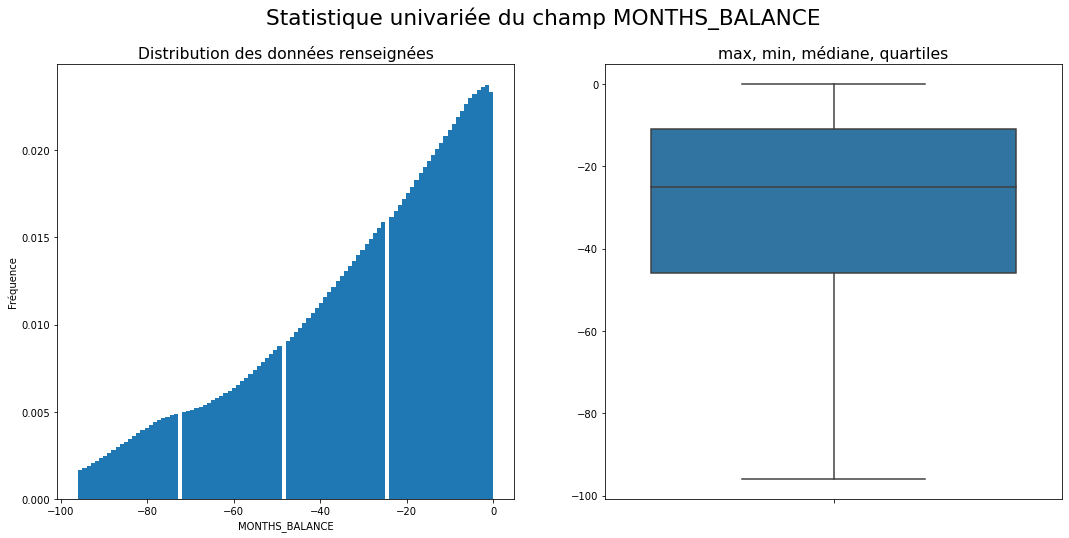

Mesures de position
 - Moyenne: -30.74
 - Médiane: -25.0
Mesures de dispertion
 - Ecart type: 23.86
 - Min: -96
 - Q25: -46.0
 - Q75: -11.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -0.76
 - Kurtosis (applatissement): -0.32


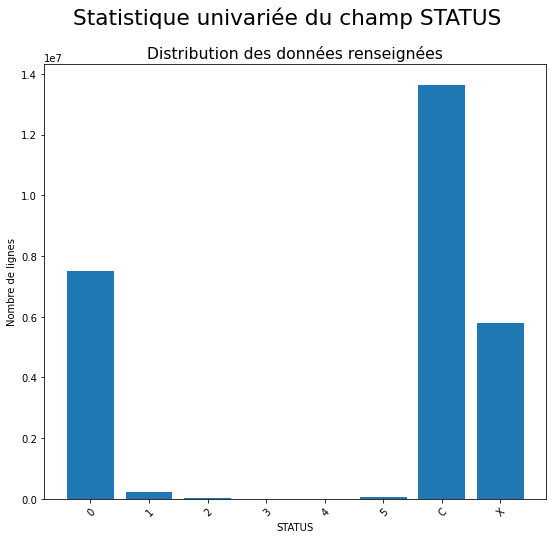

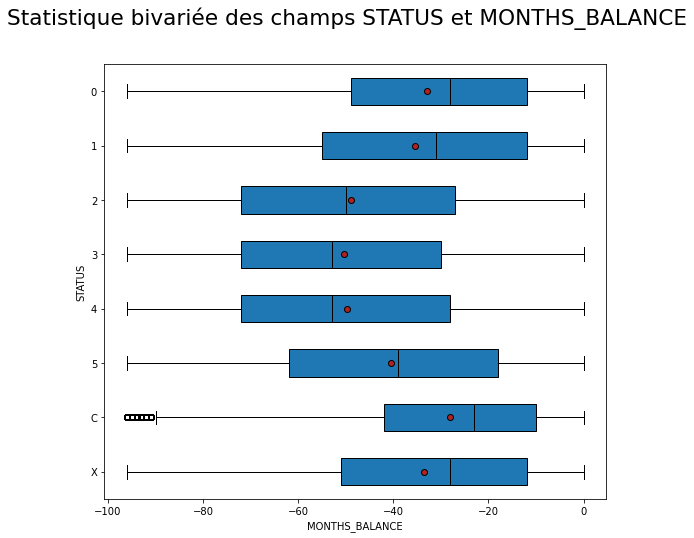

Rapport de corrélation entre STATUS et MONTHS_BALANCE: 0.012607592934848023
